<h1>NYC Rent Affordability Investigation:<br>Extract Transform Load & Preliminary Visualization</h1>

This is an investigation of rent affordability in NYC using neighborhood-level and borough-level from 2012-2022. 

I am using median rent data from the [Streeteasy Dashboard](https://streeteasy.com/blog/data-dashboard/), and median income data from the [U.S. Census American Community Survey](https://www.census.gov/programs-surveys/acs/data.html).

# Importing python packages and modules

In [7]:
# loading packages and modules (utils)
from utils.streeteasy_data_tools import tidy_rent_data
from utils.us_census_data_tools import Import_ACS_Table
from utils.psql_connection_tools import get_engine

In [50]:
# data acquisition, stats, & plotting
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
# estimators/models
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
# preprocessing & engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# model scoring
from sklearn.metrics import silhouette_score
# BigQuery Connection
import json
from google.cloud import bigquery
from google.oauth2 import service_account
# organization
import warnings
warnings.filterwarnings('ignore')

# Importing, Visualizing/Understanding, Preprocessing, and Uploading Rent Data

## Extract/Import Rent Data

1. Downloading the latest streeteasy data of median rental prices.

In [37]:
# Median asking rent for All APT sizes
df_rent_all = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                          "All/medianAskingRent_All.zip", compression='zip')

# Median asking rent for 1-Bedroom APTs
df_rent_1bdr = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                           "OneBd/medianAskingRent_OneBd.zip", compression='zip')

# Median asking rent for APTs with 3 Bedrooms or More
df_rent_3bdr = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                           "ThreePlusBd/medianAskingRent_ThreePlusBd.zip",
                            compression='zip')

df_rent_all

areaName    Borough      areaType  2010-01  2010-02  2010-03  \
0           All Downtown  Manhattan     submarket   3200.0   3200.0   3015.0   
1            All Midtown  Manhattan     submarket   2875.0   2800.0   2800.0   
2    All Upper East Side  Manhattan     submarket   2450.0   2450.0   2400.0   
3    All Upper Manhattan  Manhattan     submarket   1825.0   1800.0   1795.0   
4    All Upper West Side  Manhattan     submarket   2895.0   2800.0   2750.0   
..                   ...        ...           ...      ...      ...      ...   
193      Windsor Terrace   Brooklyn  neighborhood   1550.0   1600.0   1650.0   
194            Woodhaven     Queens  neighborhood      NaN      NaN      NaN   
195             Woodlawn      Bronx  neighborhood      NaN      NaN      NaN   
196             Woodside     Queens  neighborhood   1700.0   1647.5   1397.5   
197            Woodstock      Bronx  neighborhood      NaN      NaN      NaN   

     2010-04  2010-05  2010-06  2010-07  ...  2025-02  2025-03  2025-04  \
0     3100.0   3100.0   3200.0   3195.0  ...   5028.0   5000.0   5195.0   
1     2850.0   2895.0   2950.0   3000.0  ...   4595.0   4595.0   4695.0   
2     2500.0   2565.0   2570.0   2595.0  ...   3999.0   3995.0   4000.0   
3     1800.0   1823.0   1850.0   1875.0  ...   2877.0   2900.0   3000.0   
4     2800.0   2800.0   2795.0   2800.0  ...   4450.0   4500.0   4500.0   
..       ...      ...      ...      ...  ...      ...      ...      ...   
193   1600.0   1800.0   1825.0   1995.0  ...   3811.0   3800.0   3995.0   
194      NaN      NaN      NaN      NaN  ...   2300.0      NaN   2100.0   
195      NaN      NaN      NaN      NaN  ...      NaN      NaN      NaN   
196   2000.0   1500.0   1512.5   1487.5  ...   2950.0   2999.5   3100.0   
197      NaN      NaN      NaN      NaN  ...   1900.0      NaN      NaN   

     2025-05  2025-06  2025-07  2025-08  2025-09  2025-10  2025-11  
0     5250.0   5303.5   5450.0   5420.5   5350.0   5345.0   5350.0  
1     4750.0   4850.0   4873.0   4800.0   4750.0   4695.0   4638.0  
2     4150.0   4200.0   4200.0   4200.0   4200.0   4150.0   4250.0  
3     3195.0   3242.5   3299.0   3225.0   3200.0   3190.0   3125.0  
4     4500.0   4710.0   4795.0   4800.0   4800.0   4800.0   4800.0  
..       ...      ...      ...      ...      ...      ...      ...  
193   3950.0   4500.0   4695.0   4350.0   3995.0   3900.0   3555.0  
194   2250.0   2485.0   2200.0   2375.0   2500.0   2152.5   2125.0  
195      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
196   2977.5   3065.0   3050.0   3025.0   3025.0   3150.0   3115.5  
197      NaN      NaN      NaN      NaN      NaN      NaN      NaN  

[198 rows x 194 columns]

2. Download the inventory data, so we know the volume of units that make up the data.

This is important information, because it gives us important context that can help us determine the data comes from a large enough sample size.

In [38]:
# number of apartments that make up the rent price dataset for ALL appartment sizes.
df_inventory_all = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                                "All/rentalInventory_All.zip", compression='zip')
# number of 1 bedrooom apartments that make up the rent price dataset
df_inventory_1bdr = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                                "OneBd/rentalInventory_OneBd.zip", compression='zip')
# number of 3+ bedroom apartments that make up the rent price dataset.
df_inventory_3bdr = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                                "ThreePlusBd/rentalInventory_ThreePlusBd.zip", compression='zip')

df_inventory_all

areaName    Borough      areaType  2010-01  2010-02  2010-03  \
0           All Downtown  Manhattan     submarket     4254     4521     4593   
1            All Midtown  Manhattan     submarket     3065     3207     3239   
2    All Upper East Side  Manhattan     submarket     2549     2651     2638   
3    All Upper Manhattan  Manhattan     submarket      846      843      813   
4    All Upper West Side  Manhattan     submarket     2163     2186     2306   
..                   ...        ...           ...      ...      ...      ...   
193      Windsor Terrace   Brooklyn  neighborhood       16       19       14   
194            Woodhaven     Queens  neighborhood        0        0        0   
195             Woodlawn      Bronx  neighborhood        0        0        0   
196             Woodside     Queens  neighborhood       11       10       10   
197            Woodstock      Bronx  neighborhood        0        1        1   

     2010-04  2010-05  2010-06  2010-07  ...  2025-02  2025-03  2025-04  \
0       4679     4487     4577     4260  ...     3981     4855     5673   
1       3412     3117     3112     3028  ...     3245     3612     4018   
2       2583     2483     2650     2555  ...     1523     1686     1944   
3        738      707      770      754  ...     1792     2006     2051   
4       2452     2327     2413     2220  ...     1456     1595     1823   
..       ...      ...      ...      ...  ...      ...      ...      ...   
193       16       17       16       21  ...       82       93       81   
194        0        0        1        1  ...       17        9       16   
195        0        0        0        0  ...        2        1        2   
196       17       12       14       10  ...      145      138      158   
197        1        1        1        0  ...       11        8        8   

     2025-05  2025-06  2025-07  2025-08  2025-09  2025-10  2025-11  
0       6602     6742     6995     6416     5346     4952     4010  
1       4397     4374     4609     4324     3941     3735     3292  
2       2246     2292     2473     2177     2058     1932     1584  
3       2376     2406     2755     2528     2354     2165     1960  
4       2051     2227     2336     2125     1871     1635     1410  
..       ...      ...      ...      ...      ...      ...      ...  
193       85       82       77       90       93       83       63  
194       15       16       22       12       14       14       12  
195        1        2        3        2        0        0        0  
196      148      138      110      130      154      142      138  
197        5        4        6        4        5        2        2  

[198 rows x 194 columns]

## Tidying the Rent Datasets

Let's convert all of the rent datasets into tidy format, and ensure columns names and contents are optimized for usability.

In [39]:
# melting DFs and splitting the month-year column into separate columns
rent_all_clean = tidy_rent_data(df_rent_all)
rent_1bdr_clean = tidy_rent_data(df_rent_1bdr)
rent_3bdr_clean = tidy_rent_data(df_rent_3bdr)

# merging datasets to create one median_rent DF
merged_table = pd.merge(rent_all_clean.rename(columns={"median_rent":"all_price"}), 
                        rent_1bdr_clean.rename(columns={"median_rent":"1bdr_price"}), 
                        how='inner', on=["area_name", "borough", "area_type","year","month"]
                        )

median_rent_table = pd.merge(merged_table, 
                        rent_3bdr_clean.rename(columns={"median_rent":"3bdr_price"}), 
                        how='inner', on=["area_name", "borough", "area_type","year","month"]
                        )
median_rent_table

area_name    borough     area_type  year month  all_price  \
0             All Downtown  Manhattan     submarket  2010    01     3200.0   
1              All Midtown  Manhattan     submarket  2010    01     2875.0   
2      All Upper East Side  Manhattan     submarket  2010    01     2450.0   
3      All Upper Manhattan  Manhattan     submarket  2010    01     1825.0   
4      All Upper West Side  Manhattan     submarket  2010    01     2895.0   
...                    ...        ...           ...   ...   ...        ...   
37813      Windsor Terrace   Brooklyn  neighborhood  2025    11     3555.0   
37814            Woodhaven     Queens  neighborhood  2025    11     2125.0   
37815             Woodlawn      Bronx  neighborhood  2025    11        NaN   
37816             Woodside     Queens  neighborhood  2025    11     3115.5   
37817            Woodstock      Bronx  neighborhood  2025    11        NaN   

       1bdr_price  3bdr_price  
0          2995.0      6700.0  
1          2800.0      7500.0  
2          2350.0      8925.0  
3          1500.0      2700.0  
4          2600.0      7000.0  
...           ...         ...  
37813      3130.0         NaN  
37814         NaN         NaN  
37815         NaN         NaN  
37816      2800.0      3875.0  
37817         NaN         NaN  

[37818 rows x 8 columns]

In [40]:
inventory_all_clean = tidy_rent_data(df_inventory_all)
inventory_1bdr_clean = tidy_rent_data(df_inventory_1bdr)
inventory_3bdr_clean = tidy_rent_data(df_inventory_3bdr)
# merging datasets to create one median_rent DF
merged_table = pd.merge(inventory_all_clean.rename(columns={"median_rent":"all_count"}), 
                        inventory_1bdr_clean.rename(columns={"median_rent":"1bdr_count"}), 
                        how='inner', on=["area_name", "borough", "area_type","year","month"]
                        )

median_inventory_table = pd.merge(merged_table, 
                        inventory_3bdr_clean.rename(columns={"median_rent":"3bdr_count"}), 
                        how='inner', on=["area_name", "borough", "area_type","year","month"]
                        )
median_inventory_table

area_name    borough     area_type  year month  all_count  \
0             All Downtown  Manhattan     submarket  2010    01       4254   
1              All Midtown  Manhattan     submarket  2010    01       3065   
2      All Upper East Side  Manhattan     submarket  2010    01       2549   
3      All Upper Manhattan  Manhattan     submarket  2010    01        846   
4      All Upper West Side  Manhattan     submarket  2010    01       2163   
...                    ...        ...           ...   ...   ...        ...   
37813      Windsor Terrace   Brooklyn  neighborhood  2025    11         63   
37814            Woodhaven     Queens  neighborhood  2025    11         12   
37815             Woodlawn      Bronx  neighborhood  2025    11          0   
37816             Woodside     Queens  neighborhood  2025    11        138   
37817            Woodstock      Bronx  neighborhood  2025    11          2   

       1bdr_count  3bdr_count  
0          1641.0       463.0  
1          1410.0       207.0  
2          1063.0       260.0  
3           285.0       160.0  
4           935.0       265.0  
...           ...         ...  
37813        21.0         6.0  
37814         4.0         5.0  
37815         NaN         NaN  
37816        54.0        16.0  
37817         1.0         1.0  

[37818 rows x 8 columns]

Let's merge the median rent price and apartment inventory tables, so we have all pertinent data in the same table. 

In [41]:
# Creating our Primary Rent Data Table
rent_df = pd.merge(median_rent_table, 
                   median_inventory_table, how='inner', 
                   on=["area_name", "borough", "area_type","year","month"]
                   )

rent_df

area_name    borough     area_type  year month  all_price  \
0             All Downtown  Manhattan     submarket  2010    01     3200.0   
1              All Midtown  Manhattan     submarket  2010    01     2875.0   
2      All Upper East Side  Manhattan     submarket  2010    01     2450.0   
3      All Upper Manhattan  Manhattan     submarket  2010    01     1825.0   
4      All Upper West Side  Manhattan     submarket  2010    01     2895.0   
...                    ...        ...           ...   ...   ...        ...   
37813      Windsor Terrace   Brooklyn  neighborhood  2025    11     3555.0   
37814            Woodhaven     Queens  neighborhood  2025    11     2125.0   
37815             Woodlawn      Bronx  neighborhood  2025    11        NaN   
37816             Woodside     Queens  neighborhood  2025    11     3115.5   
37817            Woodstock      Bronx  neighborhood  2025    11        NaN   

       1bdr_price  3bdr_price  all_count  1bdr_count  3bdr_count  
0          2995.0      6700.0       4254      1641.0       463.0  
1          2800.0      7500.0       3065      1410.0       207.0  
2          2350.0      8925.0       2549      1063.0       260.0  
3          1500.0      2700.0        846       285.0       160.0  
4          2600.0      7000.0       2163       935.0       265.0  
...           ...         ...        ...         ...         ...  
37813      3130.0         NaN         63        21.0         6.0  
37814         NaN         NaN         12         4.0         5.0  
37815         NaN         NaN          0         NaN         NaN  
37816      2800.0      3875.0        138        54.0        16.0  
37817         NaN         NaN          2         1.0         1.0  

[37818 rows x 11 columns]

## Transform\Preprocess Rent Data

### Cleaning Data

In [ ]:
# explicitly setting the data type for all columns
rent_df['year'] = rent_df['year'].astype('int')
rent_df['month'] = rent_df['month'].astype('int')
rent_df = rent_df.convert_dtypes()
print(rent_df.dtypes)

Let's look at a dsitribution of the volume of apartment units sampled across monthly values. 

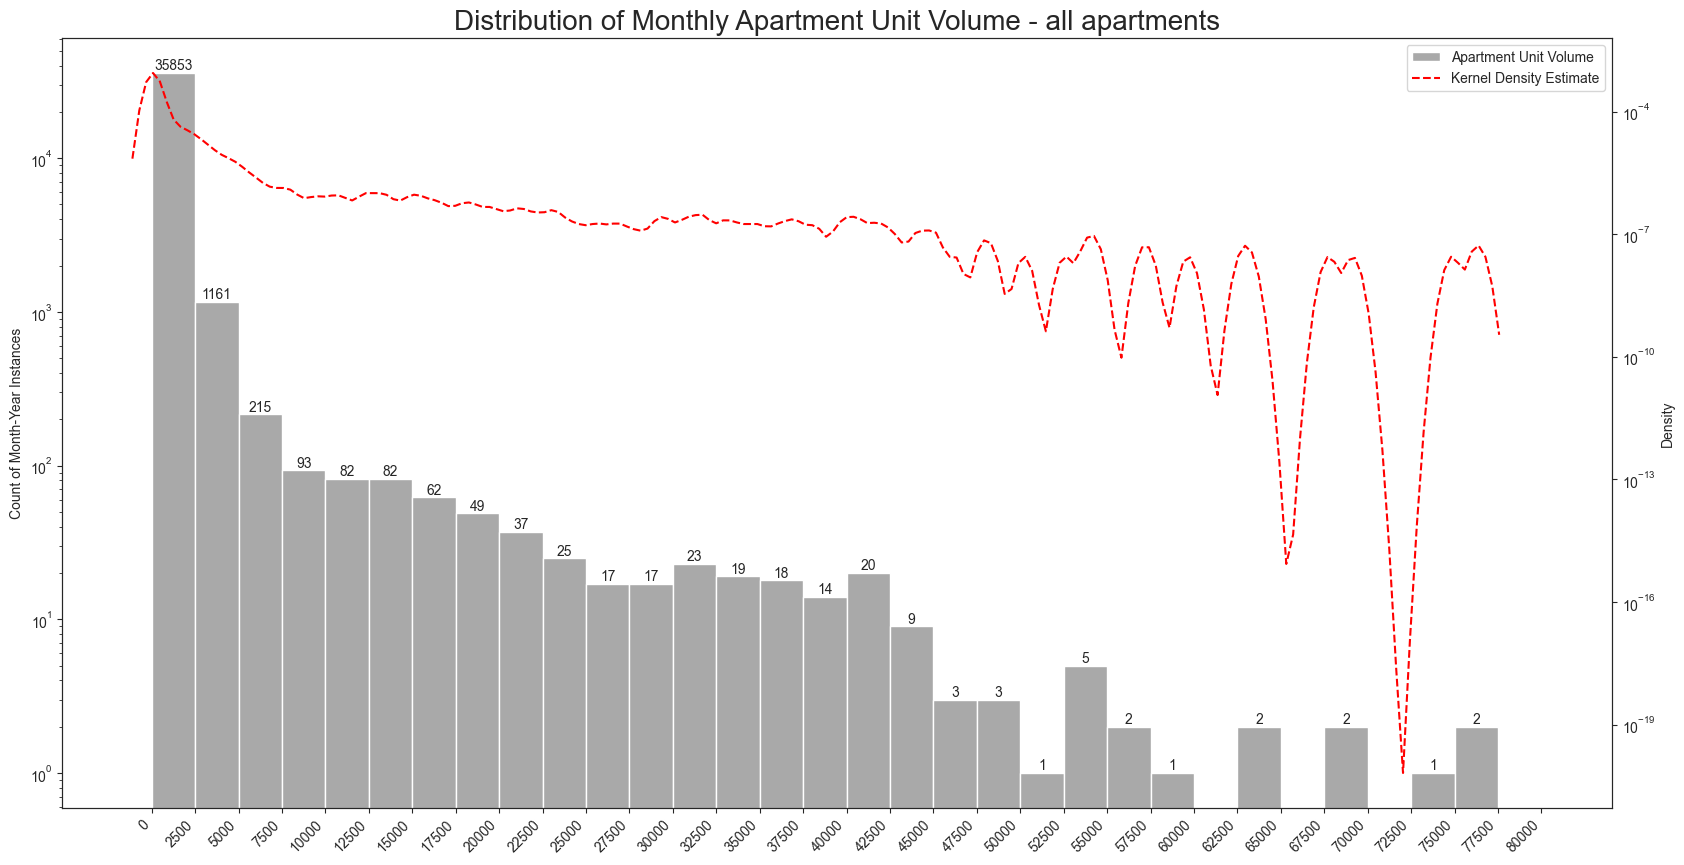

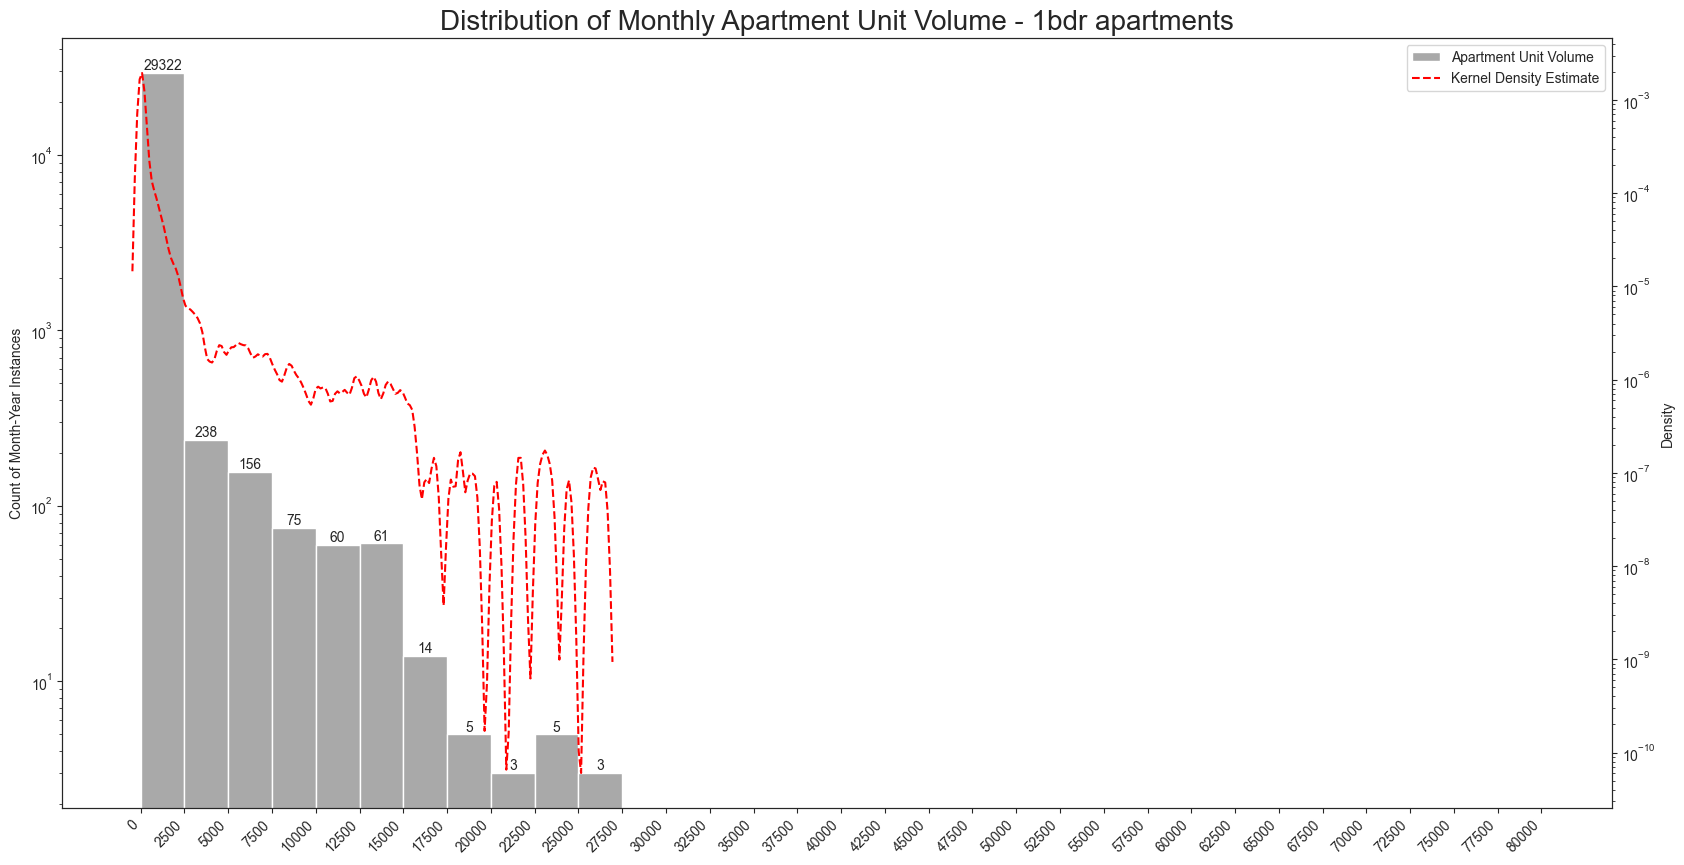

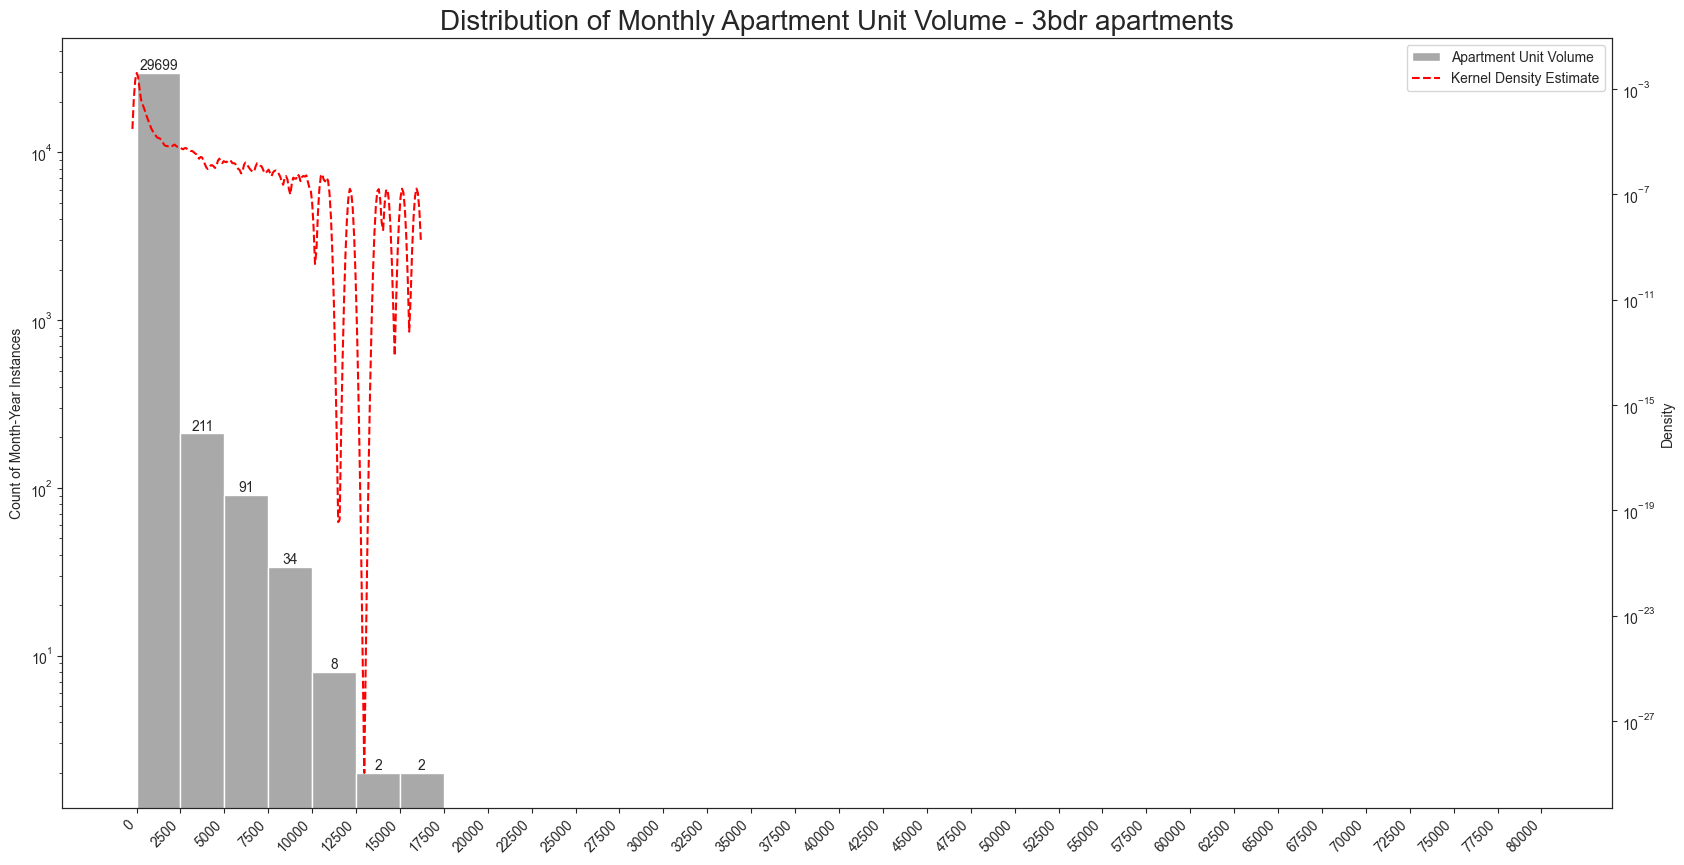

In [ ]:
type = ['all','1bdr','3bdr']


for apt in type:
    x_ticks = np.arange(0,82500,2500)
    fig, ax = plt.subplots(figsize=(20,10))
    counts, bins, patches = ax.hist(rent_df[f'{apt}_count'], bins=32, range=[0,80000], log=True,
                                    label='Apartment Unit Volume', **{'facecolor':'darkgrey','edgecolor':'white'})
    ax.set_xticks(x_ticks, x_ticks.astype('int'), rotation=45, ha='right')
    ax.bar_label(patches, labels=[f'{int(c)}' for c in counts], label_type='edge')
    ax.set_ylabel('Count of Month-Year Instances')
    ax2 = ax.twinx()
    sns.kdeplot(rent_df[f'{apt}_count'], ax=ax2, color="red", linestyle="--", 
                label="Kernel Density Estimate", log_scale=(False, True))
    ax2.set_ylabel("Density")

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best')
    plt.title(f'Distribution of Monthly Apartment Unit Volume - {apt} apartments', fontsize=20)
    plt.xlabel('Volume of Units')
    plt.show()

Most month-year instances have less than 2,500 apartment units in their sample size. 

Let's ensure we're working with only relevant data

In [ ]:
cols = rent_df.columns.to_numpy(dtype='str')
# looking at the first 3 columns
for i in range(1,3):
    print(f'{cols[i]} values = {np.unique(rent_df[cols[i]].to_numpy(dtype='str'))}')
nhbd_num = len(rent_df['area_name'].unique())
print(f'number of neighborhoods = {nhbd_num}')

print("WE ARE ONLY INTERESTED IN DATA AT THE NEIGHBORHOOD & BOROUGH LEVEL, SO WE'RE GOING TO REMOVE ALL OTHER AREA TYPES")
rent_df = rent_df[(rent_df['area_type'] == 'neighborhood')|(rent_df['area_type'] == 'borough')]
# revisit stats
cols = rent_df.columns.to_numpy(dtype='str')
for i in range(1,3):
    print(f'{cols[i]} values = {np.unique(rent_df[cols[i]].to_numpy(dtype='str'))}')
nhbd_num = len(rent_df['area_name'].unique())
print(f'number of neighborhoods = {nhbd_num}')

print("WE WANT TO ENSURE THAT WE ARE LOOKING AT DATA FROM A LARGE ENOUGH SAMPLE SIZE, SO WE ARE REMOVING ENTRIES WITH LESS THAN 500 APT UNITS")
rent_df.loc[~(rent_df['all_count'] >= 500), 'all_price'] = np.nan
rent_df.loc[~(rent_df['1bdr_count'] >= 500), '1bdr_price'] = np.nan
rent_df.loc[~(rent_df['3bdr_count'] >= 500), '3bdr_price'] = np.nan
# let's remove rows where all 3 apartment types have less than the threshold of units
rent_df = rent_df.loc[~((np.isnan(rent_df['all_price']))&(np.isnan(rent_df['1bdr_price']))&(np.isnan(rent_df['3bdr_price'])))]
# revisit stats
cols = rent_df.columns.to_numpy(dtype='str')
for i in range(1,3):
    print(f'{cols[i]} values = {np.unique(rent_df[cols[i]].to_numpy(dtype='str'))}')
nhbds = rent_df['area_name'].unique()
print(f'number of neighborhoods = {len(nhbds)}')
print(f'neighborhoods = {nhbds}')

print("2025 HAS INCOMPLETE MONTHS OF DATA, SO WE'RE GOING TO REMOVE THAT FROM THE DATASET")
rent_df = rent_df[rent_df['year'] < 2025]

rent_df

borough values = ['Bronx' 'Brooklyn' 'Manhattan' 'Queens']
area_type values = ['borough' 'neighborhood']
number of neighborhoods = 44
WE ARE ONLY INTERESTED IN DATA AT THE NEIGHBORHOOD & BOROUGH LEVEL, SO WE'RE GOING TO REMOVE ALL OTHER AREA TYPES
borough values = ['Bronx' 'Brooklyn' 'Manhattan' 'Queens']
area_type values = ['borough' 'neighborhood']
number of neighborhoods = 44
WE WANT TO ENSURE THAT WE ARE LOOKING AT DATA FROM A LARGE ENOUGH SAMPLE SIZE, SO WE ARE REMOVING ENTRIES WITH LESS THAN 500 APT UNITS
borough values = ['Bronx' 'Brooklyn' 'Manhattan' 'Queens']
area_type values = ['borough' 'neighborhood']
number of neighborhoods = 44
neighborhoods = <StringArray>
[                 'Brooklyn',                   'Chelsea',
        'Financial District',                 'Manhattan',
              'Midtown East',              'Midtown West',
                    'Queens',           'Upper East Side',
           'Upper West Side',              'West Village',
              'East Vill

area_name    borough     area_type  year  month  all_price  \
24               Brooklyn   Brooklyn       borough  2010      1       2200   
36                Chelsea  Manhattan  neighborhood  2010      1       3200   
67     Financial District  Manhattan  neighborhood  2010      1       3200   
108             Manhattan  Manhattan       borough  2010      1       2800   
116          Midtown East  Manhattan  neighborhood  2010      1       2695   
...                   ...        ...           ...   ...    ...        ...   
35560        Midtown West  Manhattan  neighborhood  2024     12       4350   
35592              Queens     Queens       borough  2024     12       2999   
35623     Upper East Side  Manhattan  neighborhood  2024     12       3950   
35624     Upper West Side  Manhattan  neighborhood  2024     12       4400   
35634        Williamsburg   Brooklyn  neighborhood  2024     12       4450   

       1bdr_price  3bdr_price  all_count  1bdr_count  3bdr_count  
24           1950        <NA>       1820         723         256  
36           <NA>        <NA>        605         236          55  
67           <NA>        <NA>        645         226          45  
108          2670        6500      12907        5342        1362  
116          2675        <NA>       1518         649         128  
...           ...         ...        ...         ...         ...  
35560        <NA>        <NA>       1165         458         104  
35592        2650        3599       4265        1805         601  
35623        3700        <NA>       1639         642         221  
35624        4252        <NA>       1365         505         253  
35634        <NA>        <NA>       1206         381         229  

[3745 rows x 11 columns]

In [ ]:
rent_df.describe()

year     month    all_price  1bdr_price   3bdr_price  \
count       3745.0    3745.0       3745.0      1421.0        703.0   
mean   2017.988251  6.556742  3104.309746  2896.26038  4162.476529   
std       3.795292  3.343342    758.10634  650.328888  1602.917291   
min         2010.0       1.0       1425.0      1750.0       2500.0   
25%         2015.0       4.0       2500.0      2379.0       2950.0   
50%         2018.0       7.0       3050.0      2933.0       3395.0   
75%         2021.0       9.0       3500.0      3295.0       5500.0   
max         2024.0      12.0       7100.0      4583.0       9950.0   

         all_count   1bdr_count  3bdr_count  
count       3745.0       3745.0      3745.0  
mean   2612.495861   956.024032  455.162083  
std    4504.893978  1679.279304  813.221222  
min          500.0         40.0         6.0  
25%          702.0        257.0        95.0  
50%         1077.0        371.0       185.0  
75%         2070.0        781.0       392.0  
max        41829.0      15492.0      7587.0

### Quantifying Missing Data at the Neighborhood & Borough level

In [ ]:
def create_data_availability_heatmap(rent_df, borough='Manhattan', figsize=(30, 15), apt_type='1bdr',
                                     subtitle='All Apartments'):
    """
    This FX creates a heatmap of data availability (1s and 0s) for rent data
    by neighborhood and year-month date combos.
    
    Input:
        df_rent_all: pandas dataframe with neighborhoods and date columns
        borough: string representing the borough to filter for (default: 'Manhattan')
        figsize: tuple of the figure size for the plot
    """
    
    # Filter data for the specified borough and/or neighborhood type
    if borough == 'Staten Island':
        subset_df = rent_df[rent_df['borough'] == borough]
    else:
        subset_df = rent_df[(rent_df['borough'] == borough) & 
                            (rent_df['area_type'] == 'neighborhood')].copy()

    # subsetting pertinent columns
    subset_data = subset_df[['area_name','year','month',f'{apt_type}_price']].reset_index(drop=True)
    
    # Get neighborhood names for labeling
    neighborhood_names = subset_data['area_name'].reset_index(drop=True).drop_duplicates()

    # get month-year dates for plot axis
    dates = (pd.Series([f"{month:02d}" for month in subset_data['month']]).astype('str')+'-'+subset_data['year'].astype('str')).drop_duplicates() 
    
    # Create the availability matrix (1 for data present, 0 for missing)
    # Shape: (neighborhoods, dates)
    availability_matrix = np.zeros((len(neighborhood_names), len(dates)))
    
    # Fill the matrix
    for row_idx, neighborhood in enumerate(neighborhood_names):
        for col_idx, date in enumerate(dates):
            month = int(date[:2])
            year = int(date[3:])
            cell_value = subset_data[(subset_data['month'] == month)&(subset_data['year'] == year)&(subset_data['area_name'] == neighborhood)][f'{apt_type}_price']
            # Check if data is present (not NaN)
            if cell_value.any():
                availability_matrix[row_idx, col_idx] = 1
            else:
                availability_matrix[row_idx, col_idx] = 0

    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Use a custom colormap: white for missing (0), dark blue for present (1)
    colors = ['#FFFFFF', '#00008B'] 
    custom_cmap = mpl.colors.ListedColormap(colors)
    
    # Create heatmap
    ax = sns.heatmap(availability_matrix, 
                     cmap=custom_cmap,
                     cbar=False,
                     xticklabels=dates,
                     yticklabels=neighborhood_names,
                     linewidths=0.1,
                     linecolor='lightgray')
    
    # Customize the plot
    ax.set_title(f'Data Availability Heatmap: {borough} Neighborhoods - {subtitle}\n' + 
              'Dark Blue = Data Present, White = Data Missing', 
              fontsize=25, fontweight='bold', pad=20)
    ax.set_xlabel('Year-Month', fontsize=15, fontweight='bold')
    ax.set_ylabel('Neighborhoods', fontsize=15, fontweight='bold')
    ax.set_xticks(ticks=np.arange(0.5, len(dates)+0.5, 2), labels=dates[::2], rotation=75, ha='right',)
    ax.set_xticklabels(labels=dates[::2], fontdict={'fontsize': 15})
    ax.set_yticks(ticks=np.arange(0.5, len(neighborhood_names)+0.5))
    ax.set_yticklabels(labels=neighborhood_names, fontdict={'fontsize': 15})
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    total_cells = availability_matrix.size
    present_data = np.sum(availability_matrix)
    missing_data = total_cells - present_data
    
    print(f"Data Availability Summary for {borough}:")
    print(f"Total data points: {total_cells}")
    print(f"Data present: {present_data} ({present_data/total_cells*100:.1f}%)")
    print(f"Data missing: {missing_data} ({missing_data/total_cells*100:.1f}%)")
    print(f"Number of neighborhoods: {len(neighborhood_names)}")
    print(f"Number of time periods: {len(dates)}")
    
    return

#### All Apartments

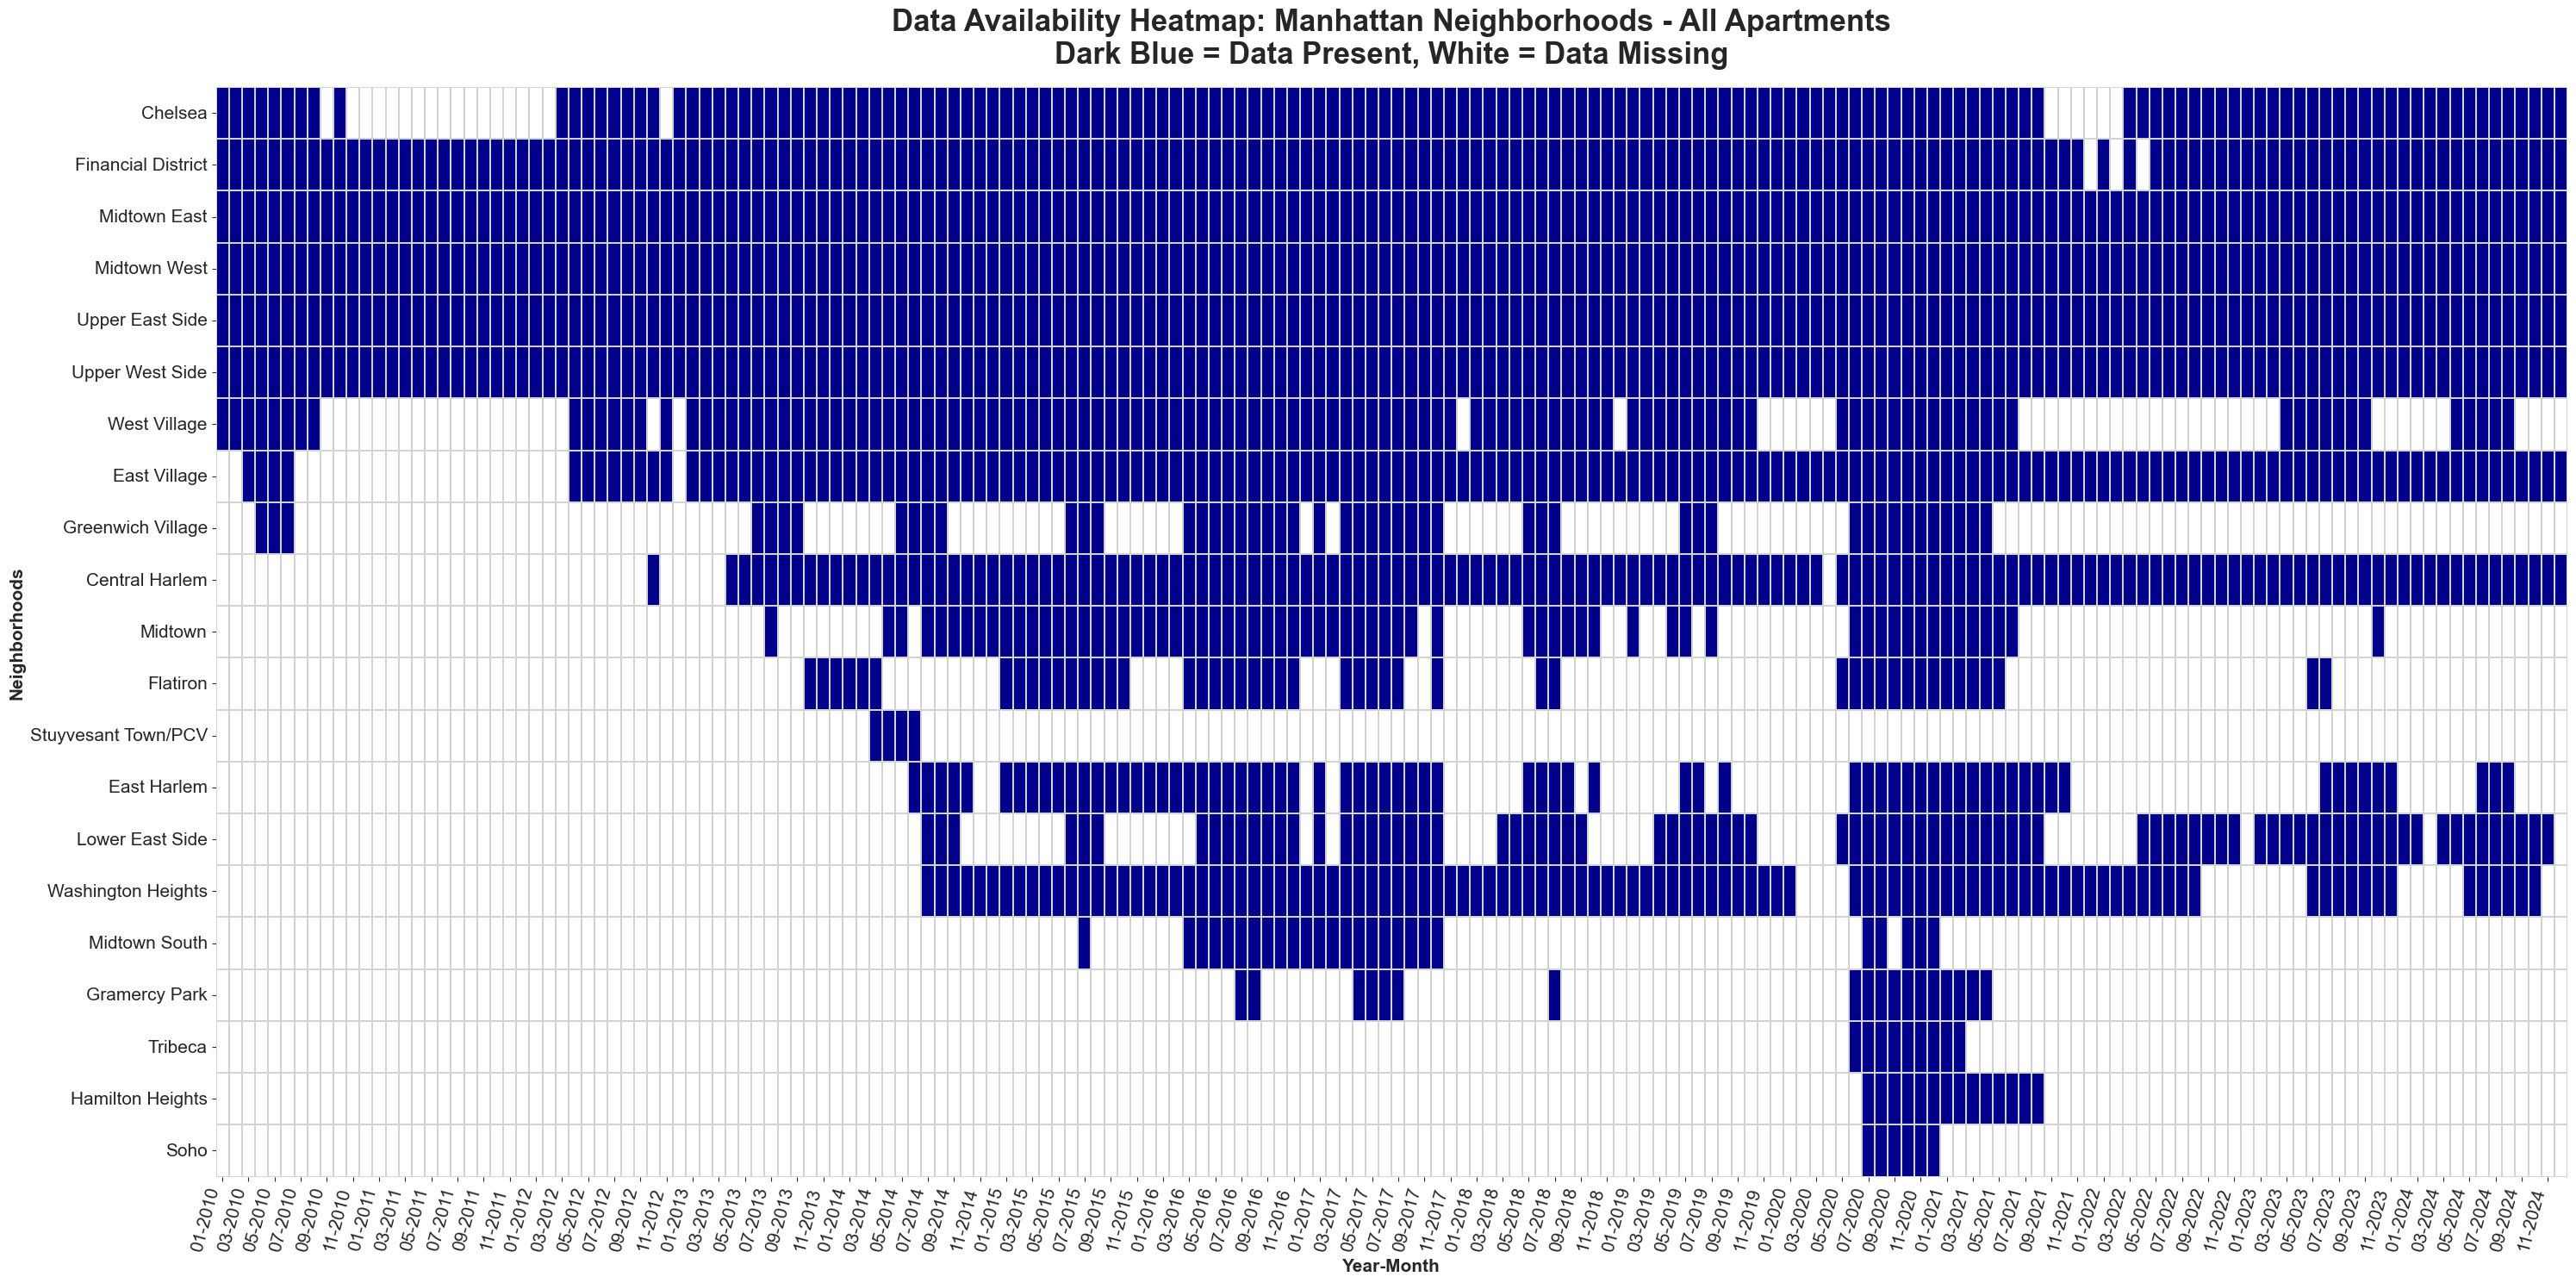

Data Availability Summary for Manhattan:
Total data points: 3780
Data present: 1973.0 (52.2%)
Data missing: 1807.0 (47.8%)
Number of neighborhoods: 21
Number of time periods: 180


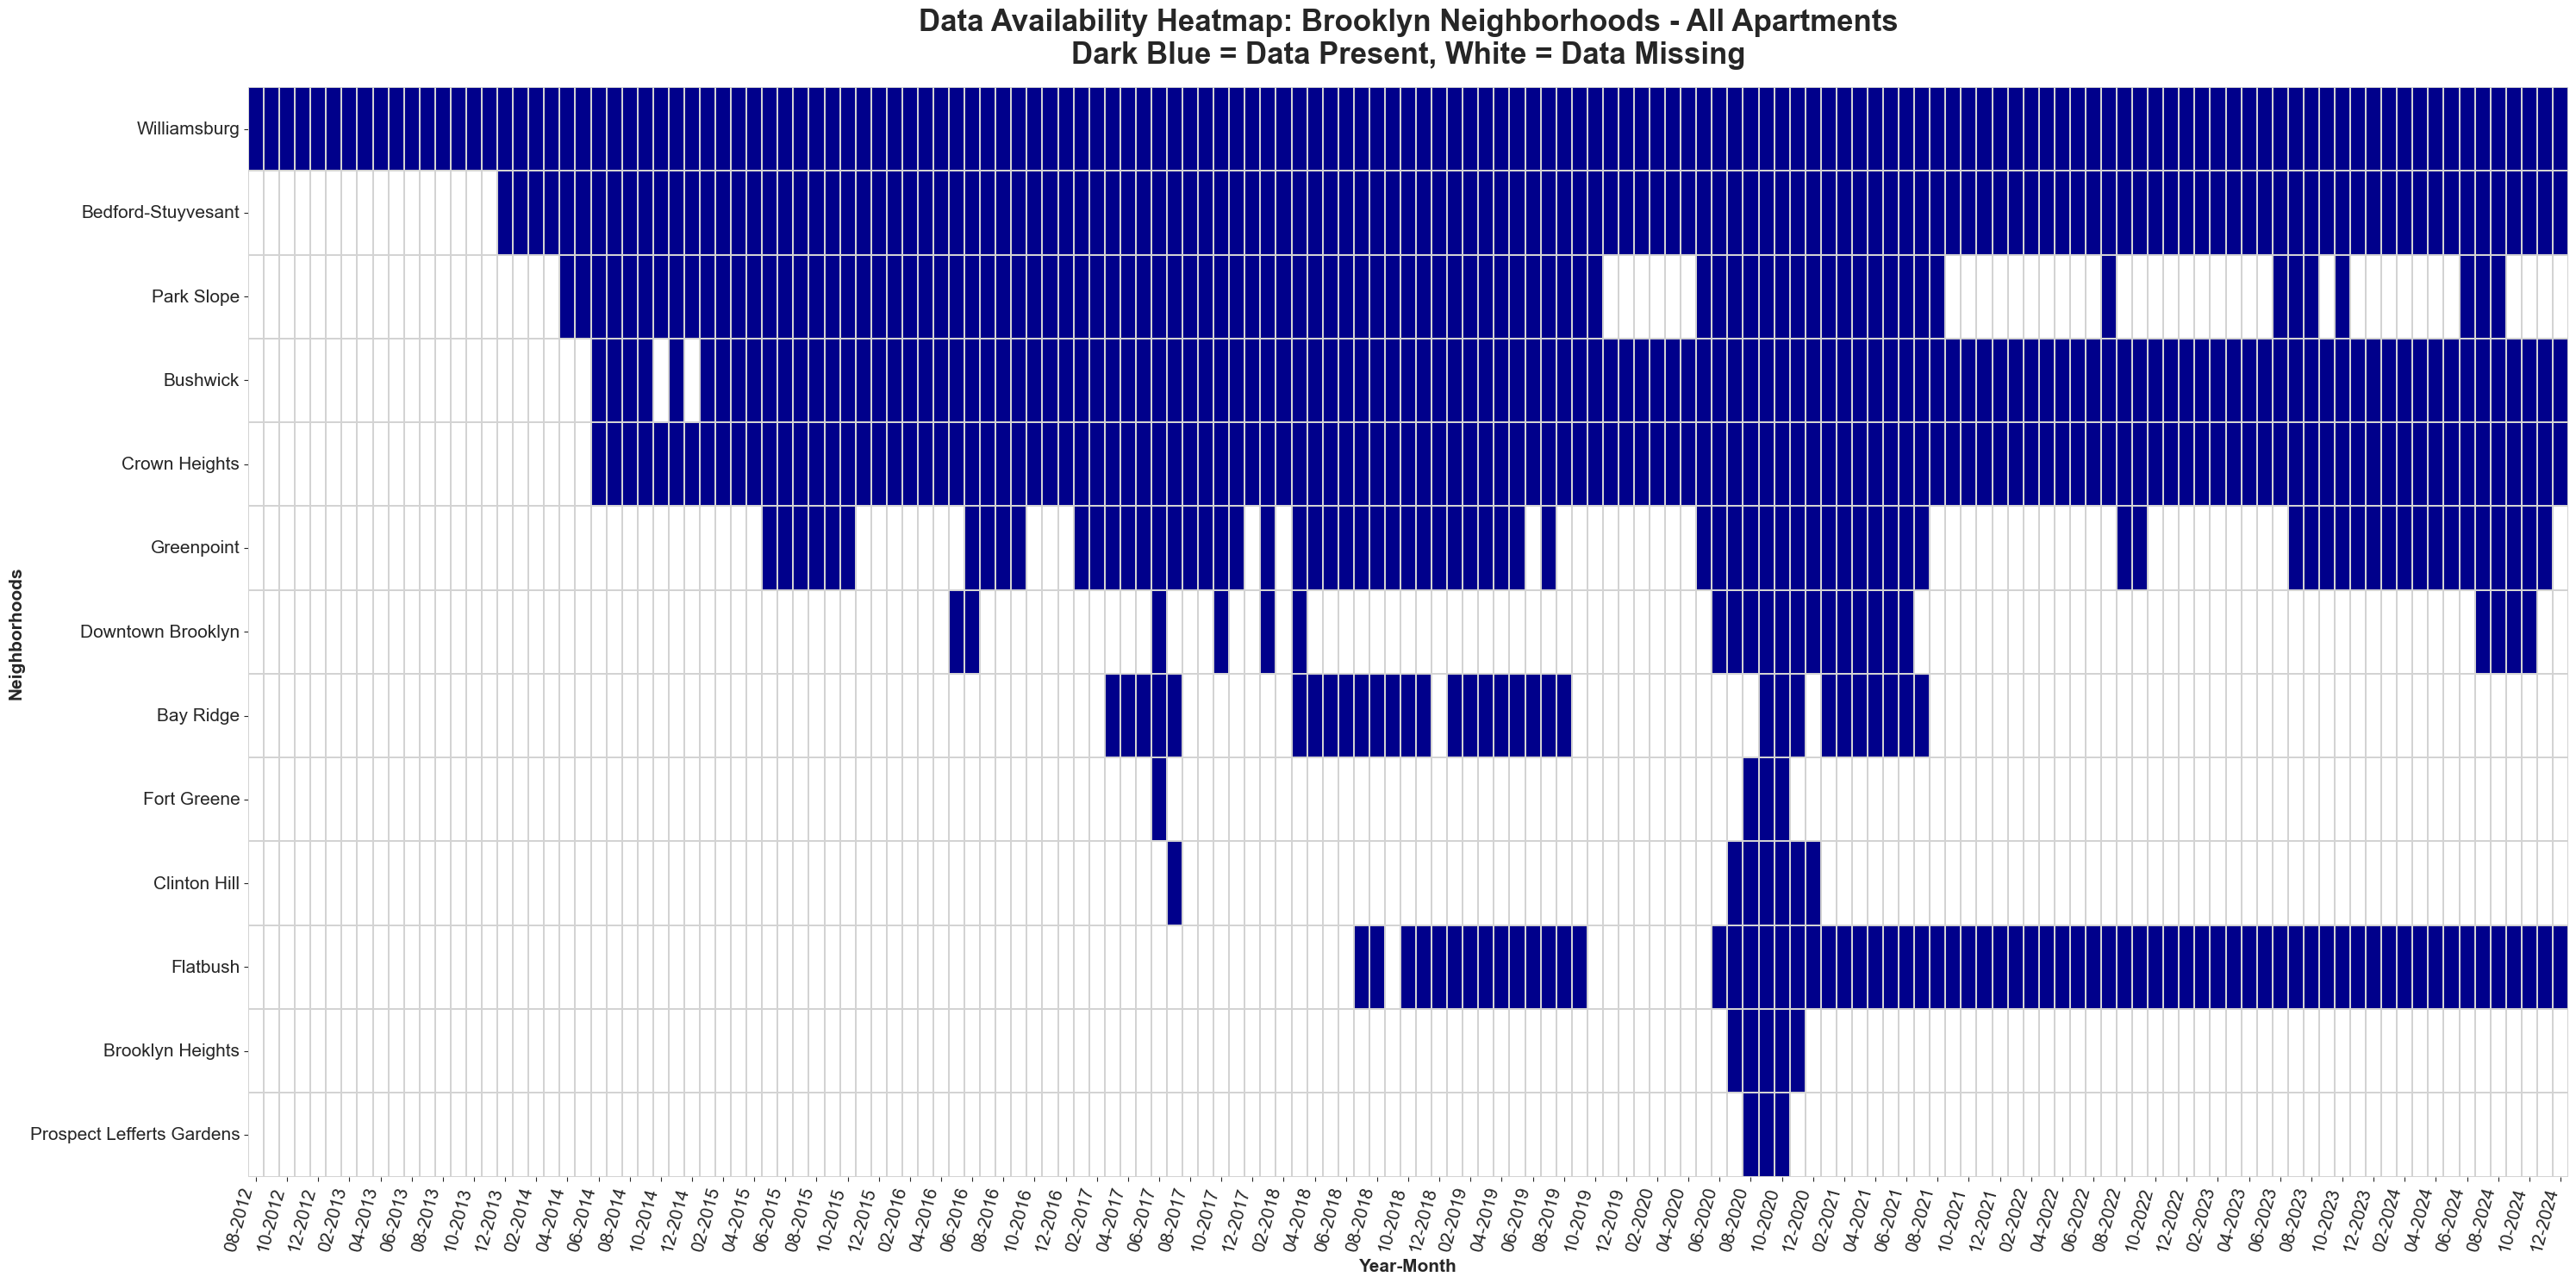

Data Availability Summary for Brooklyn:
Total data points: 1937
Data present: 840.0 (43.4%)
Data missing: 1097.0 (56.6%)
Number of neighborhoods: 13
Number of time periods: 149


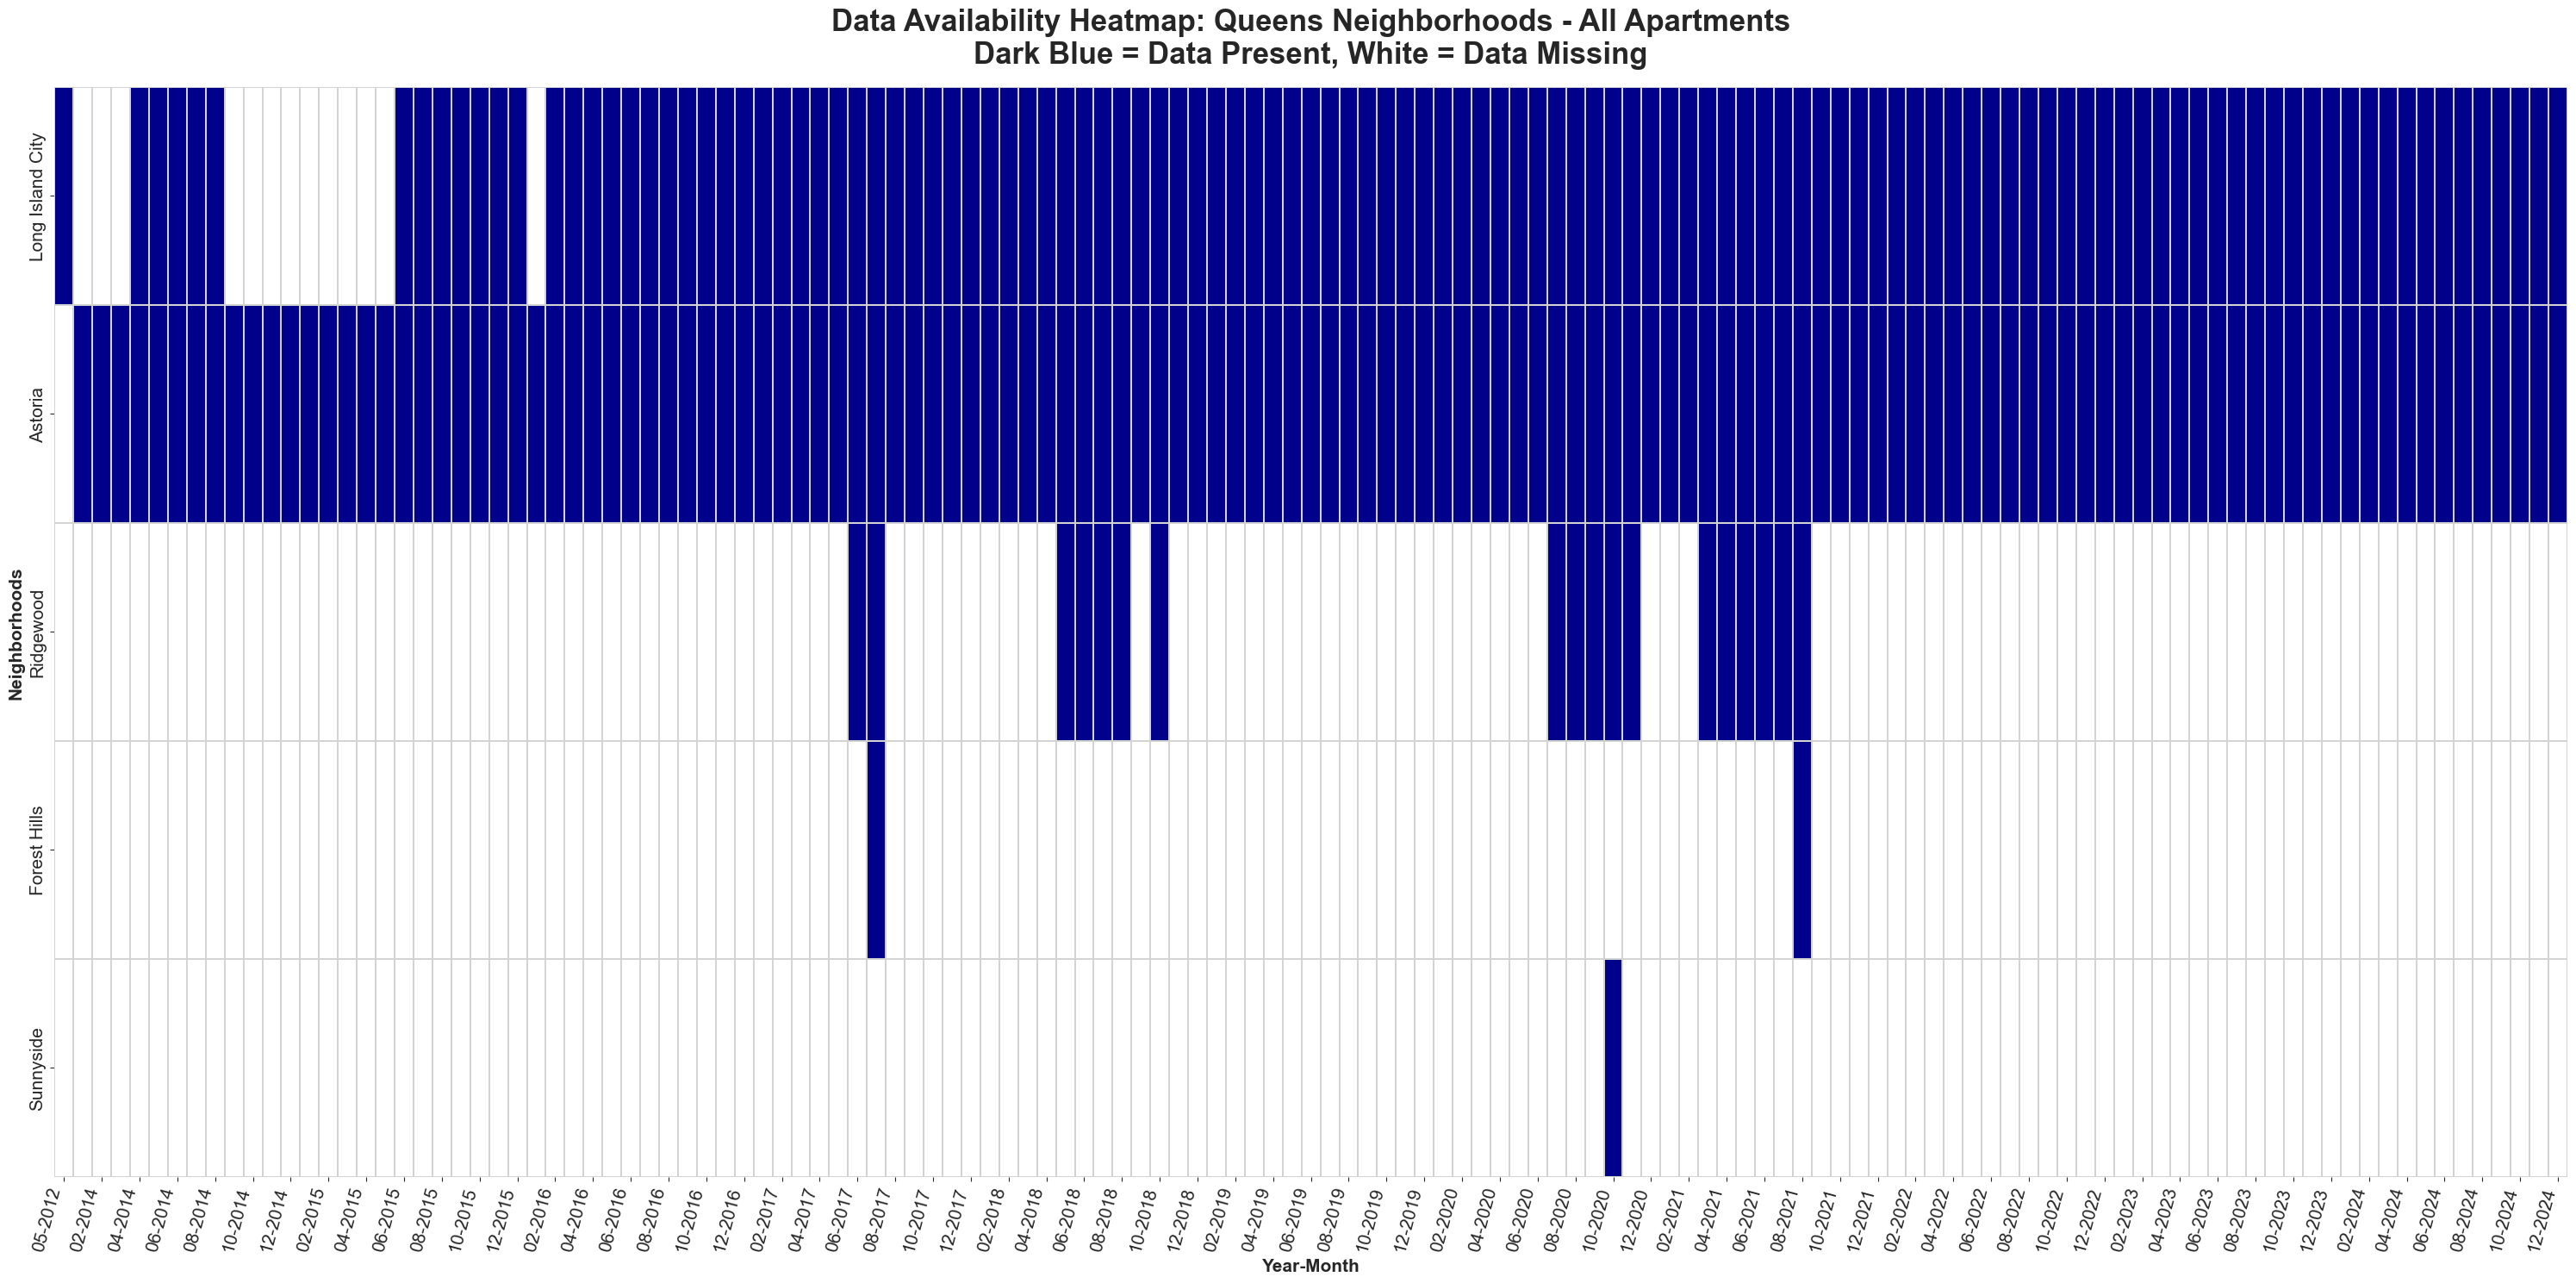

Data Availability Summary for Queens:
Total data points: 665
Data present: 273.0 (41.1%)
Data missing: 392.0 (58.9%)
Number of neighborhoods: 5
Number of time periods: 133


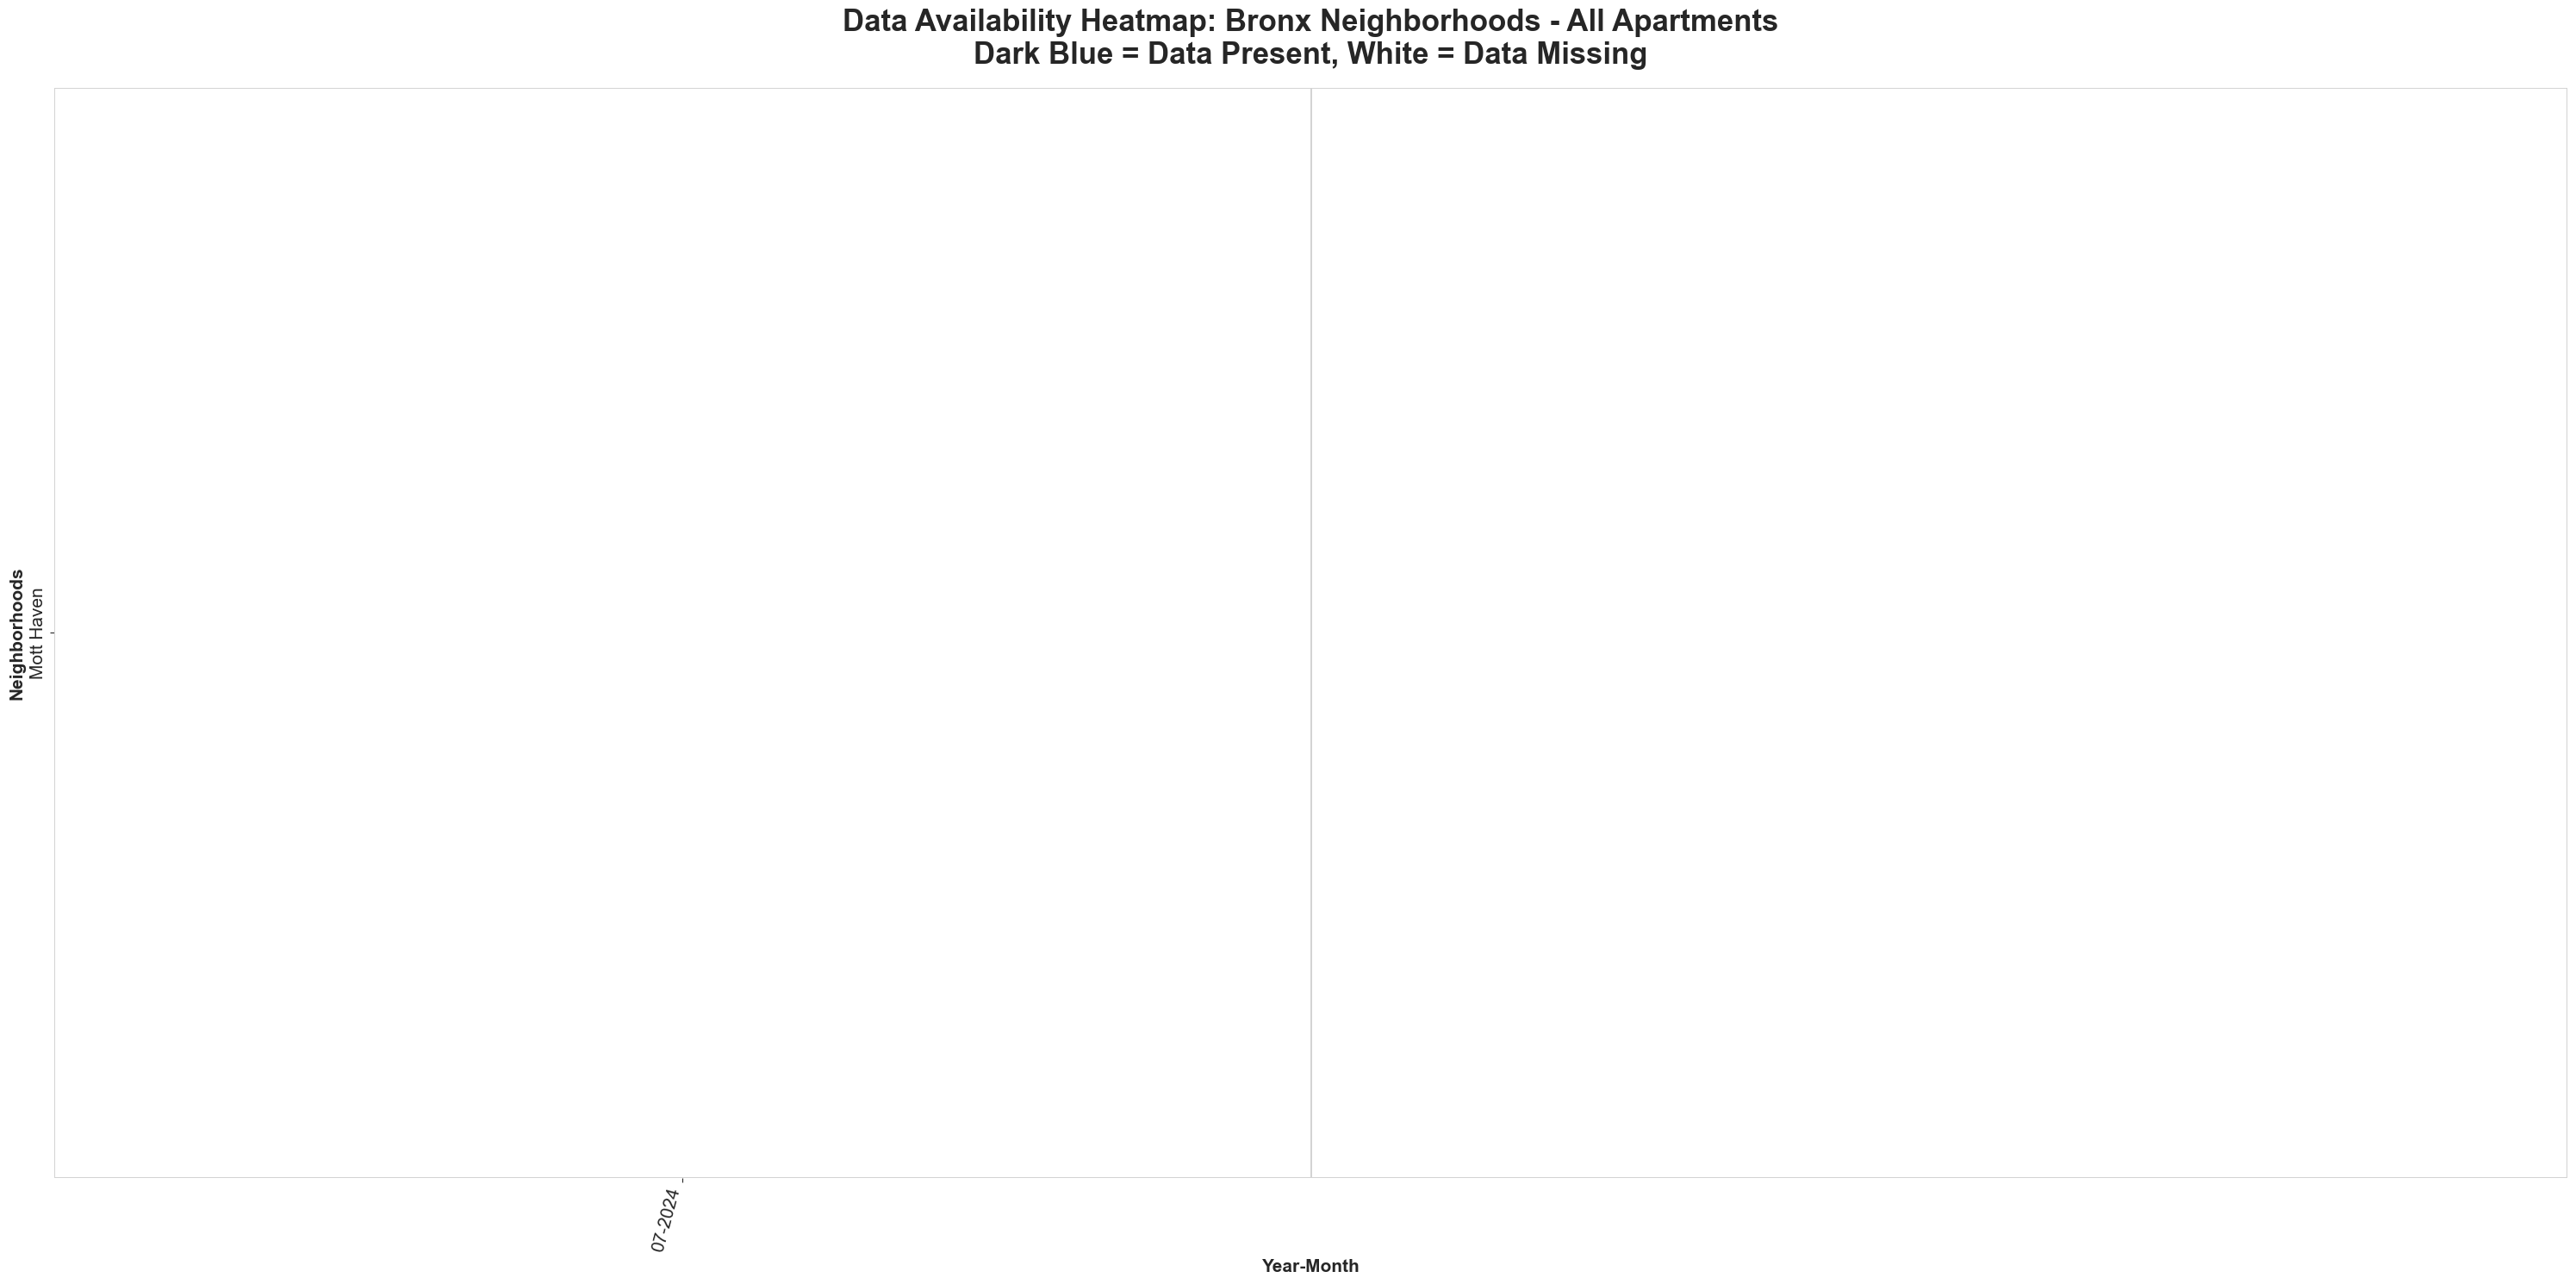

Data Availability Summary for Bronx:
Total data points: 2
Data present: 2.0 (100.0%)
Data missing: 0.0 (0.0%)
Number of neighborhoods: 1
Number of time periods: 2


In [ ]:
for borough in boroughs:
        create_data_availability_heatmap(rent_df, borough, apt_type='all', subtitle='All Apartments')

#### 1-Bedroom Apartments

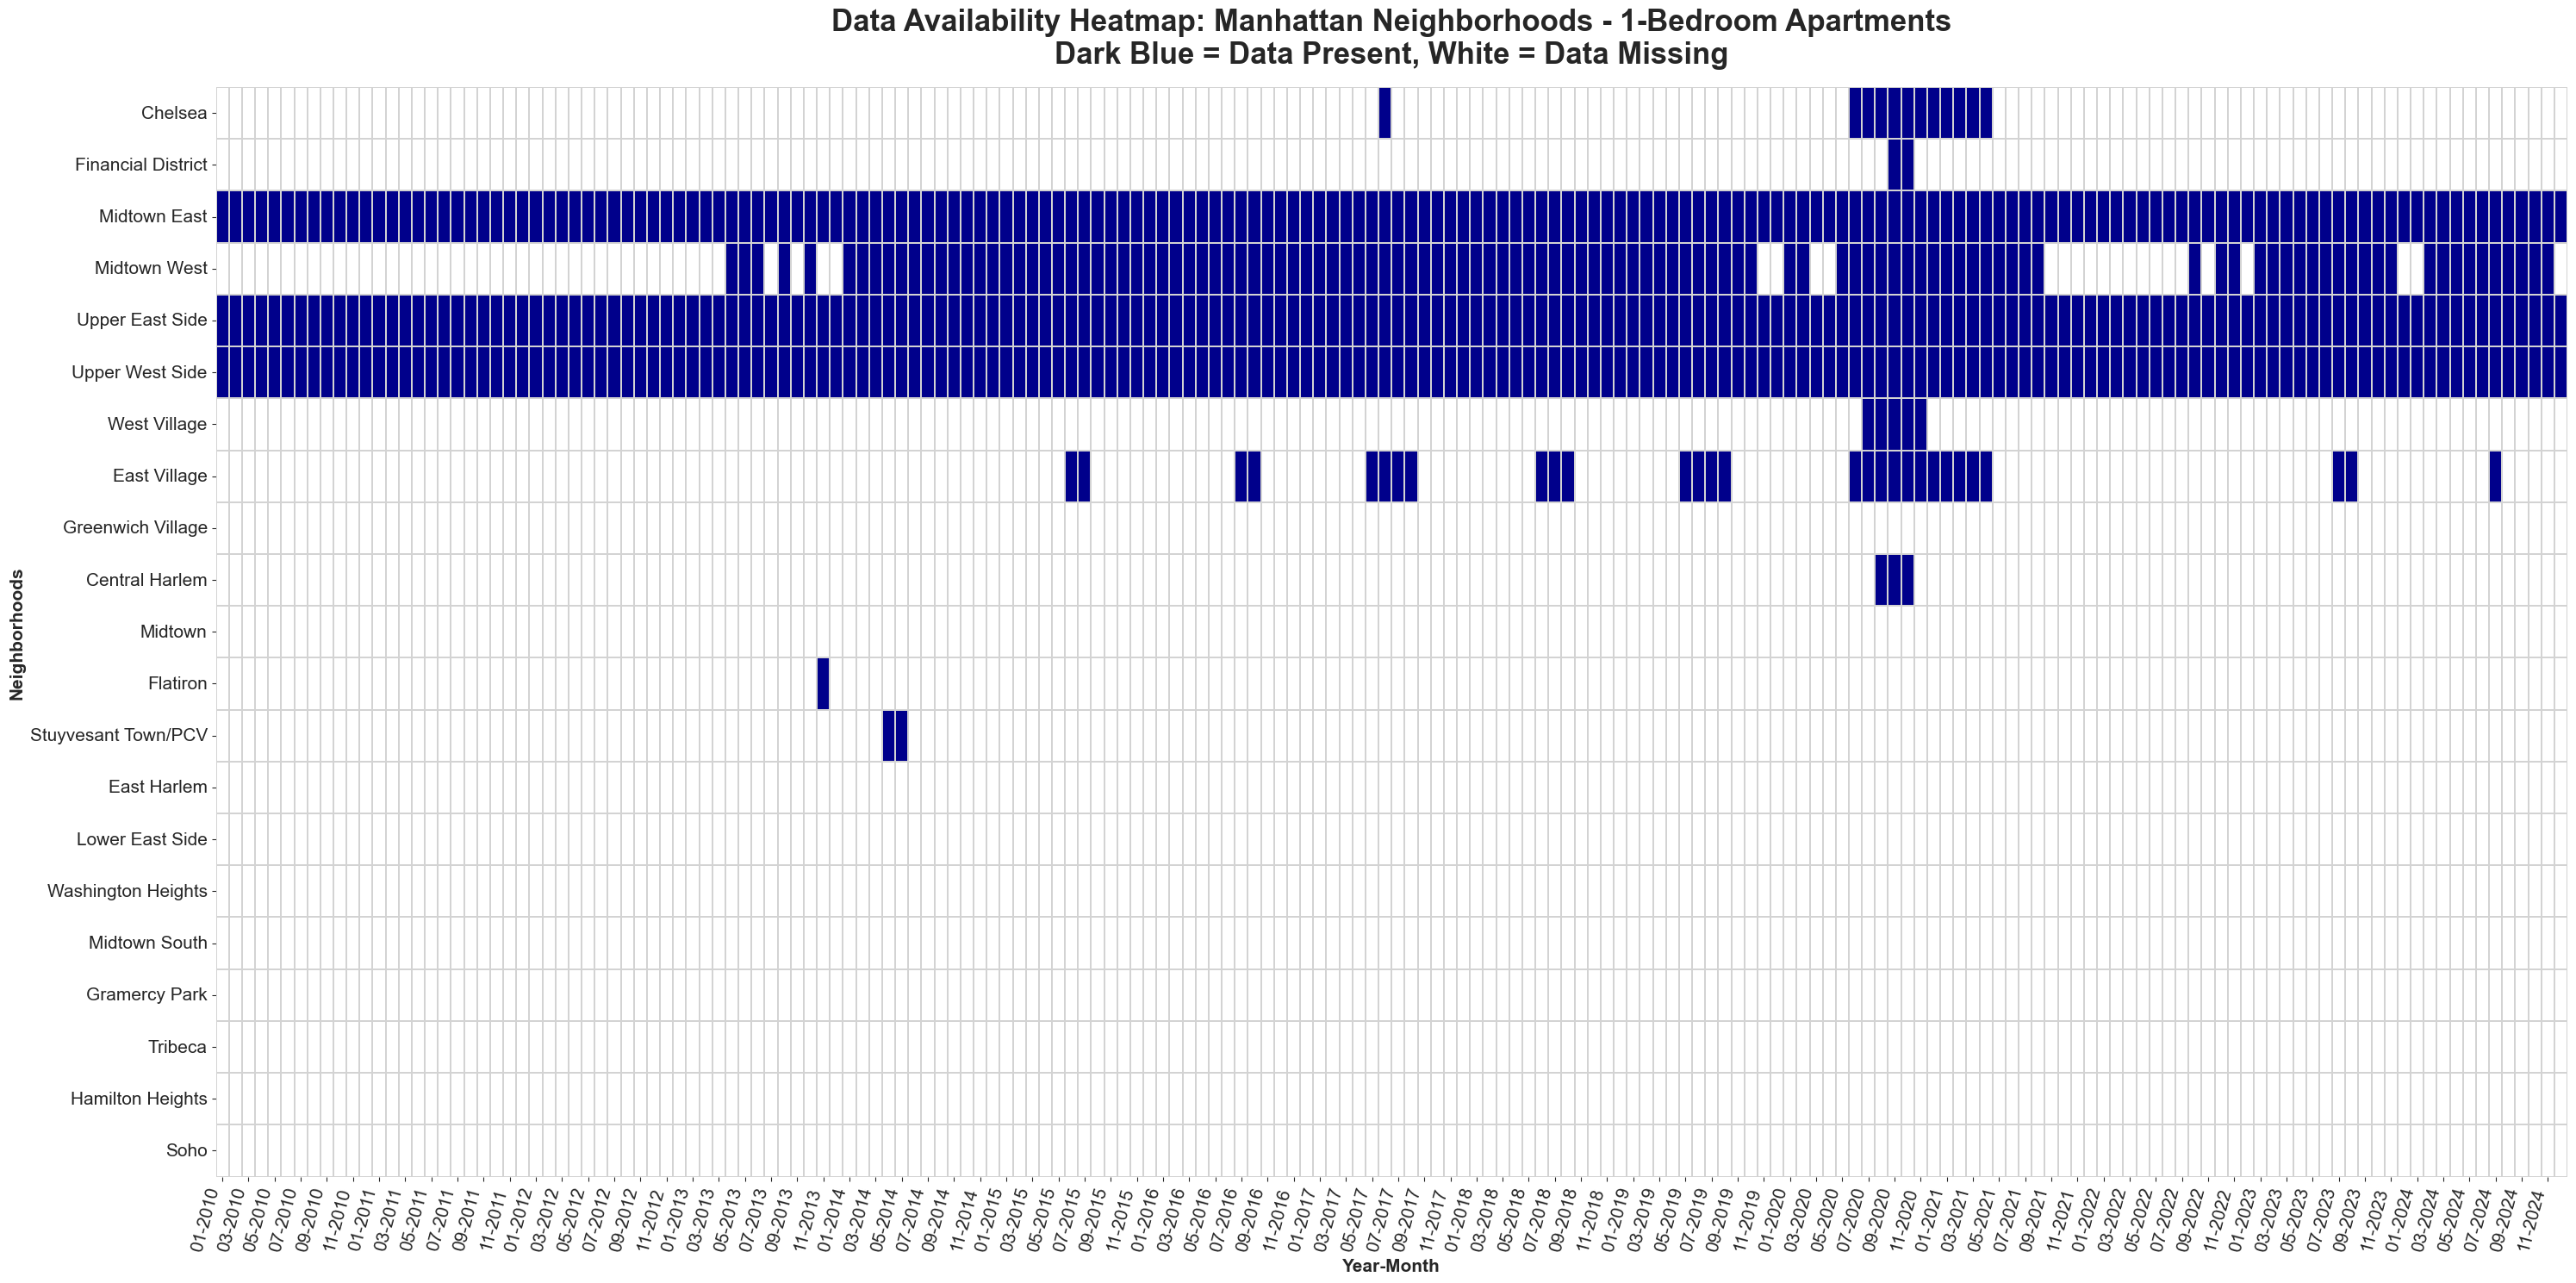

Data Availability Summary for Manhattan:
Total data points: 3780
Data present: 711.0 (18.8%)
Data missing: 3069.0 (81.2%)
Number of neighborhoods: 21
Number of time periods: 180


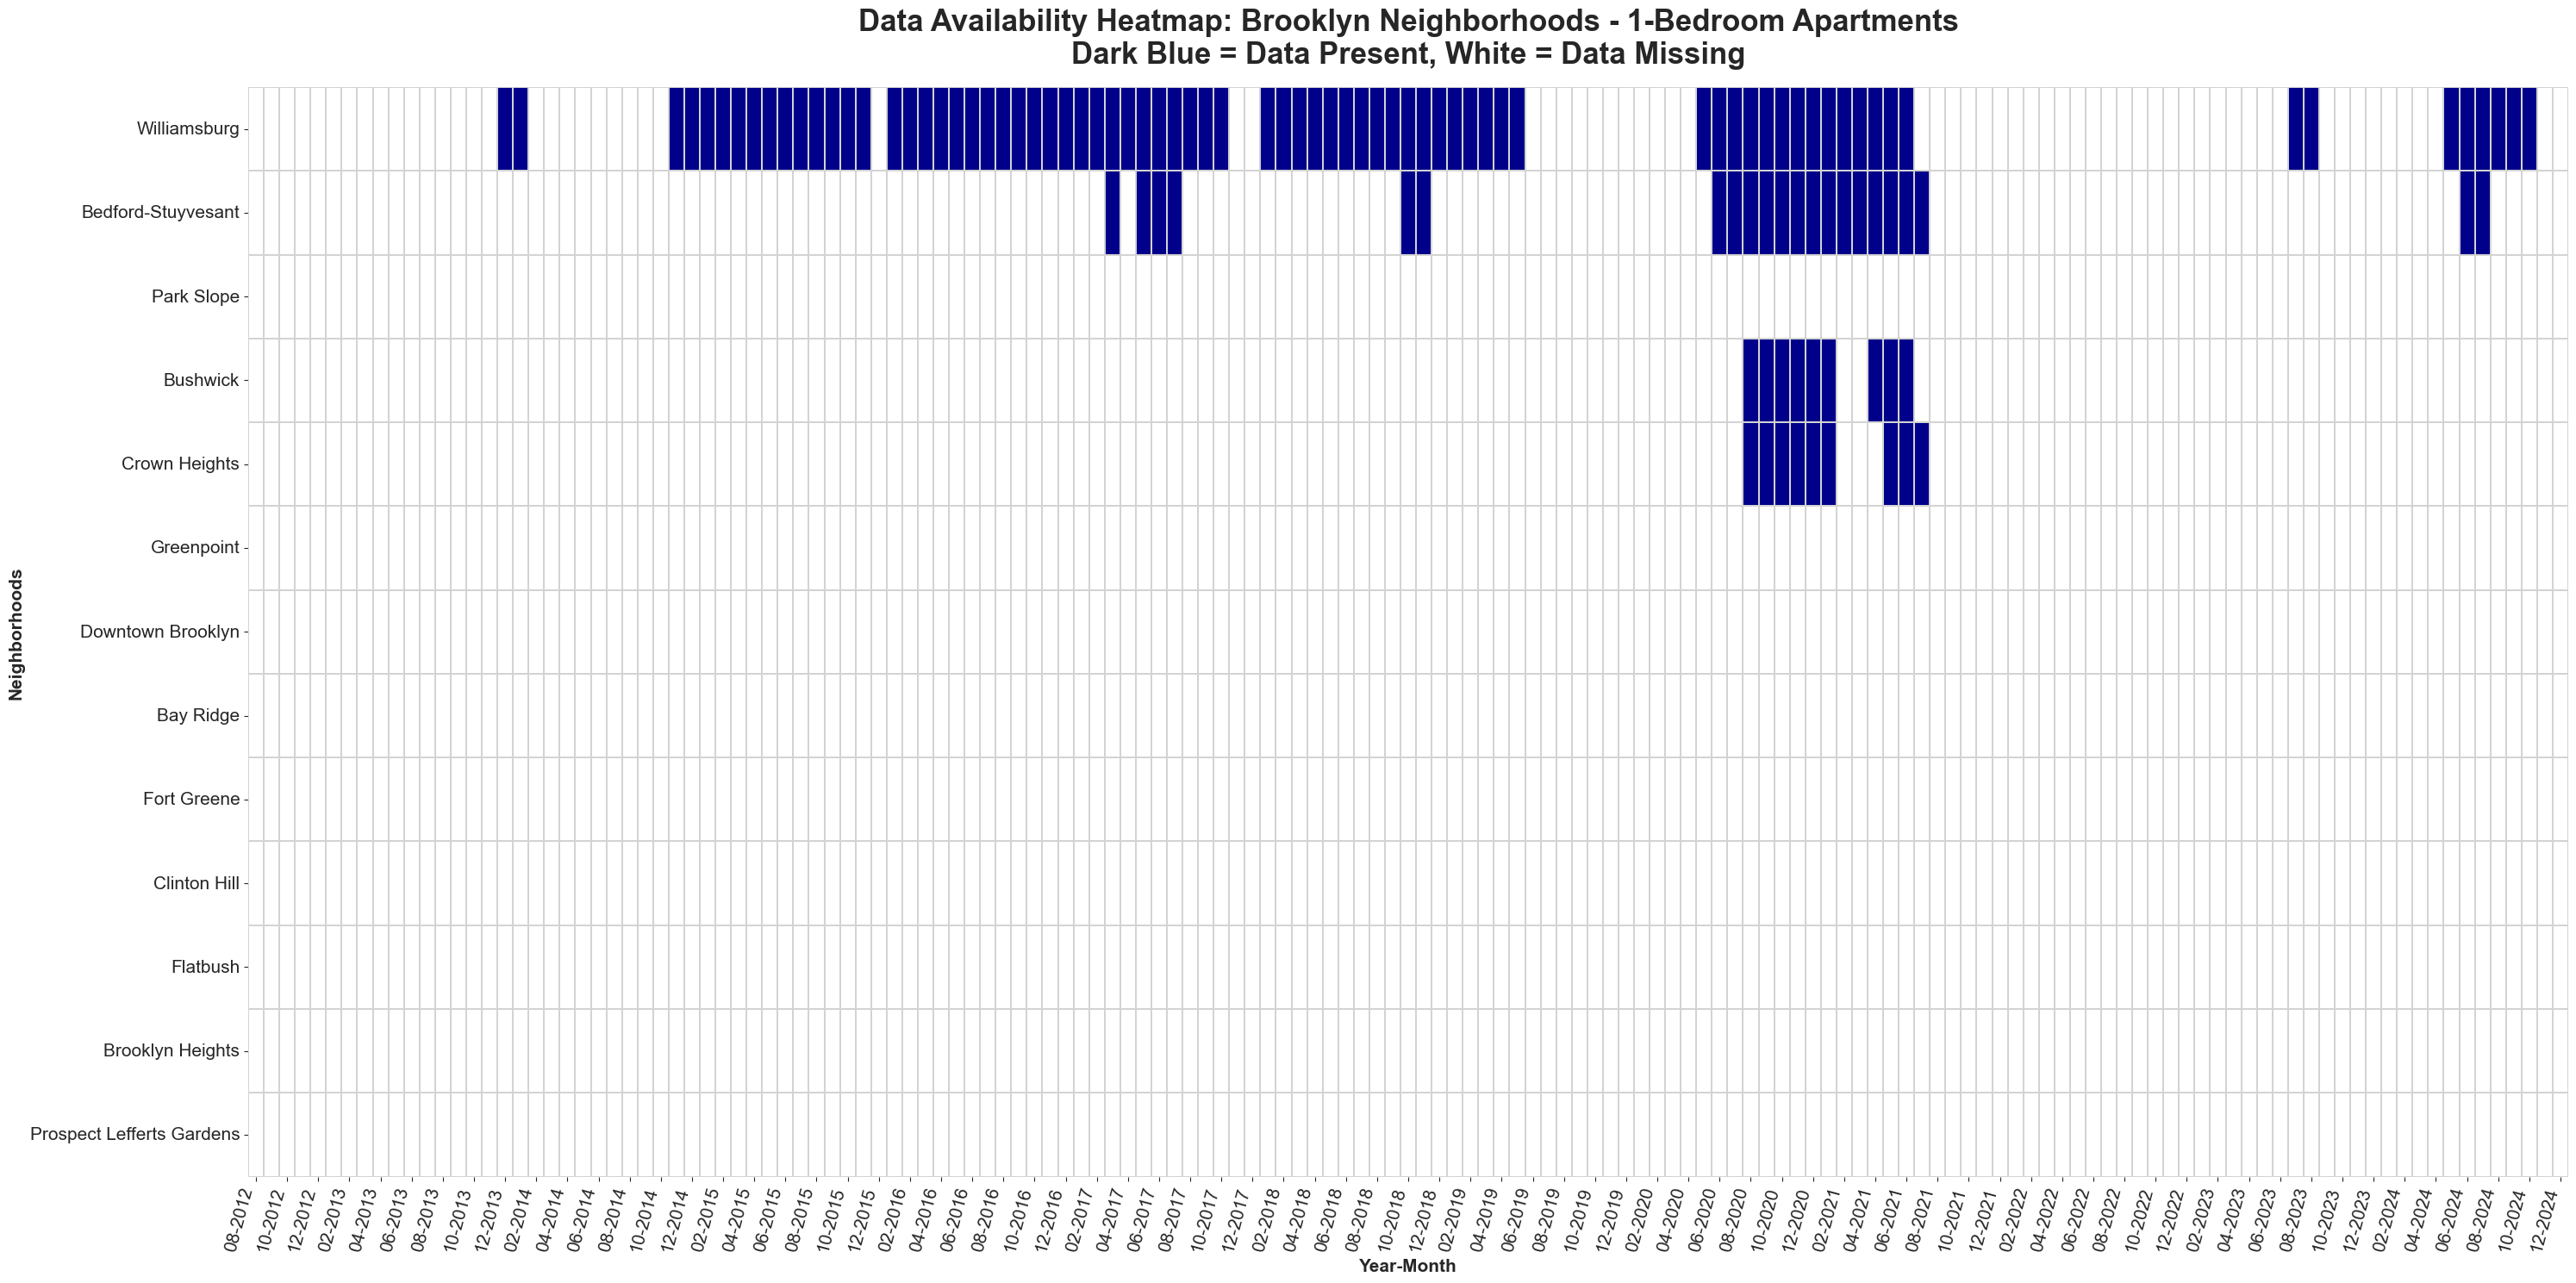

Data Availability Summary for Brooklyn:
Total data points: 1937
Data present: 116.0 (6.0%)
Data missing: 1821.0 (94.0%)
Number of neighborhoods: 13
Number of time periods: 149


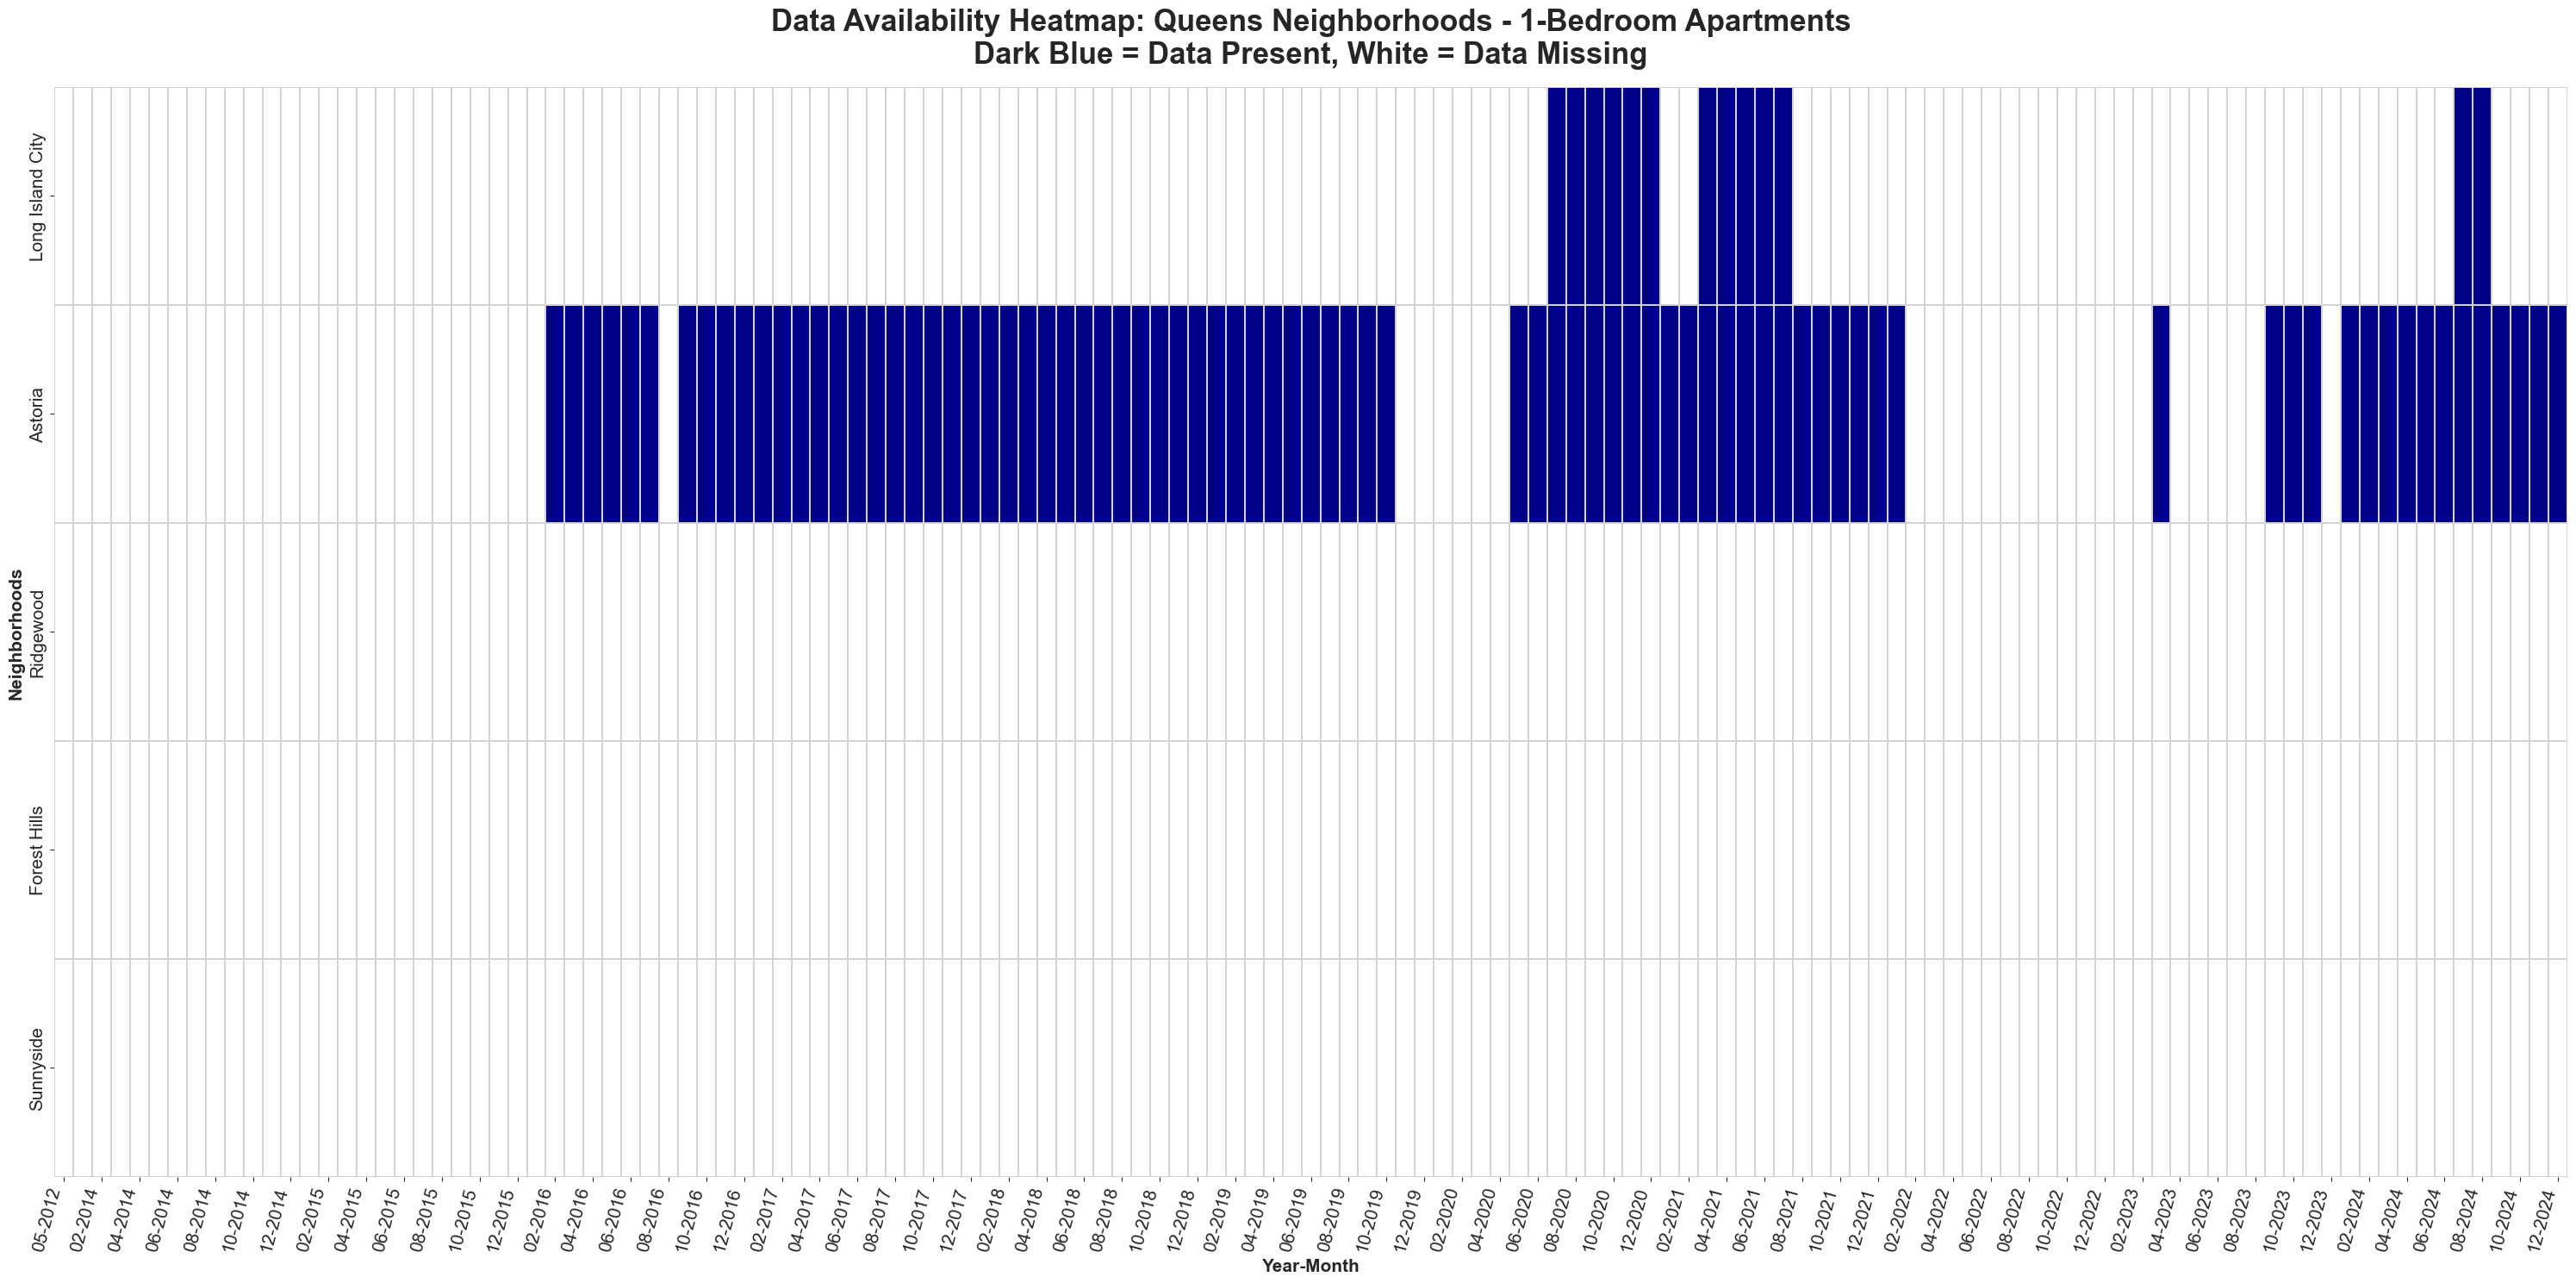

Data Availability Summary for Queens:
Total data points: 665
Data present: 94.0 (14.1%)
Data missing: 571.0 (85.9%)
Number of neighborhoods: 5
Number of time periods: 133


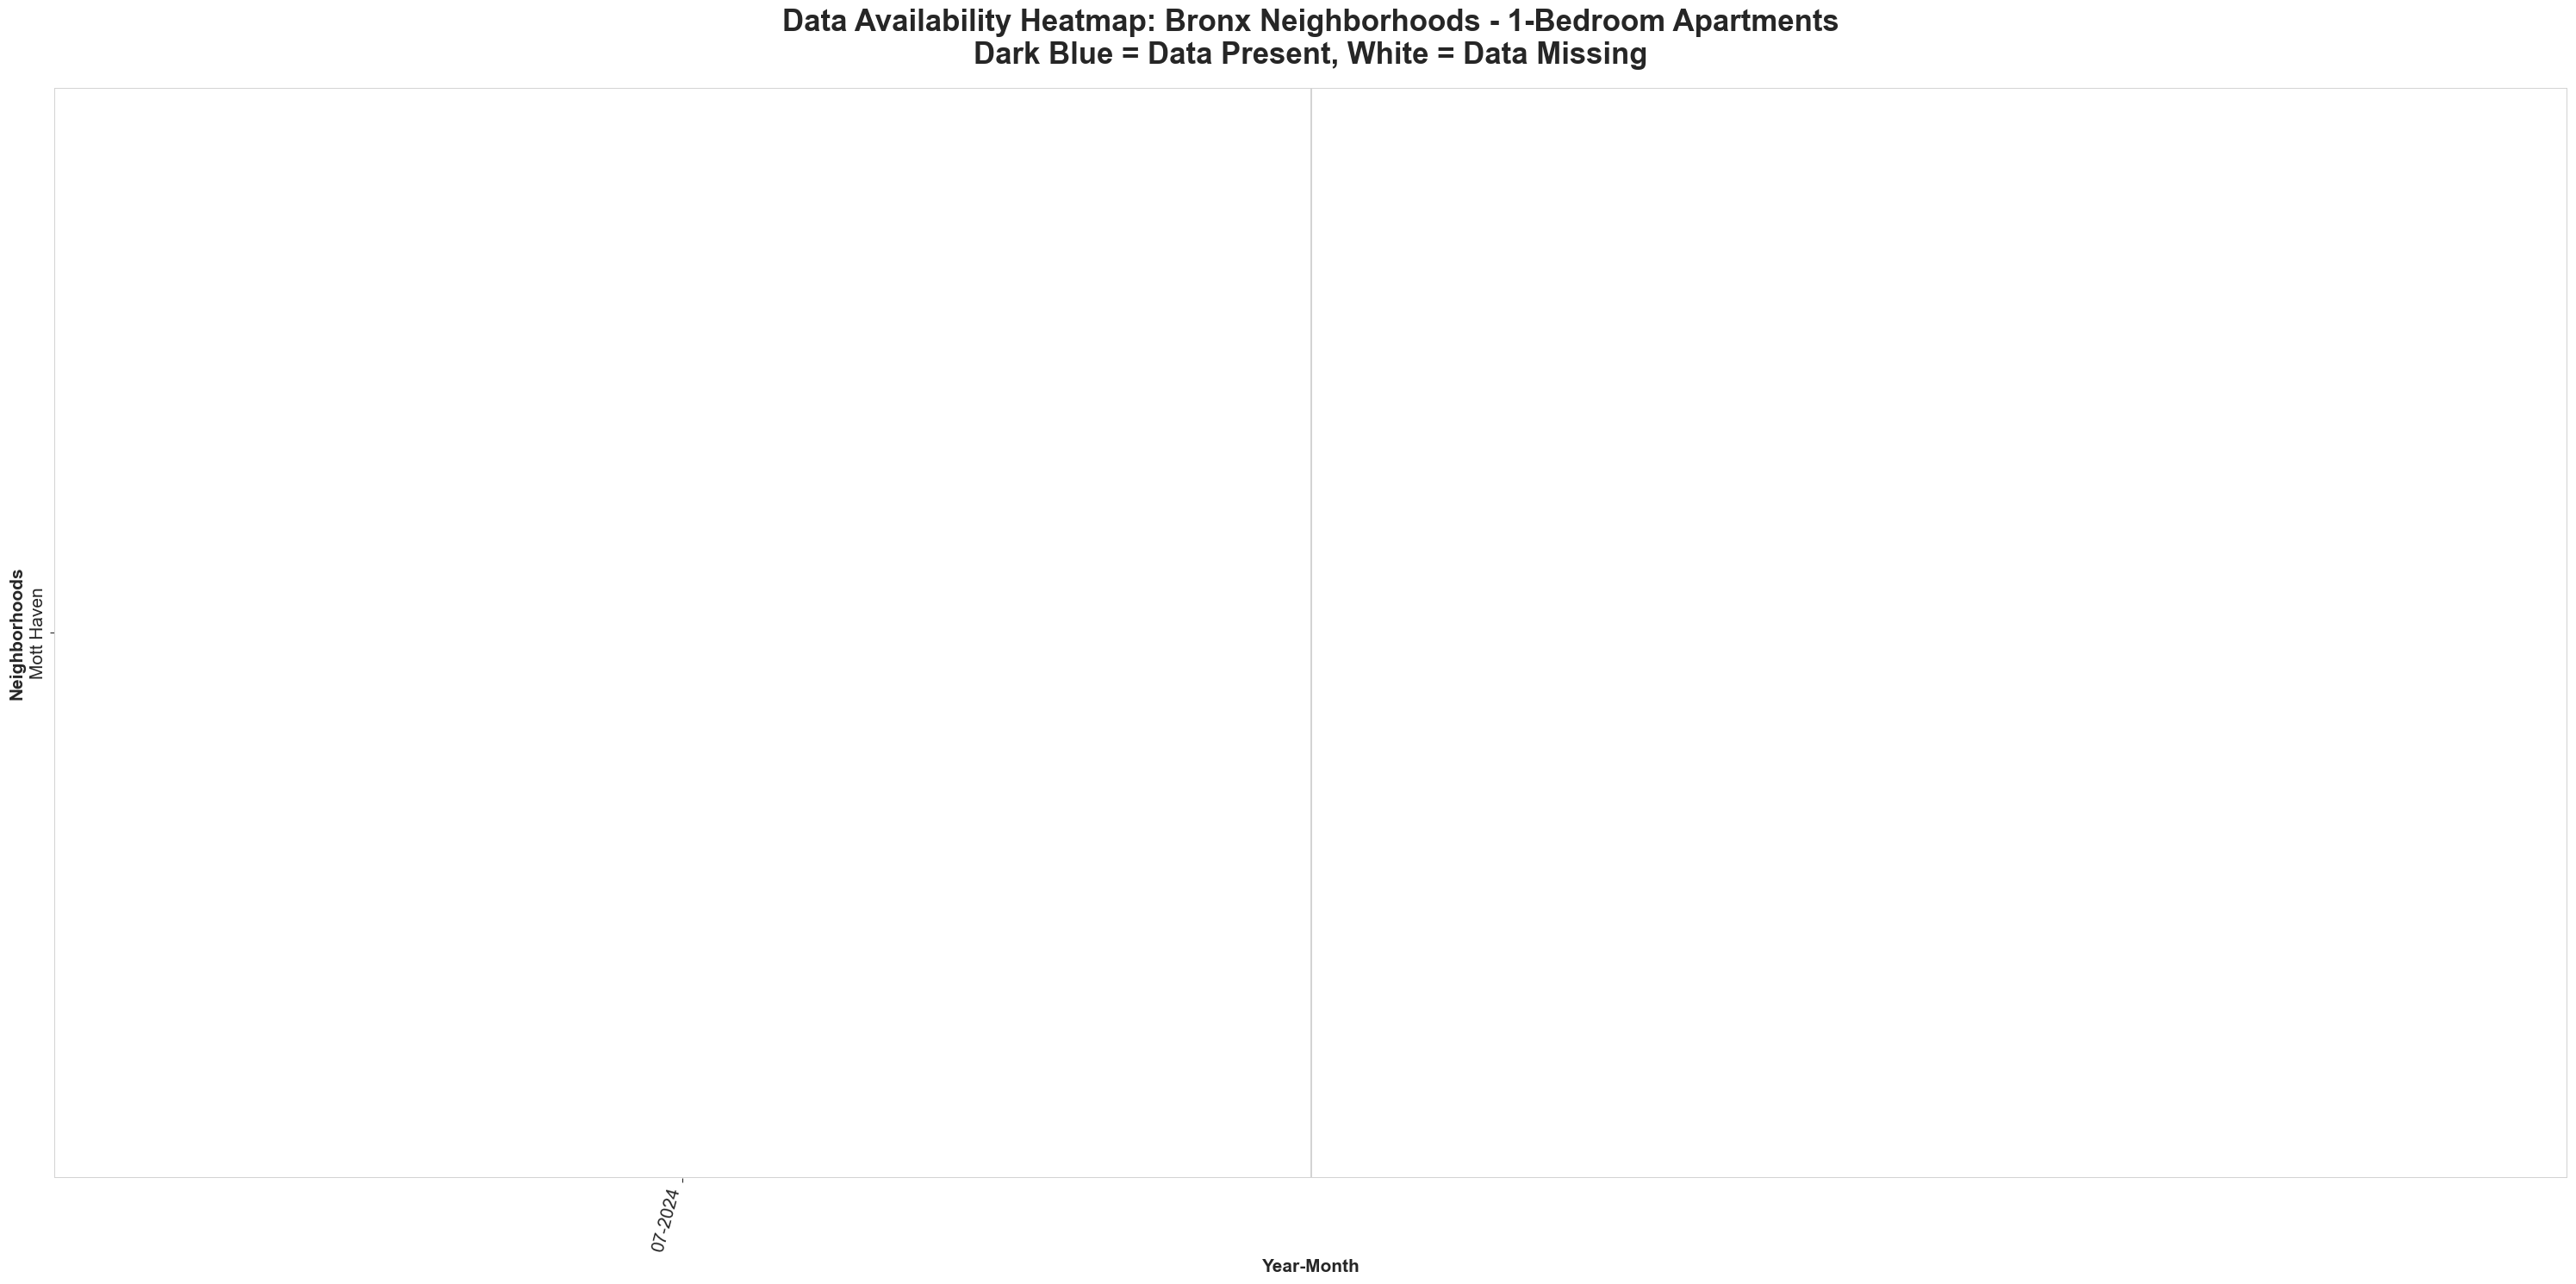

Data Availability Summary for Bronx:
Total data points: 2
Data present: 0.0 (0.0%)
Data missing: 2.0 (100.0%)
Number of neighborhoods: 1
Number of time periods: 2


In [ ]:
for borough in boroughs:
    create_data_availability_heatmap(rent_df, borough, apt_type='1bdr', subtitle='1-Bedroom Apartments')

#### 3-Bedroom Apartments

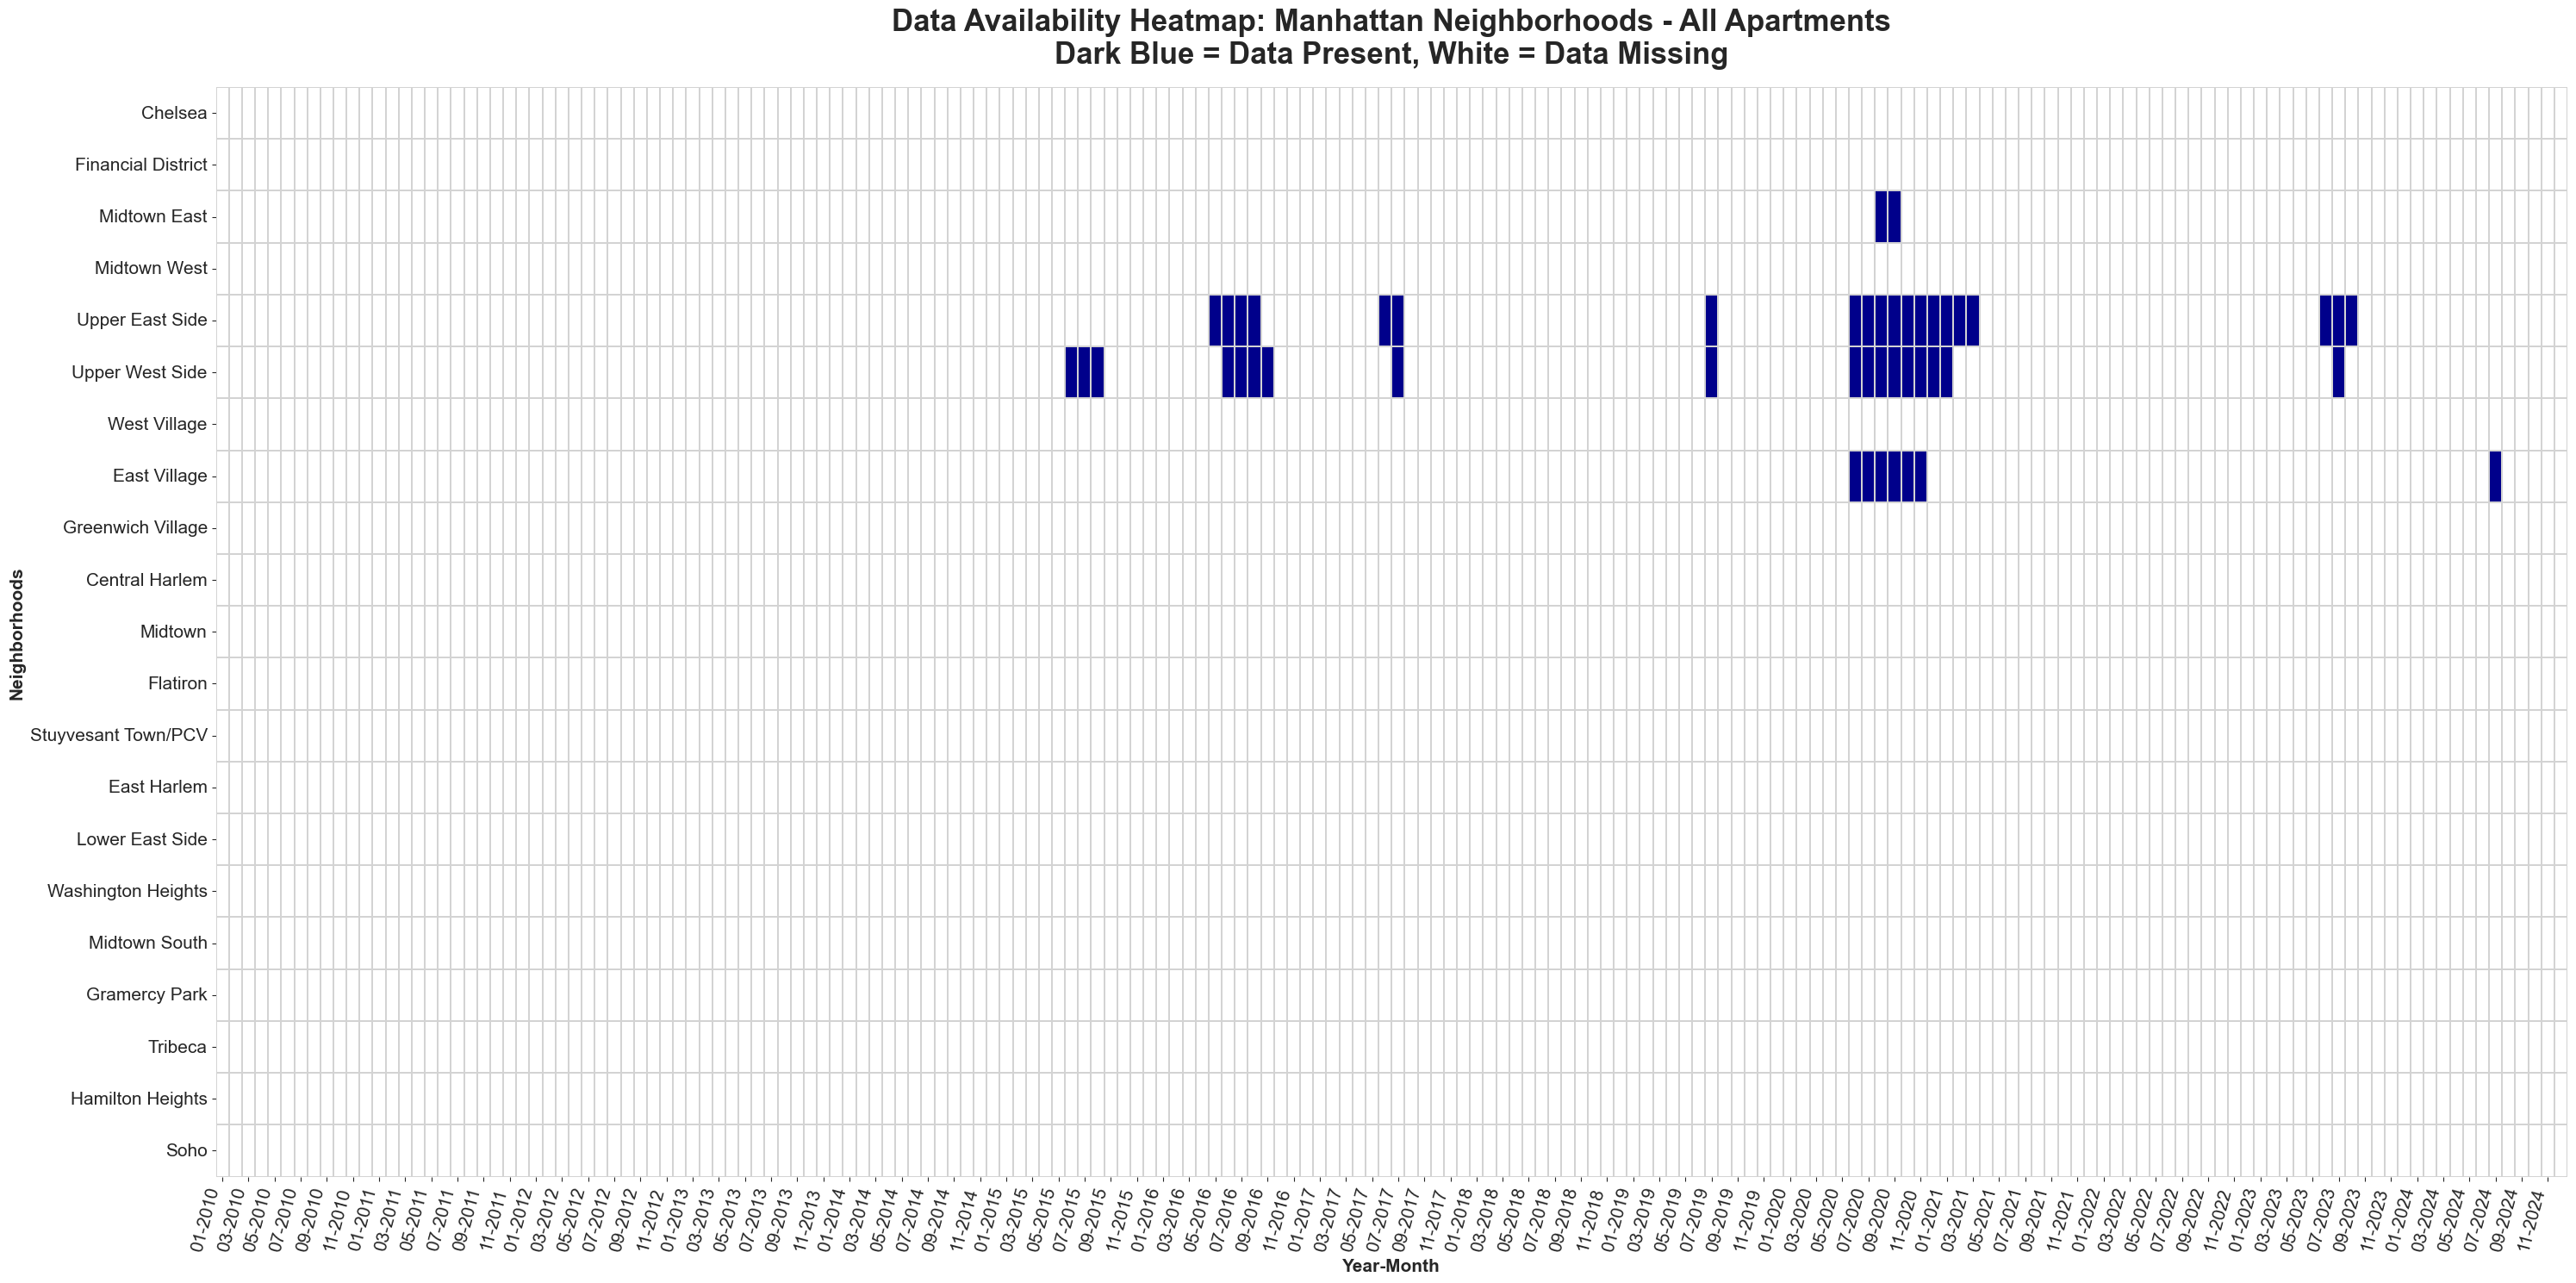

Data Availability Summary for Manhattan:
Total data points: 3780
Data present: 47.0 (1.2%)
Data missing: 3733.0 (98.8%)
Number of neighborhoods: 21
Number of time periods: 180


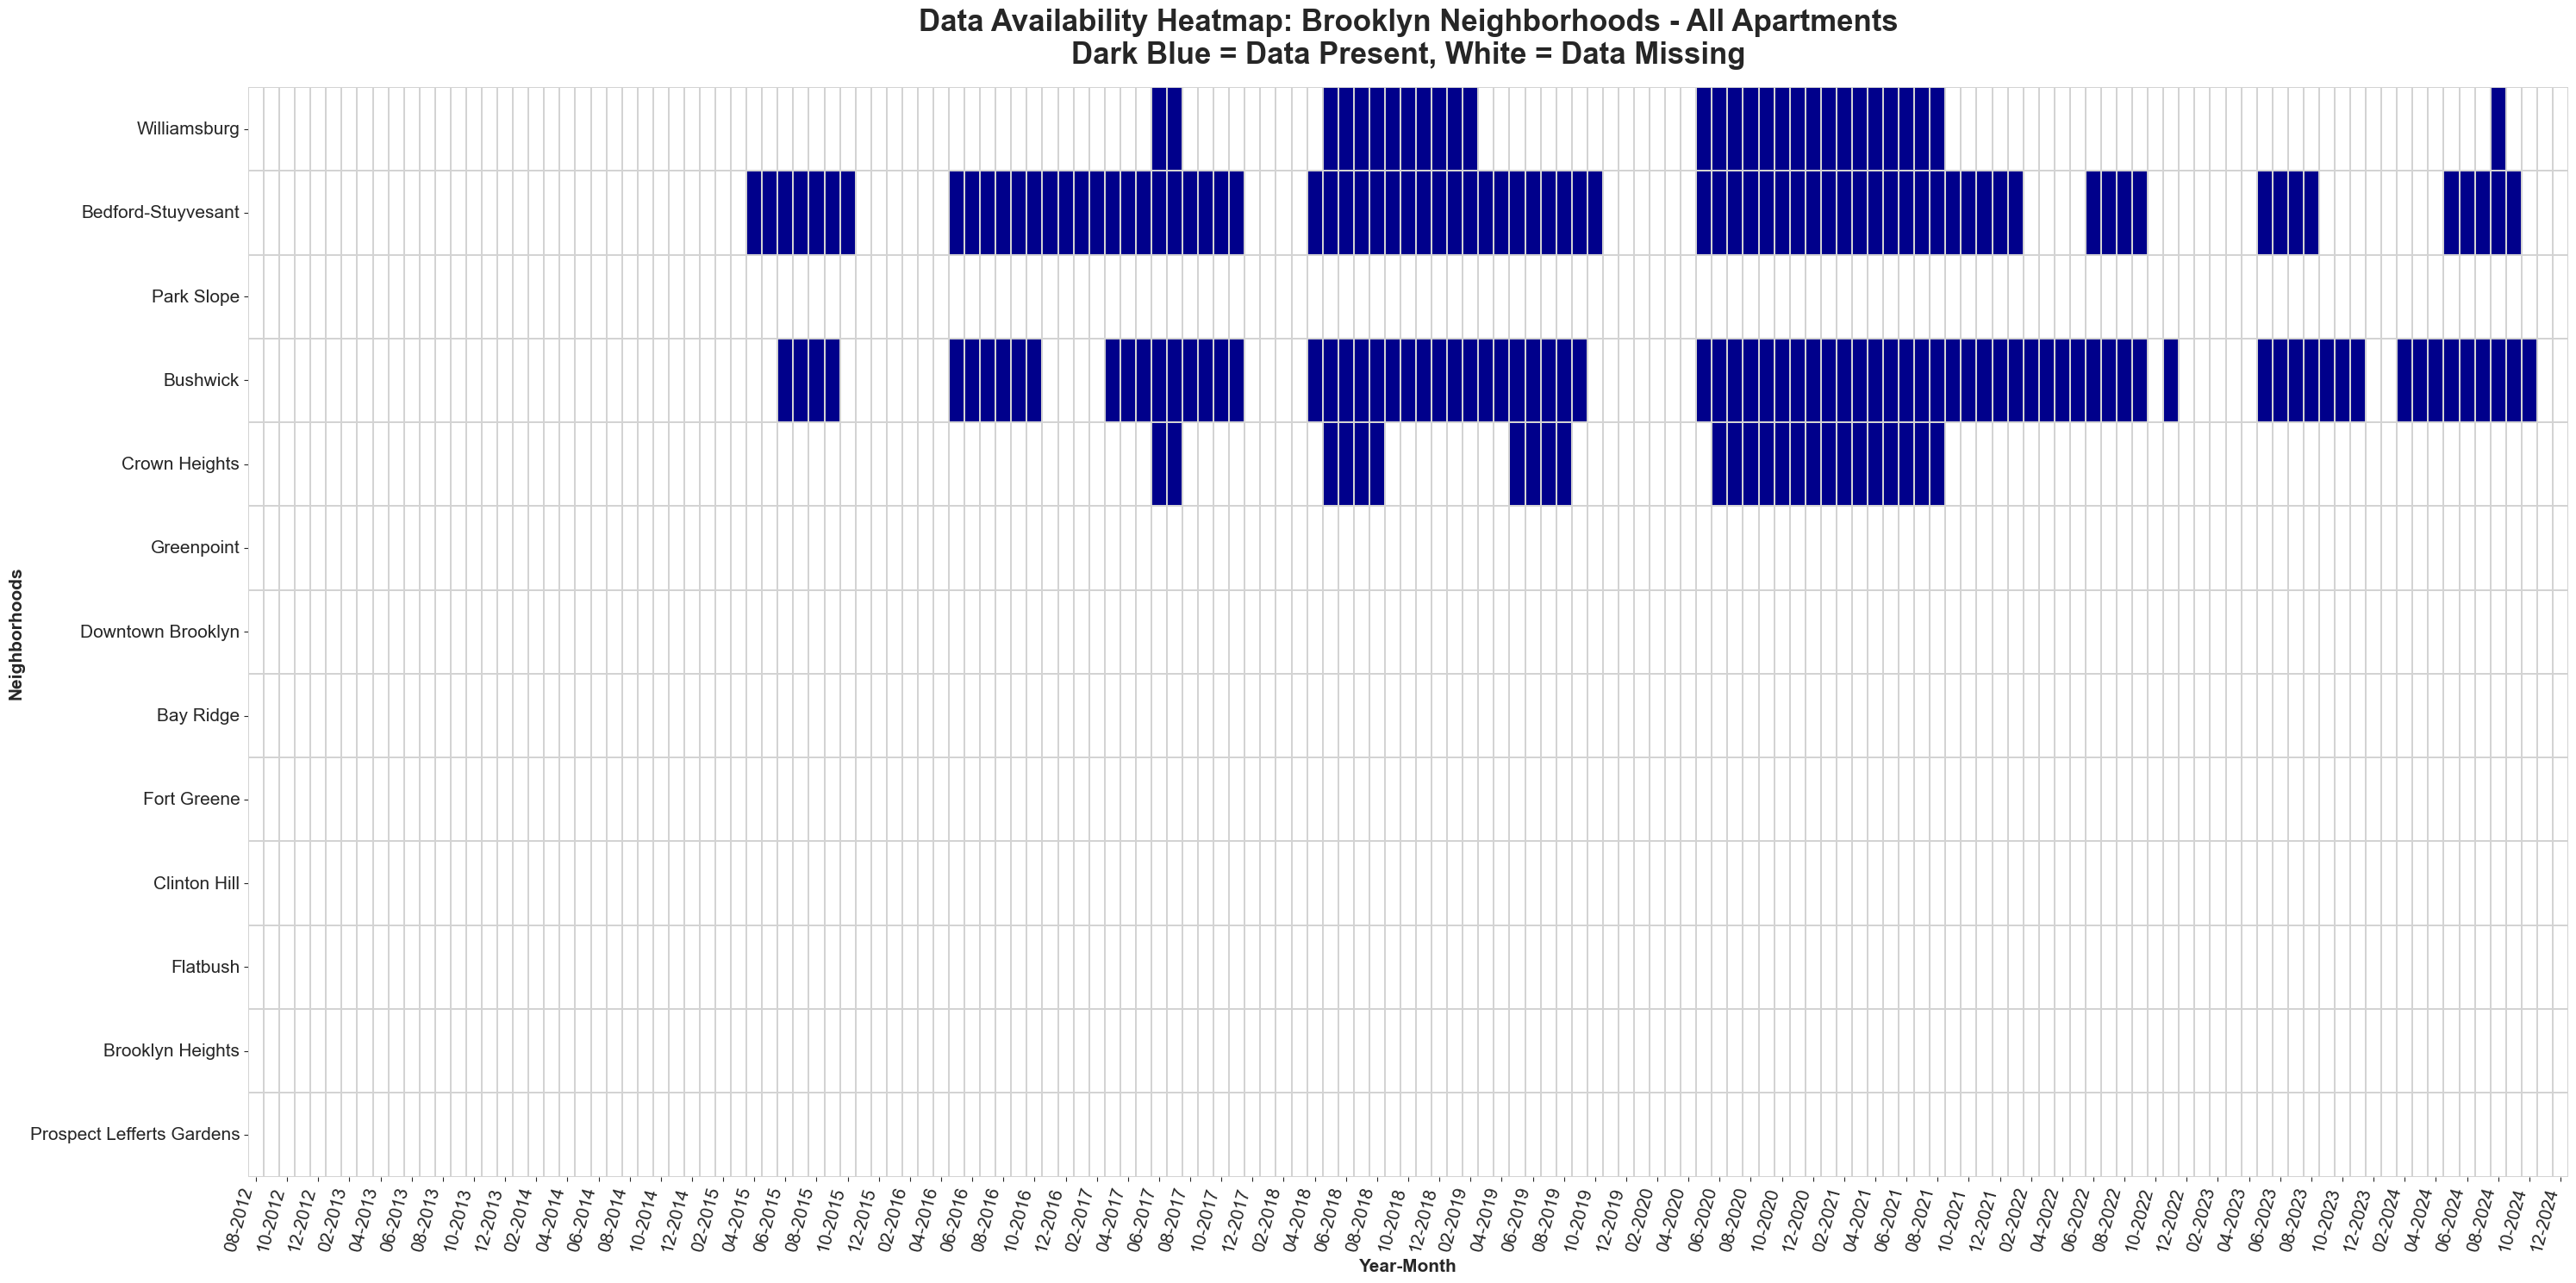

Data Availability Summary for Brooklyn:
Total data points: 1937
Data present: 216.0 (11.2%)
Data missing: 1721.0 (88.8%)
Number of neighborhoods: 13
Number of time periods: 149


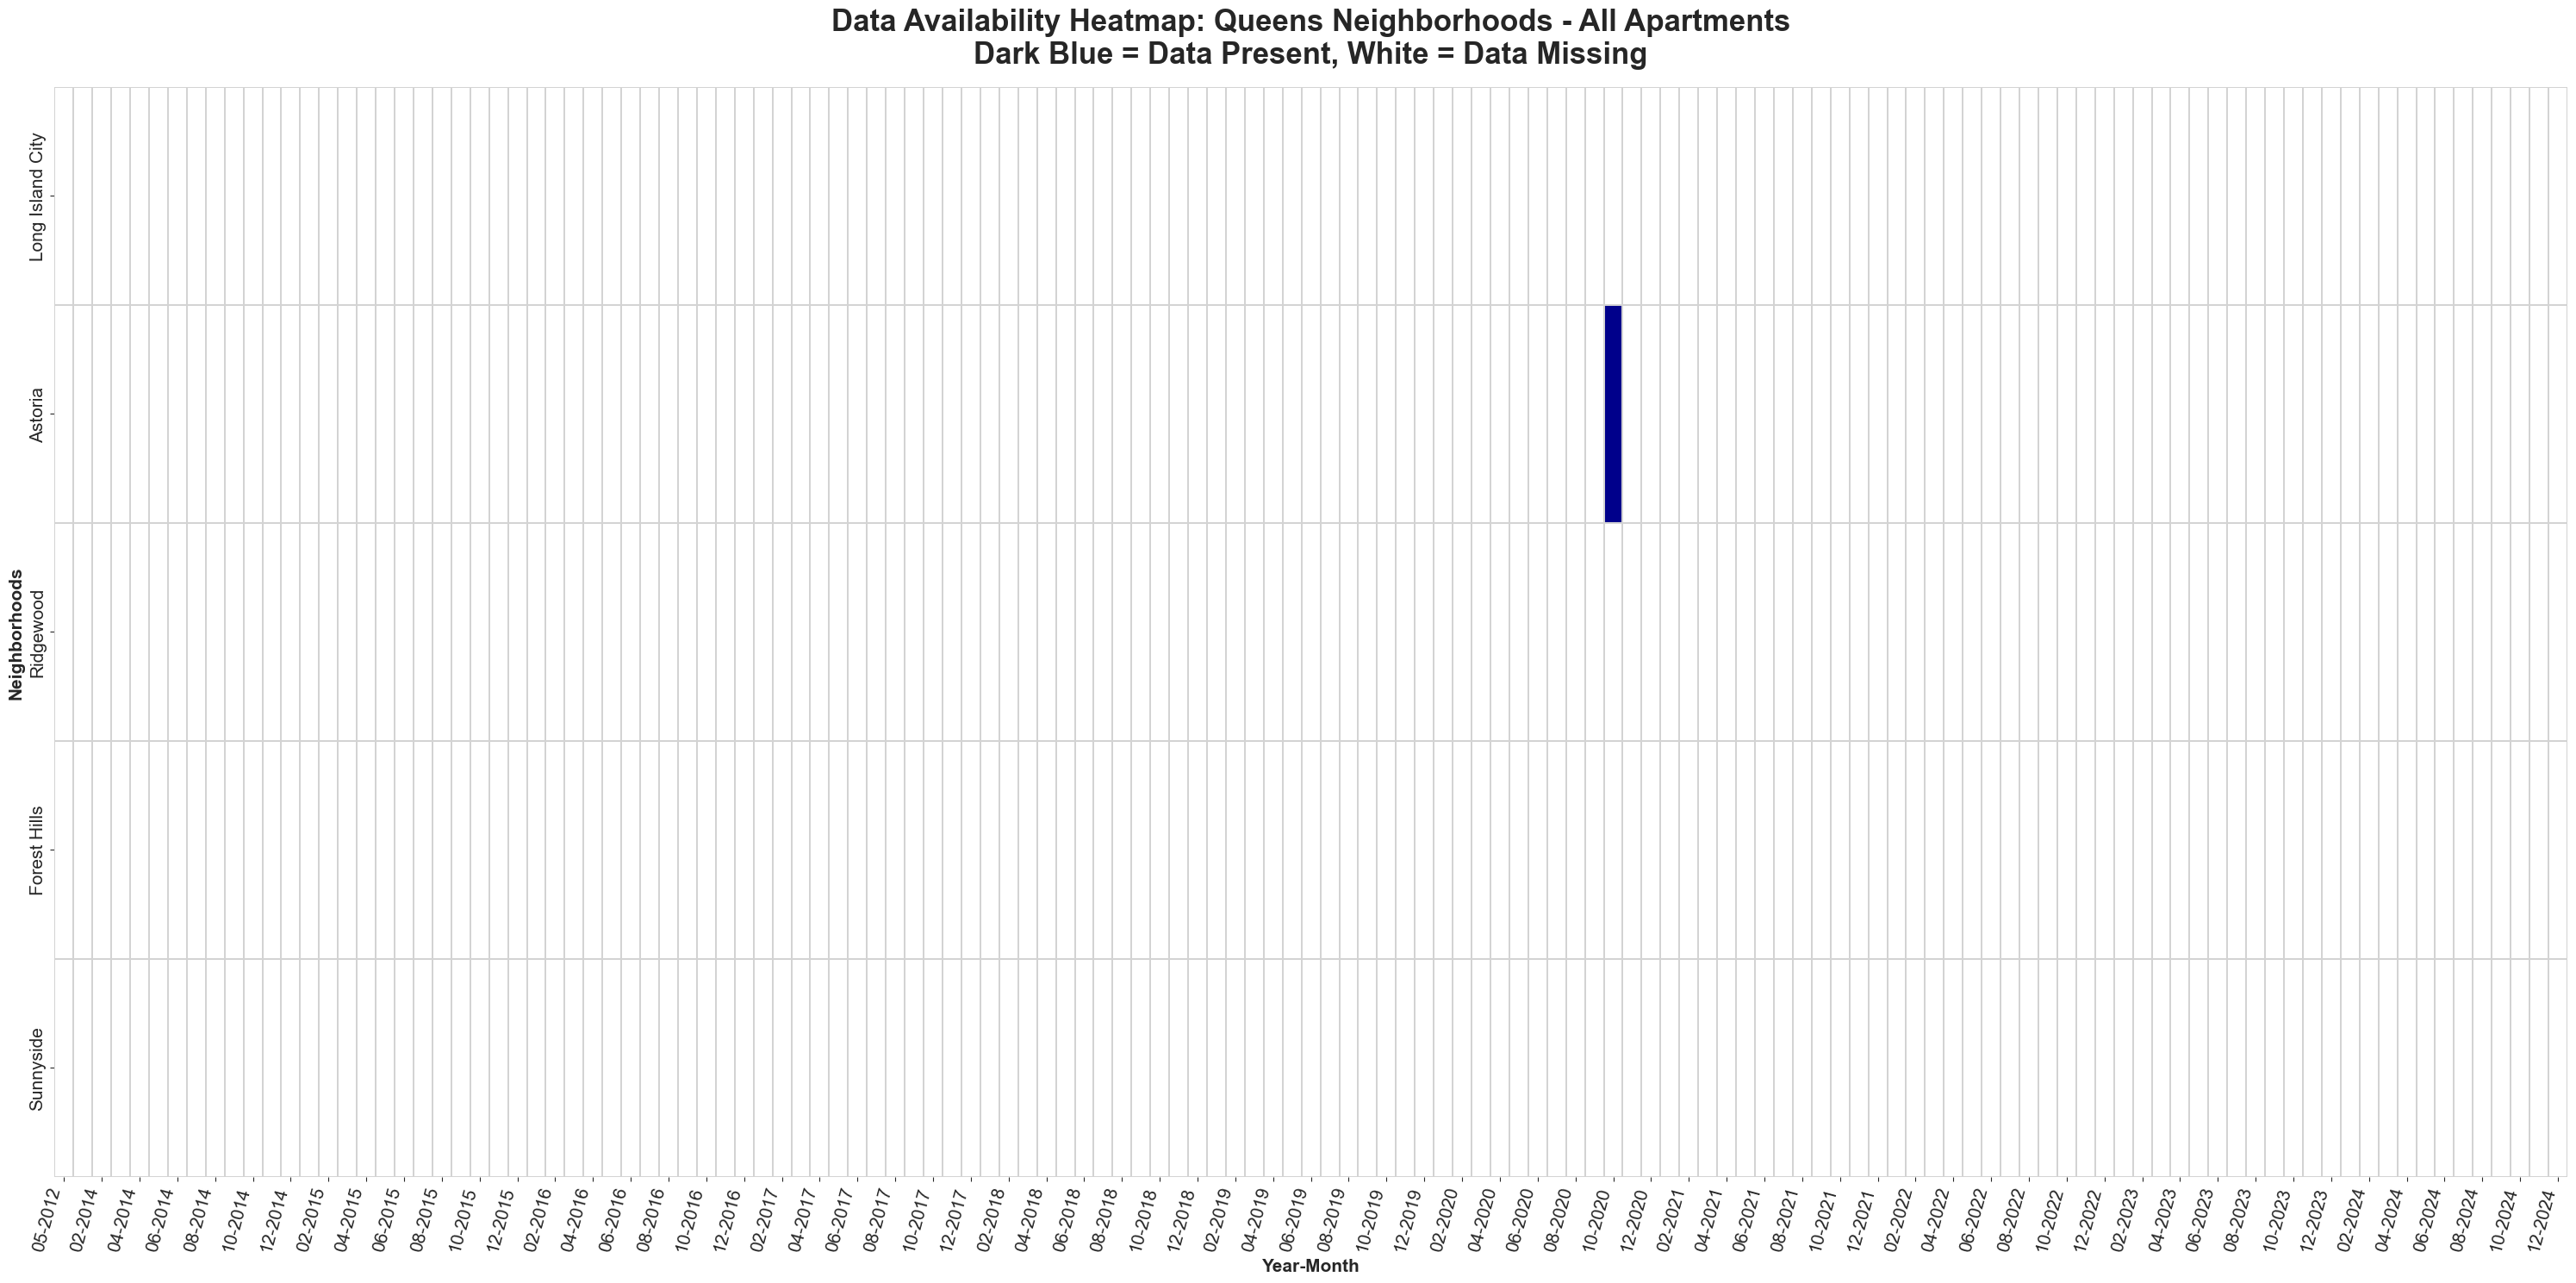

Data Availability Summary for Queens:
Total data points: 665
Data present: 1.0 (0.2%)
Data missing: 664.0 (99.8%)
Number of neighborhoods: 5
Number of time periods: 133


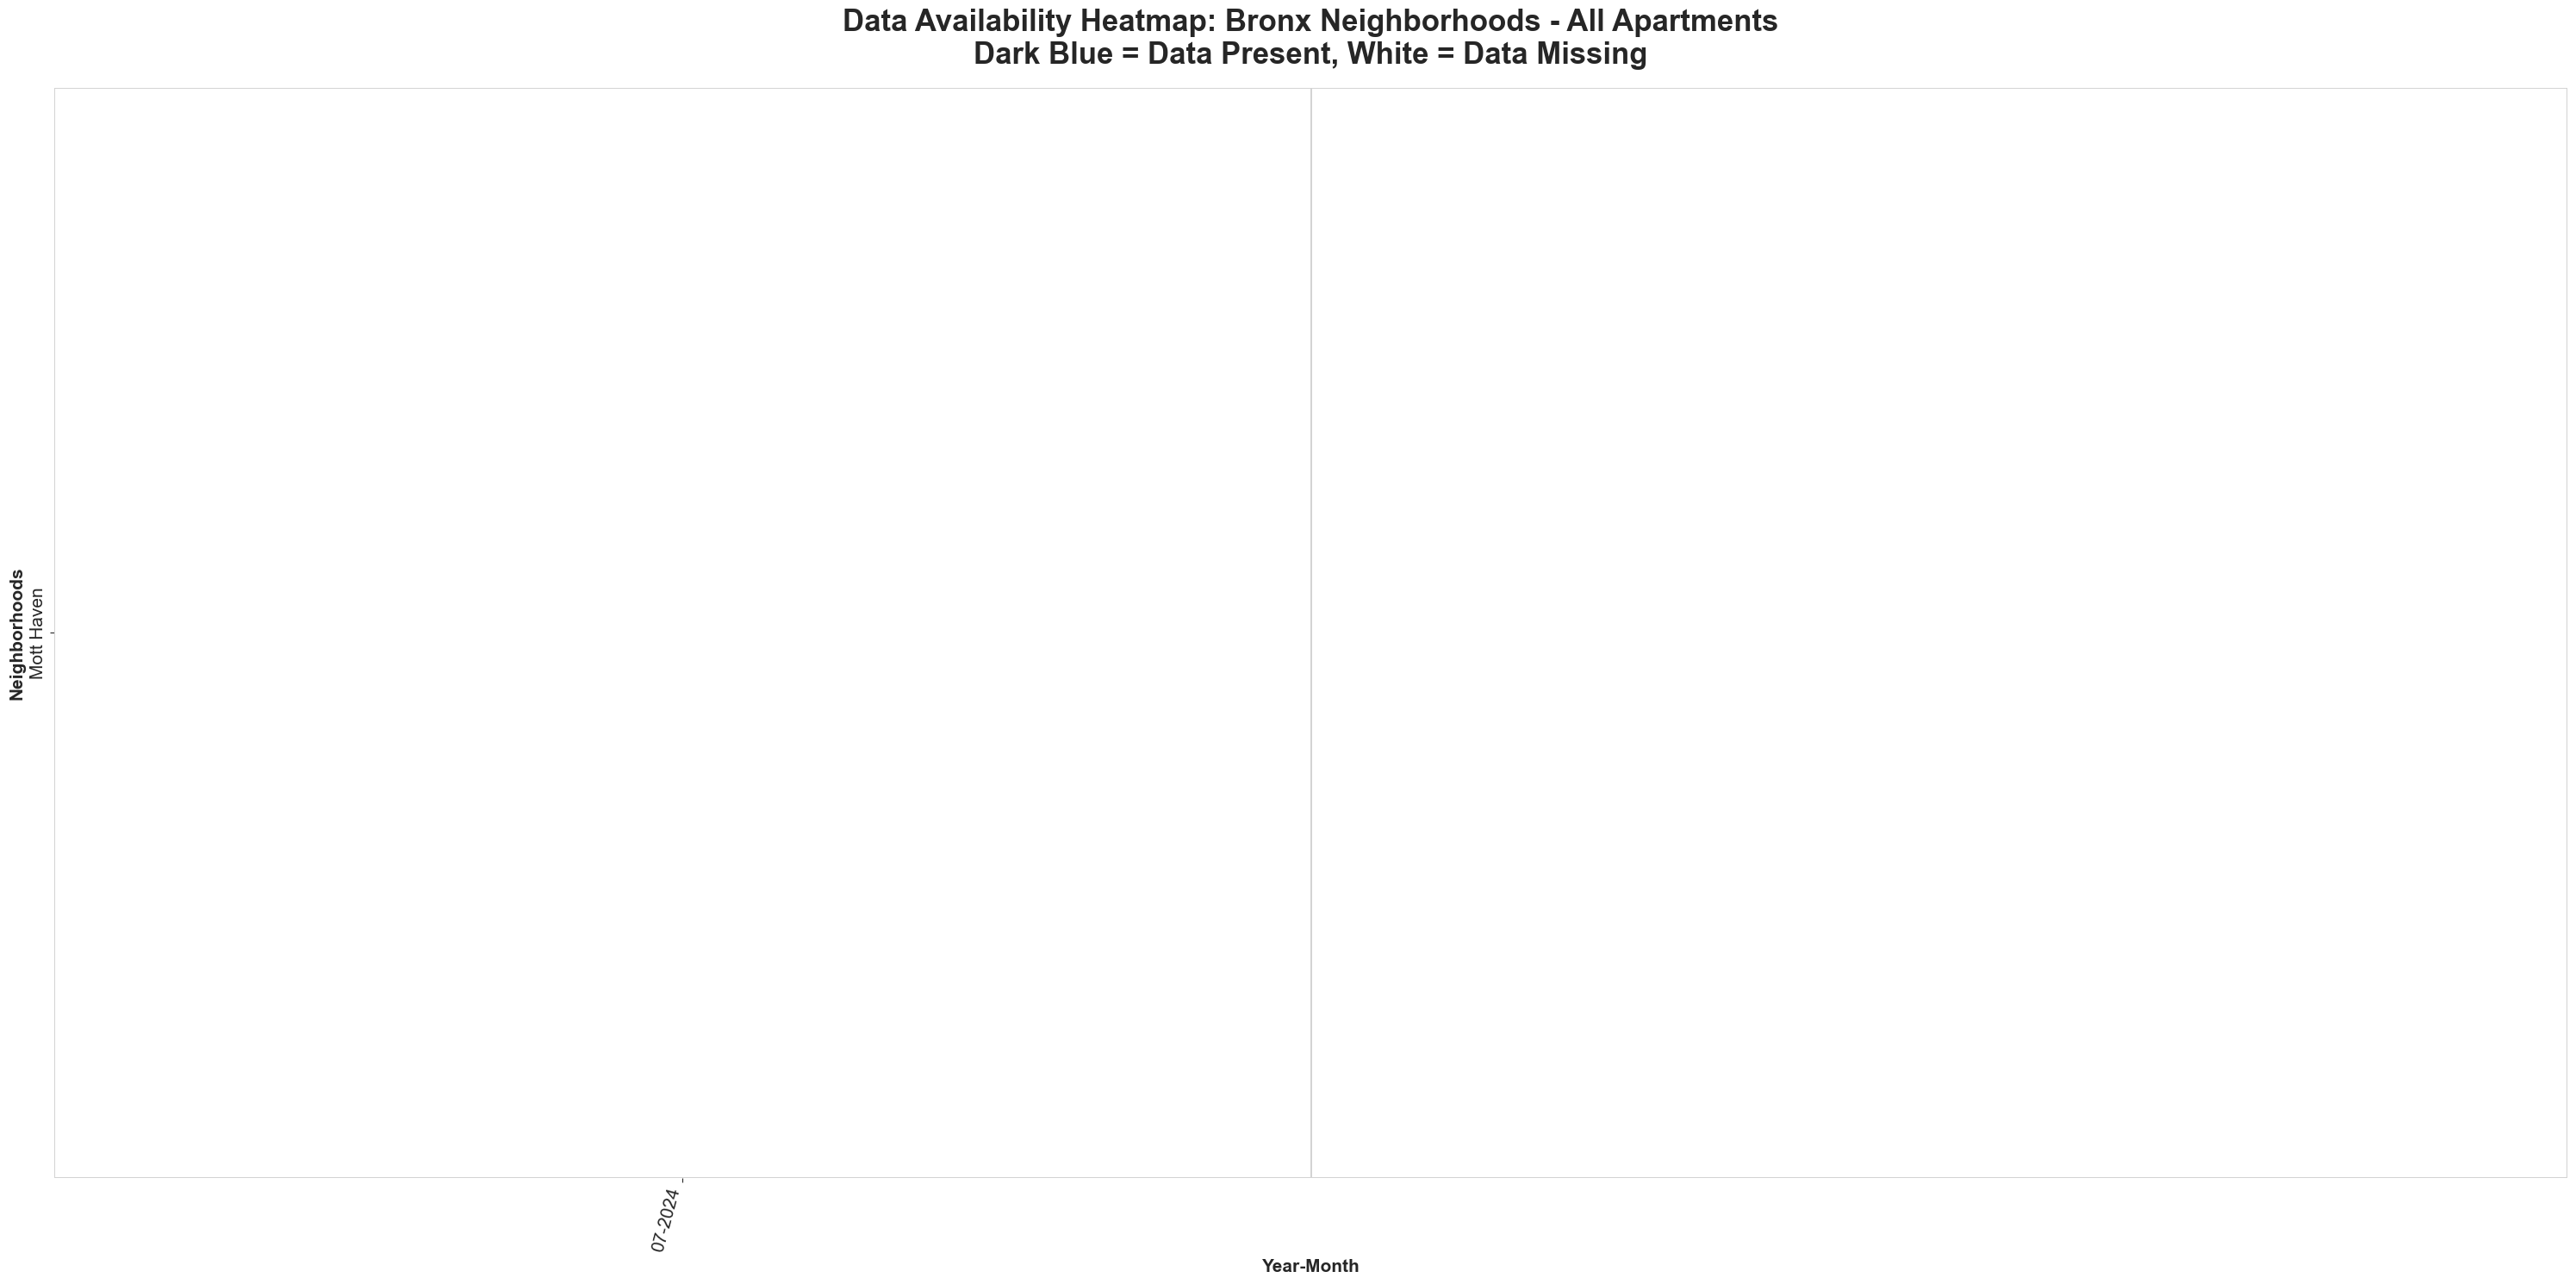

Data Availability Summary for Bronx:
Total data points: 2
Data present: 0.0 (0.0%)
Data missing: 2.0 (100.0%)
Number of neighborhoods: 1
Number of time periods: 2


In [ ]:
for borough in boroughs:
    create_data_availability_heatmap(rent_df, borough, apt_type='3bdr', subtitle='All Apartments')

## Preliminary Rent Data Analysis

### Analyzing rent data for All Apartments

Let's look at a histogram of rent prices, at the borough level

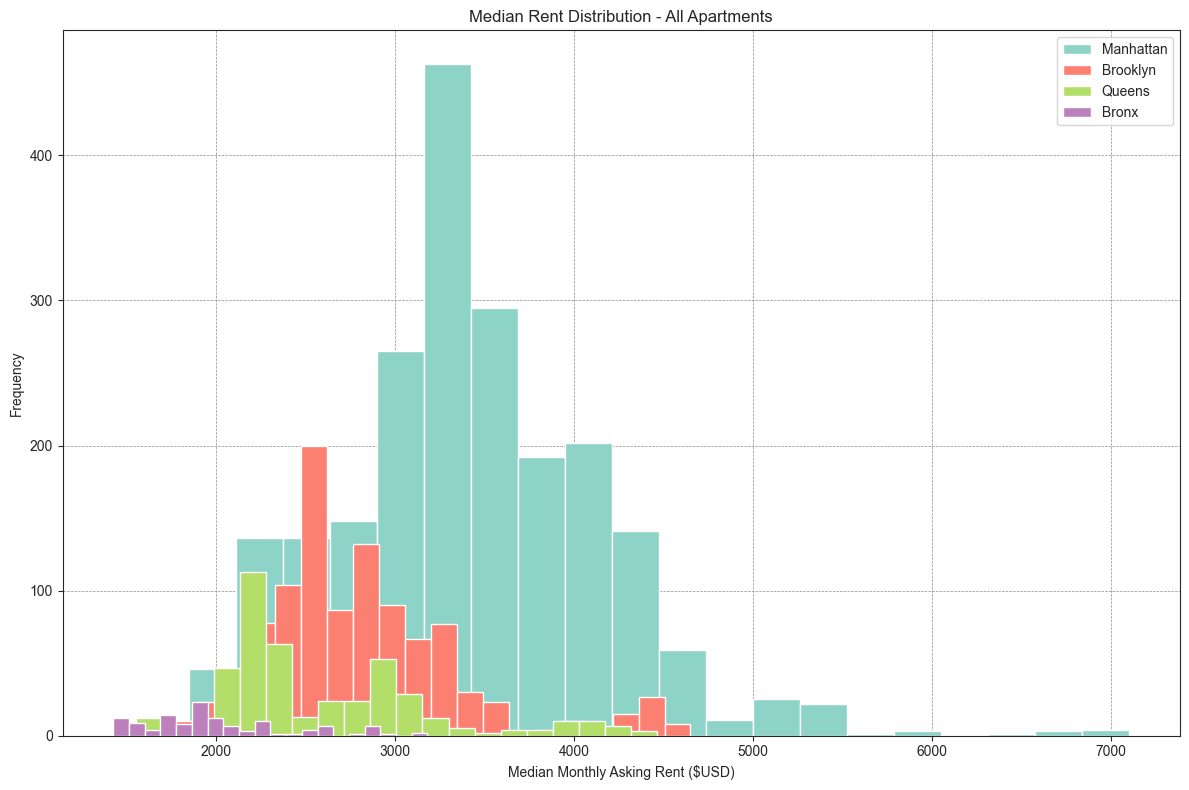

In [227]:
boroughs = ['Manhattan','Brooklyn','Queens','Bronx']
cmap = mpl.colormaps['Set3']
colors = cmap(np.linspace(0,1,5))
sns.set_style('ticks')

plt.figure(figsize=(12,8))
for i, borough in enumerate(boroughs):
    subset_df = rent_df[rent_df['borough'] == borough]
    plt.hist(subset_df['all_price'], bins=20, label=borough, color=colors[i])

plt.legend(loc='upper right')
plt.title('Median Rent Distribution - All Apartments')
plt.xlabel('Median Monthly Asking Rent ($USD)')
plt.ylabel('Frequency')
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Let's see how rent prices fluctuate monthly

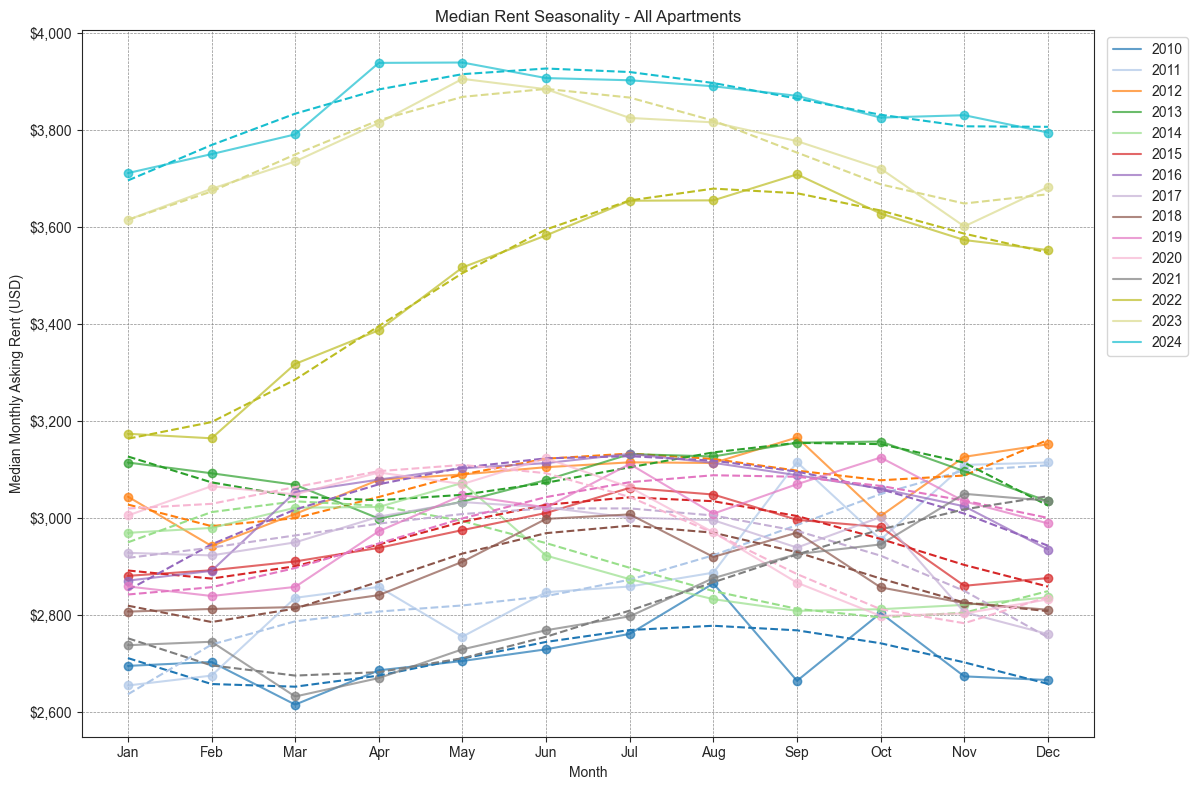

In [236]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','all_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Seasonality - All Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Median apartment rent prices ranged between $2300 and $2800 between 2010 and 2019.

Then, they shifted upwards ranging between $2800 and $3500 after 2021.

Let's take a closer look at this decadal shift.

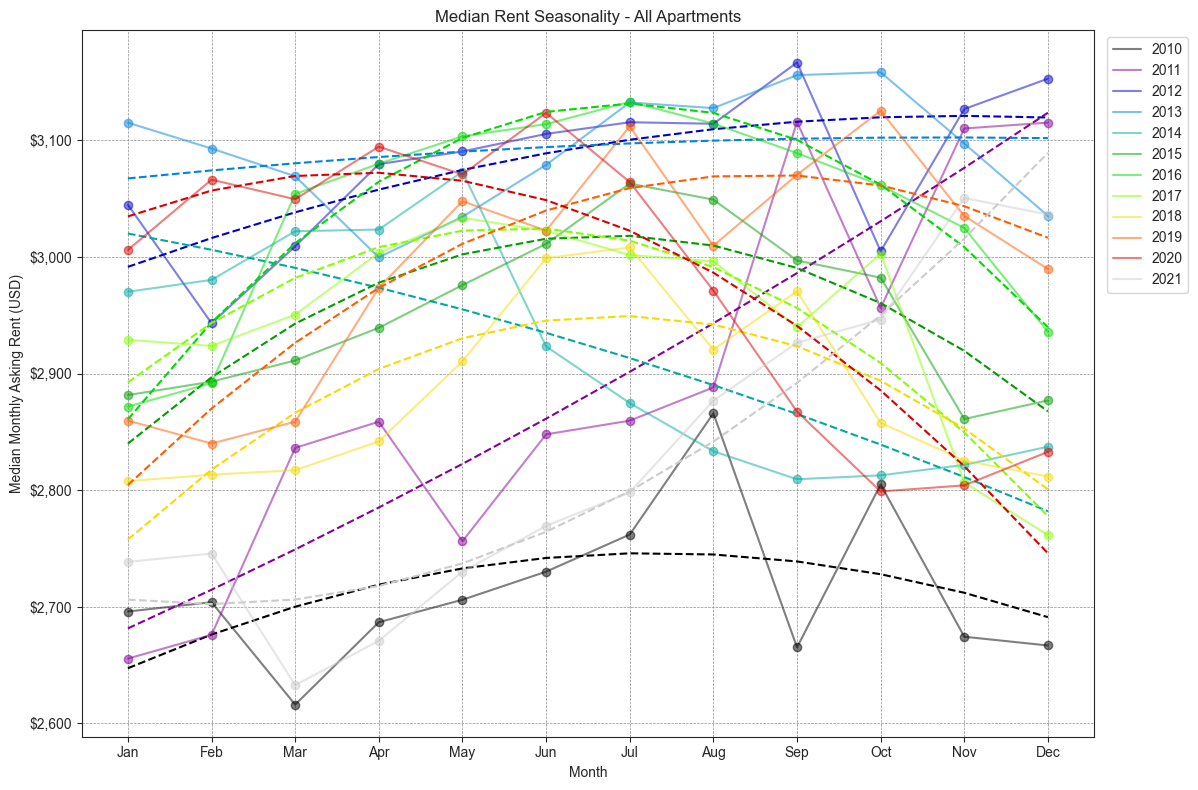

In [255]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()[:12]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','all_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 2)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Seasonality - All Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

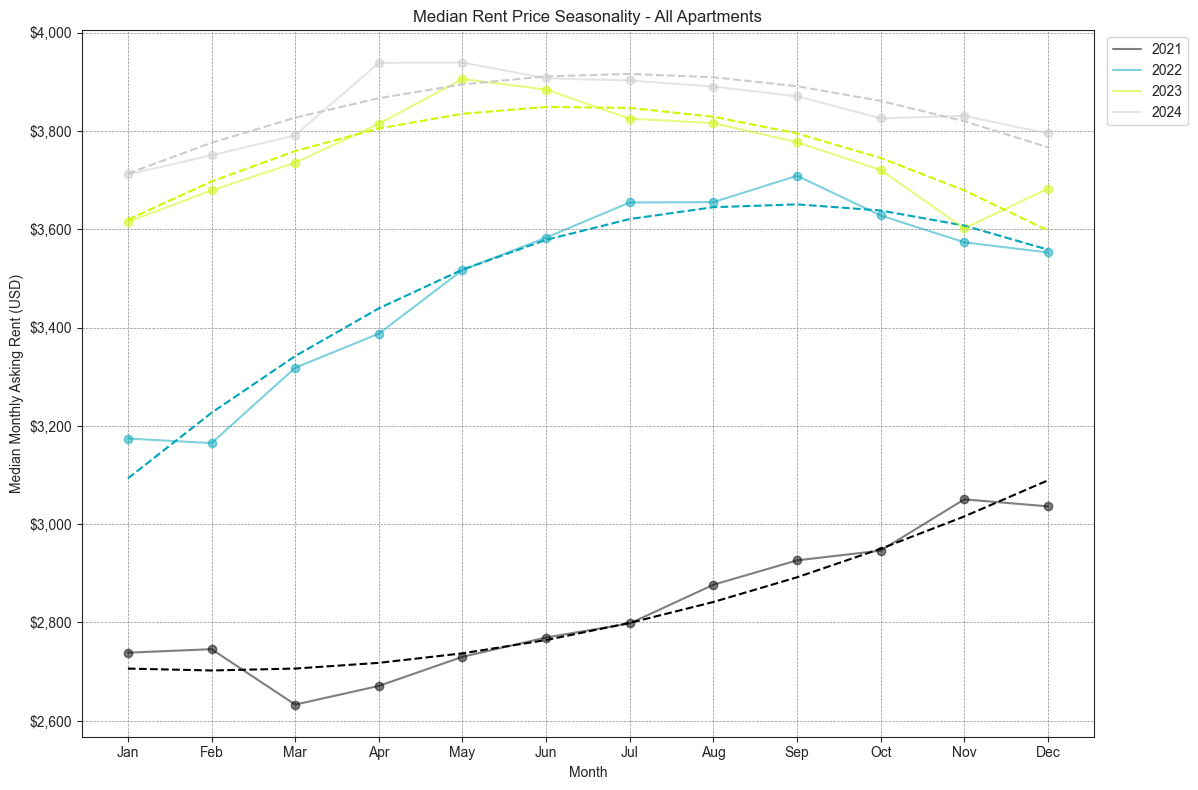

In [257]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()[11:]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','all_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 2)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Price Seasonality - All Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

### Analyzing rent data for 1-Bedroom Apartments

Let's look at a histogram of rent prices, at the borough level

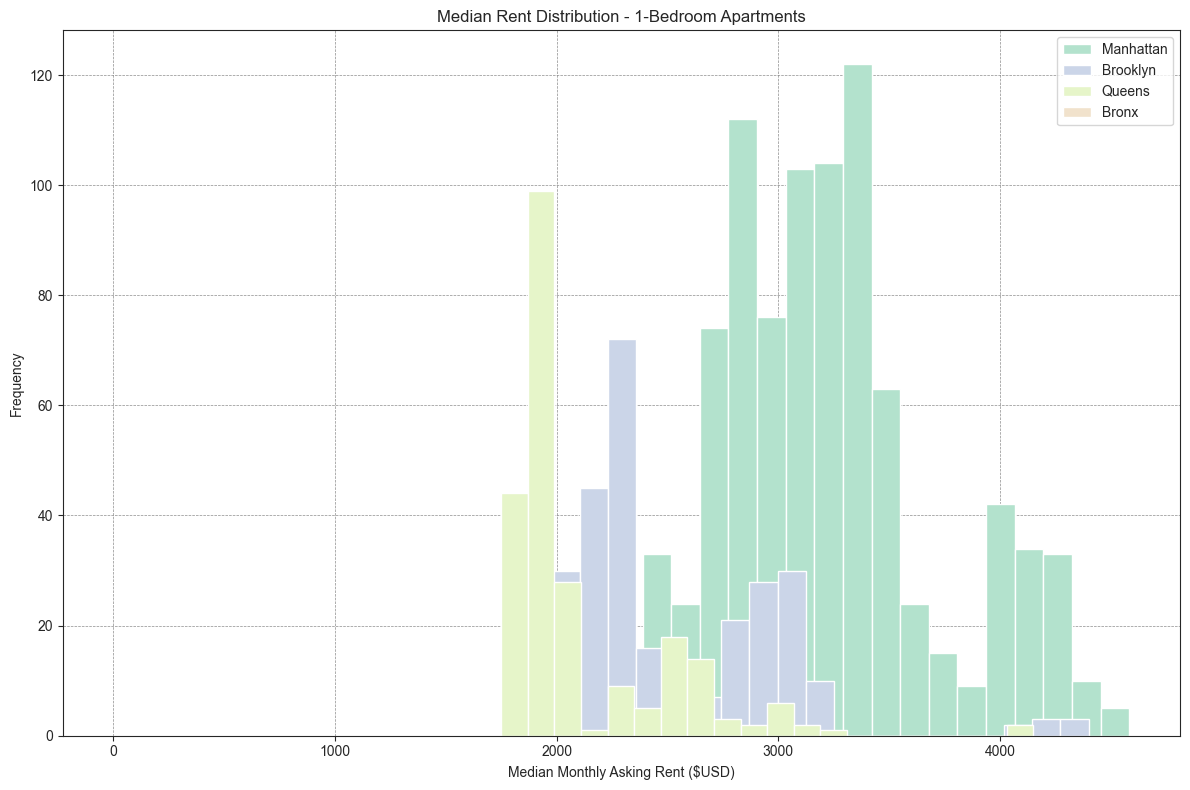

In [249]:
boroughs = ['Manhattan','Brooklyn','Queens','Bronx']
cmap = mpl.colormaps['Pastel2']
colors = cmap(np.linspace(0,1,5))

plt.figure(figsize=(12,8))
for i, borough in enumerate(boroughs):
    subset_df = rent_df[rent_df['borough'] == borough]
    plt.hist(subset_df['1bdr_price'].dropna(), bins=20, label=borough, color=colors[i])

plt.legend(loc='upper right')
plt.title('Median Rent Distribution - 1-Bedroom Apartments')
plt.xlabel('Median Monthly Asking Rent ($USD)')
plt.ylabel('Frequency')
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Let's see how rent prices fluctuate monthly

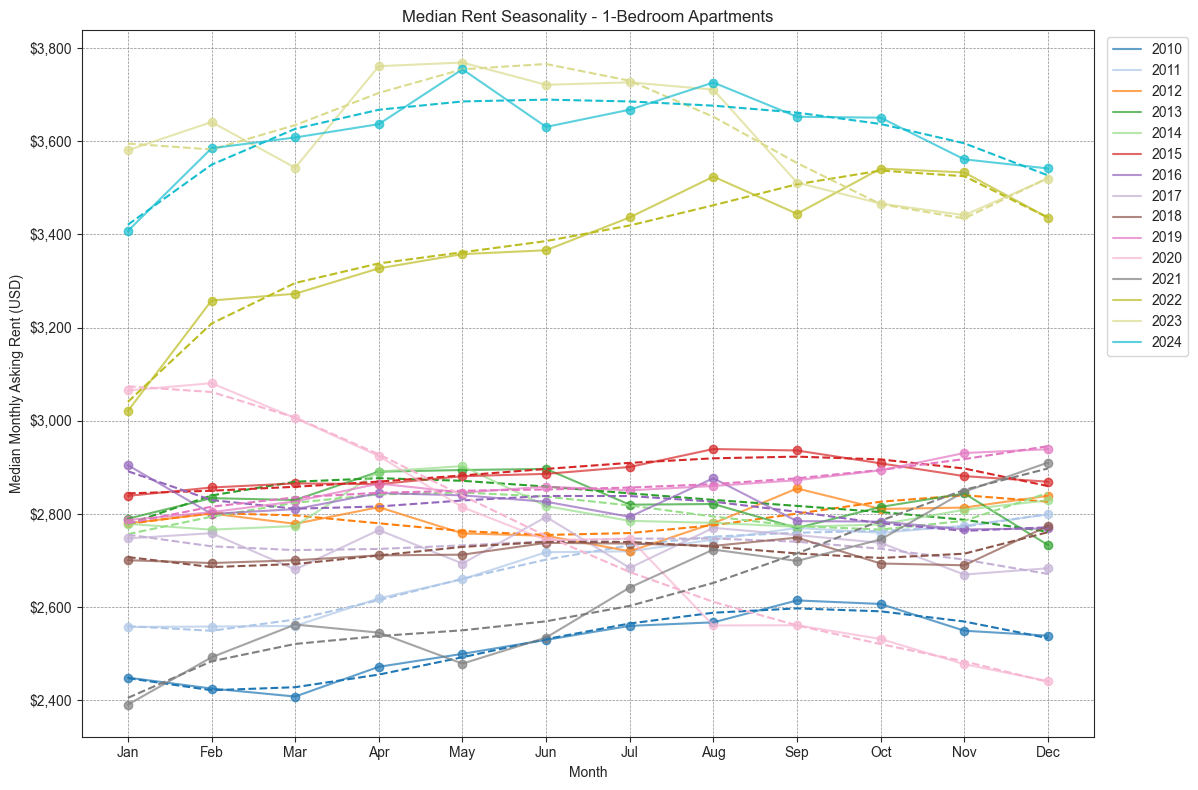

In [251]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','1bdr_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Seasonality - 1-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

We're seeing a trend that is similar to what we saw earlier while looking at all apartment data:

Median 1-bedroom apartment rent prices went through a decadal shift before and after 2021.

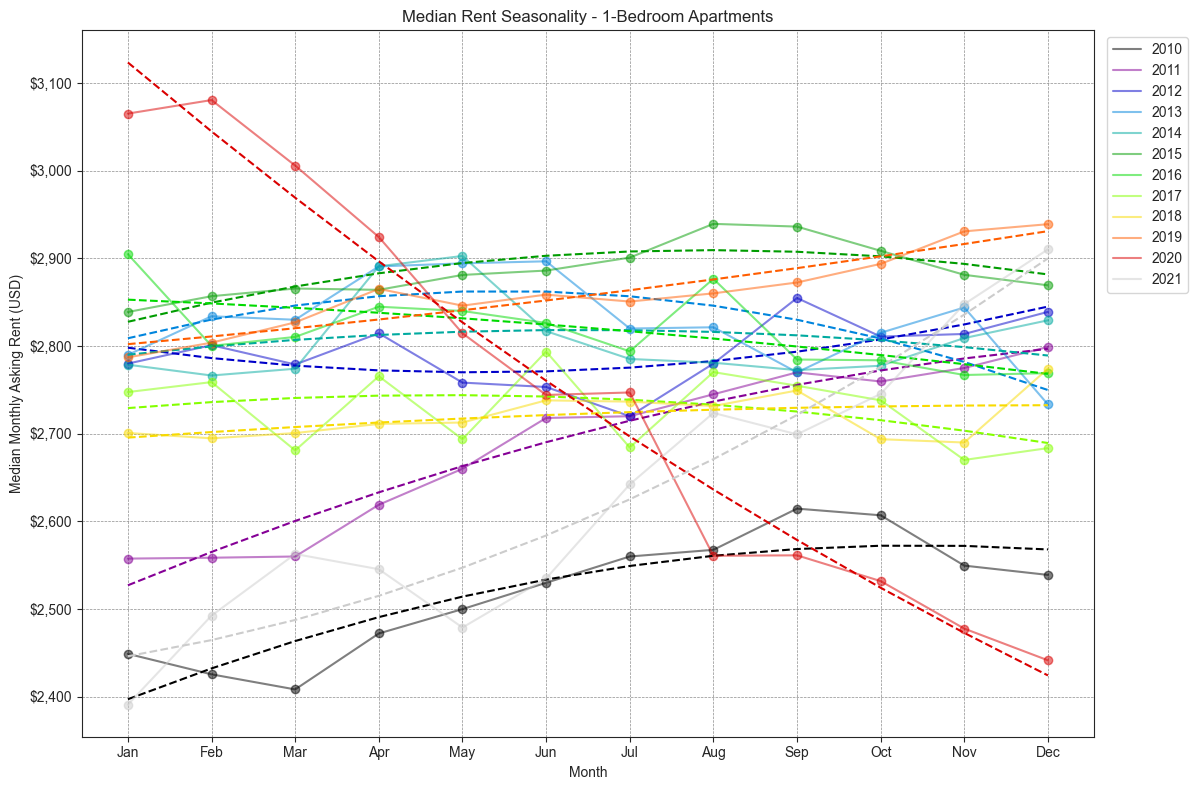

In [258]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()[:12]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','1bdr_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 2)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Seasonality - 1-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

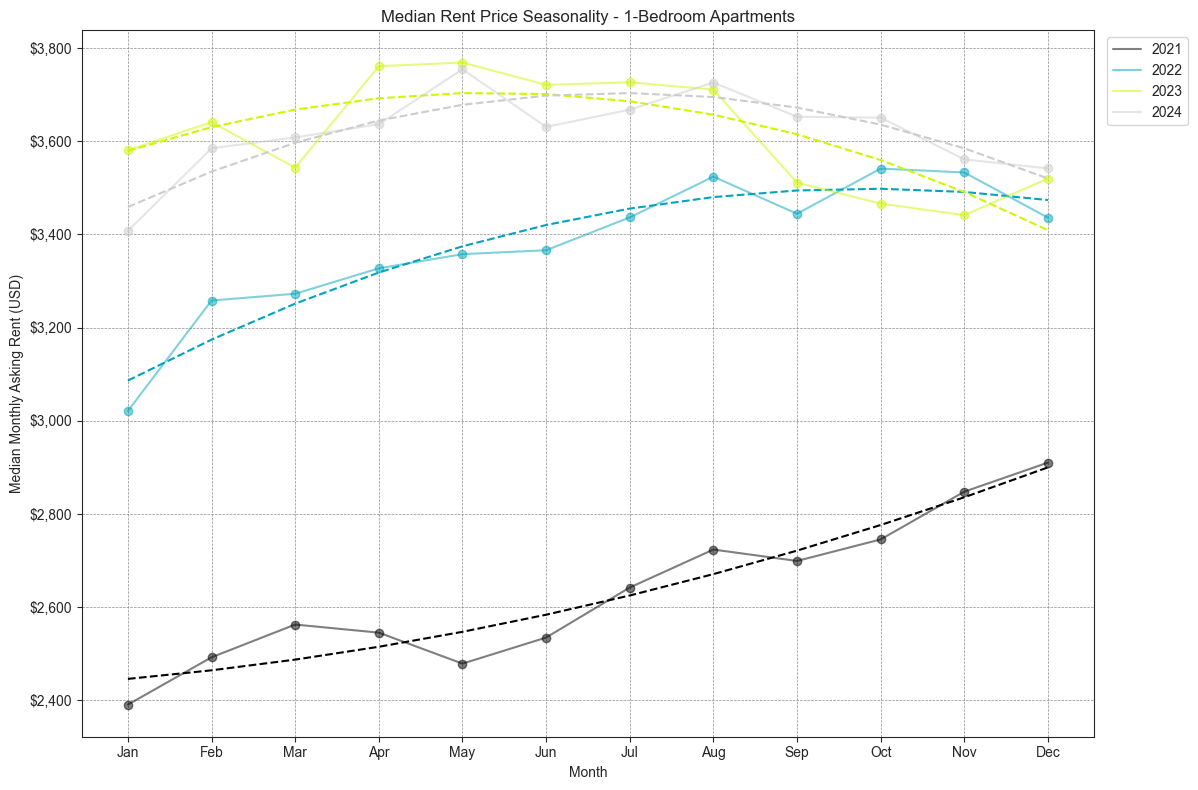

In [259]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()[11:]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','1bdr_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 2)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Price Seasonality - 1-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

### Analyzing rent data for 3-Bedroom Apartments

Let's look at a histogram of rent prices, at the borough level

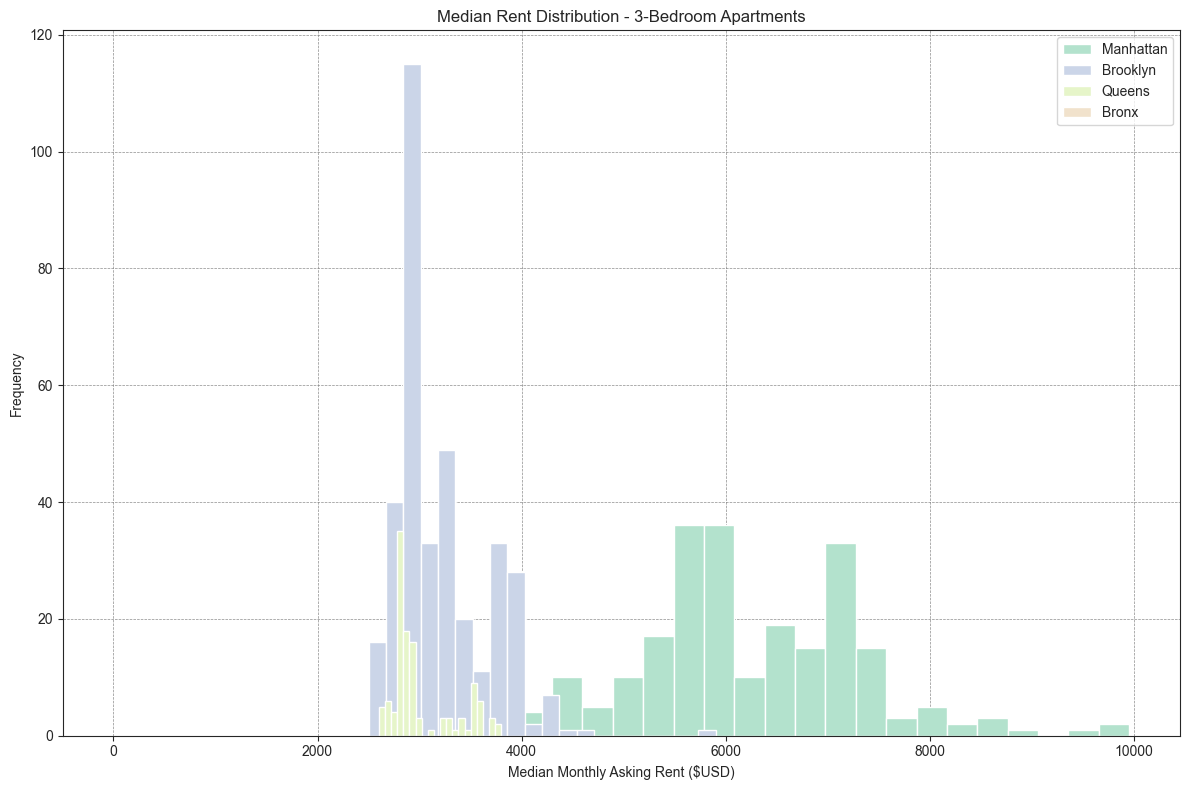

In [263]:
boroughs = ['Manhattan','Brooklyn','Queens','Bronx']
cmap = mpl.colormaps['Pastel2']
colors = cmap(np.linspace(0,1,5))

plt.figure(figsize=(12,8))
for i, borough in enumerate(boroughs):
    subset_df = rent_df[rent_df['borough'] == borough]
    plt.hist(subset_df['3bdr_price'].dropna(), bins=20, label=borough, color=colors[i])

plt.legend(loc='upper right')
plt.title('Median Rent Distribution - 3-Bedroom Apartments')
plt.xlabel('Median Monthly Asking Rent ($USD)')
plt.ylabel('Frequency')
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Let's see how rent prices fluctuate monthly

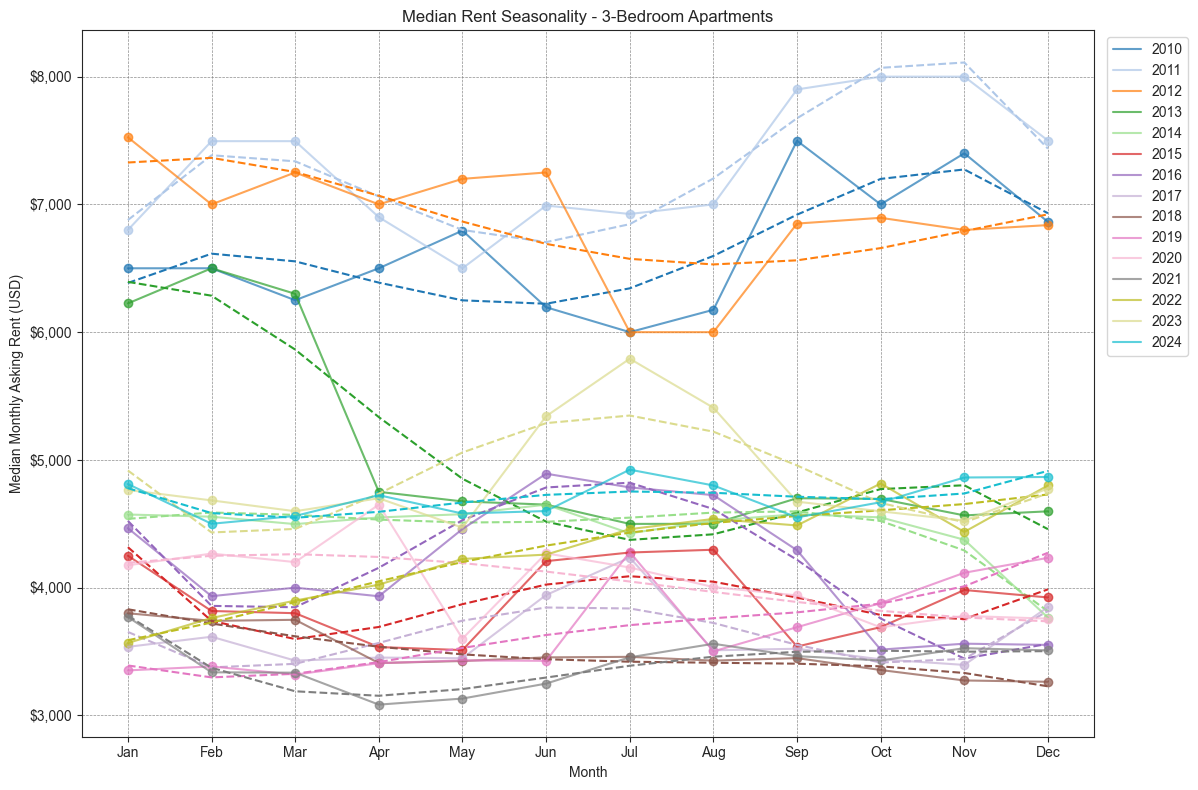

In [264]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','3bdr_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Seasonality - 3-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

3-bedroom apartments have a more complex story regarding monthly price fluctuations over time.

It appears that the years 2010-2013 have higher asking rent prices than the following years leading up to 2020.

Then, we see a a price shift similar to that of the 1-bedroom and all-apartment datasets, however, the gap between the 2 groups isn't as large as approx. $1000. This likely has to do with lower demand for apartments with 3+ bedrooms.

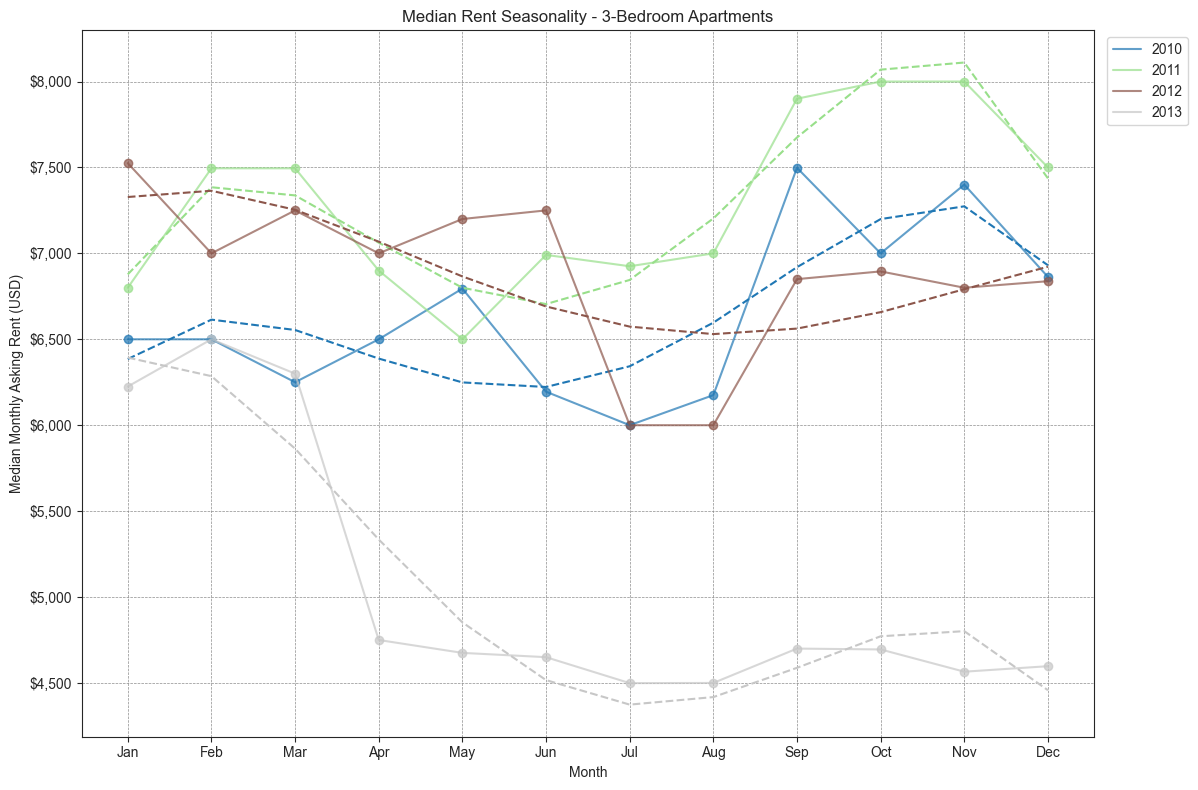

In [266]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()[:4]
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','3bdr_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Seasonality - 3-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

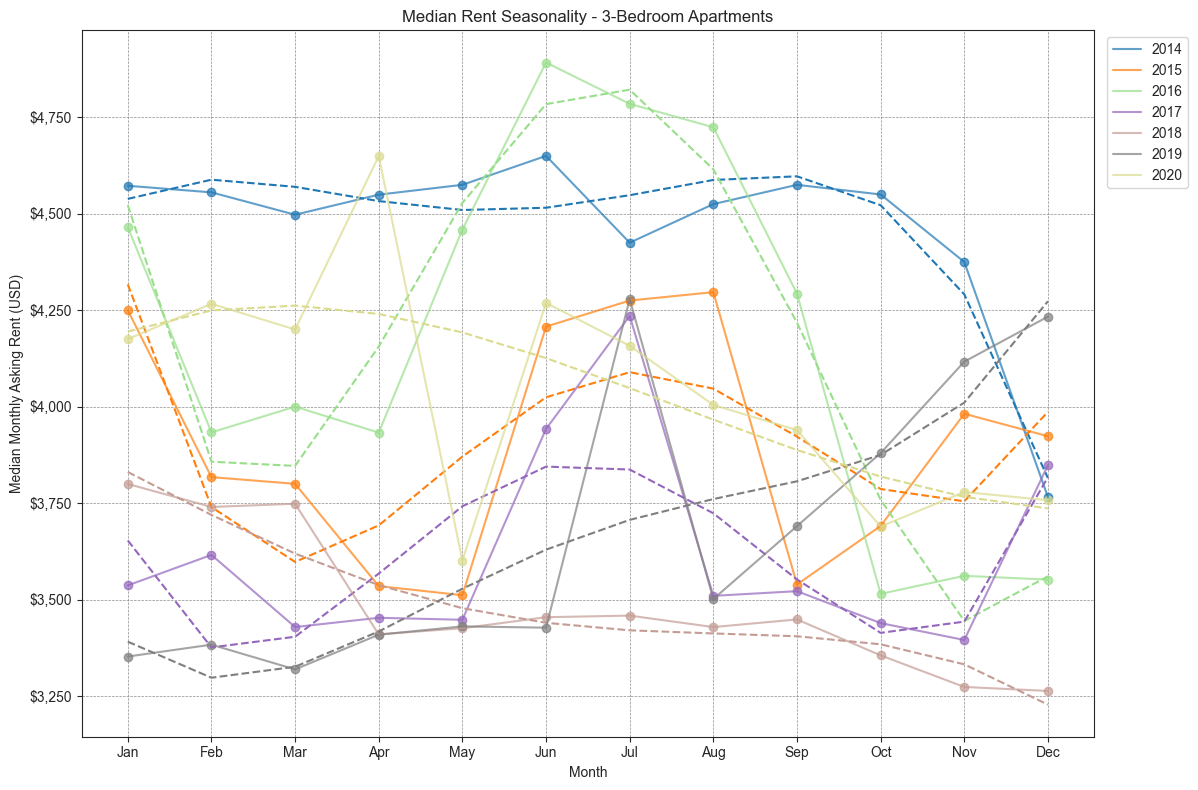

In [269]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()[4:11]
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','3bdr_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Seasonality - 3-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

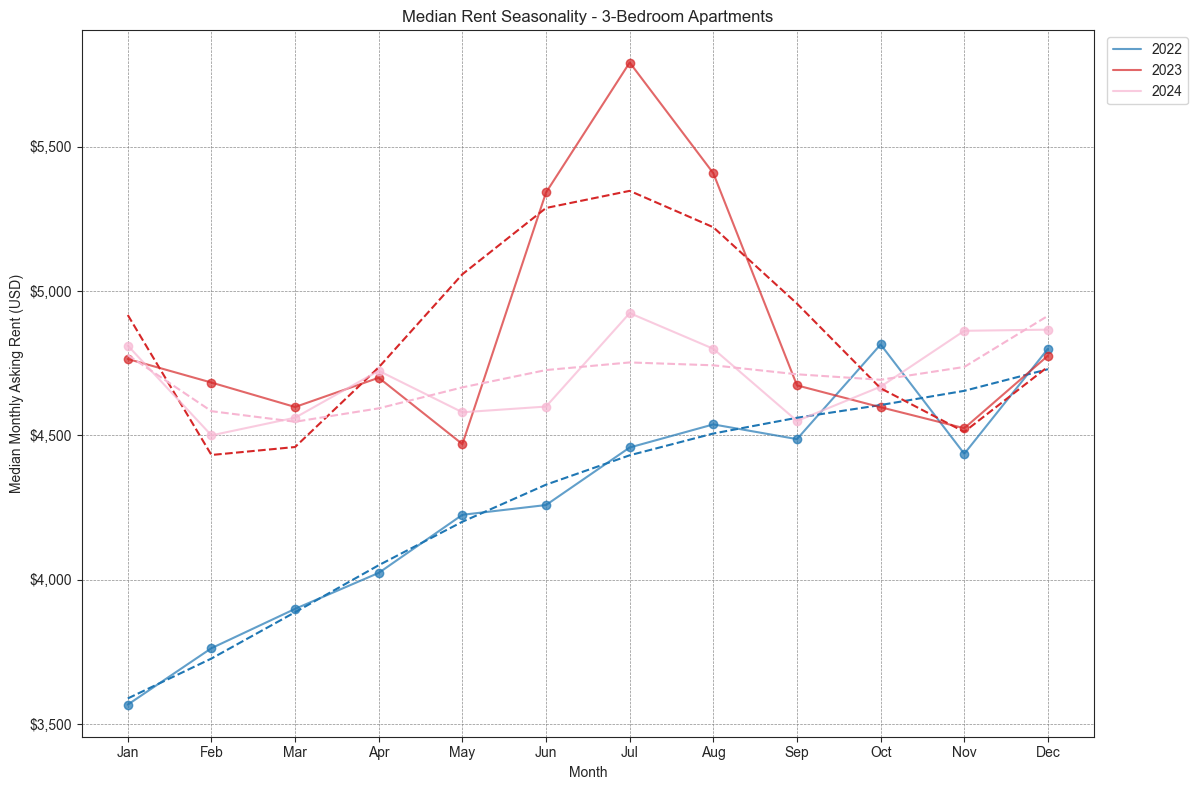

In [270]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = rent_df['year'].unique()[12:]
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,8))
for i, year in enumerate(years):
    monthly_rent = rent_df[rent_df['year'] == year][['month','3bdr_price']].groupby('month').mean()
    plt.plot(months, monthly_rent, color=colors[i], label=year, alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff.squeeze())
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Median Rent Seasonality - 3-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

## Load/Uploading Dataset to BigQuery

In [51]:
# configuration
PROJECT_ID = "rent-affordability"
DATASET = "nyc_analysis"
TABLE_ID = f"{PROJECT_ID}.{DATASET}.staging_median_rent"

# load credentials
service_account_info = json.loads(os.environ["GOOGLE_CREDENTIALS_JSON"])
credentials = service_account.Credentials.from_service_account_info(service_account_info)
# initialize client
client = bigquery.Client(project=PROJECT_ID, credentials=credentials)
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

job = client.load_table_from_dataframe(rent_df, TABLE_ID, job_config=job_config)
job.result() # ensures the script waits for the job to complete

# 5a. check if the upload was successful
if job.state == 'DONE':
    if job.error_result:
        print(f"Job completed with errors: {job.error_result}")
    else:
        print(f"Job completed successfully. Loaded {job.output_rows} rows to {TABLE_ID}")
else:
    print(f"Job state: {job.state}")

Job completed successfully. Loaded 37818 rows to rent-affordability.nyc_analysis.staging_median_rent


# Importing, Visualizing/Understanding, Preprocessing, and Uploading Income Data

## Extract/Import Income Datasets

In [ ]:
# 1. Downloading ACS data using Census API
ACS_Tables = [
    'B19013_001E',  # All HHs - median income
    'B19202_001E',  # 1-person HH - median income
    'B19131_002E',  # Married HHs w/ children - median income
    'B19131_005E',  # Other HHs w/ children - median income (foster, grandparents, etc.)
    ]

# Importing Median Income for All Households (B19013_001E)
median_HH_income_all = Import_ACS_Table(os.getenv('CENSUS_API'), 36,
                                        ACS_Tables[0])

# Importing Median Income for Single Adult Households (B19202_001E)
median_HH_income_singles = Import_ACS_Table(os.getenv('CENSUS_API'), 36,
                                            ACS_Tables[1])

# Importing Median Income for Married Households w/ Children (B19131_002E)
median_HH_income_married_kids = Import_ACS_Table(os.getenv('CENSUS_API'), 36,
                                            ACS_Tables[2])

# Importing Median Income for Other Households w/ Children (B19131_005E)
median_HH_income_other_kids = Import_ACS_Table(os.getenv('CENSUS_API'), 36,
                                            ACS_Tables[3])

median_HH_income_all

NAME B19013_001E state  \
0    NYC-Brooklyn Community District 1--Greenpoint ...      101442    36   
1    NYC-Brooklyn Community District 1--Greenpoint ...       50298    36   
2    NYC-Brooklyn Community District 1--Greenpoint ...       52419    36   
3    NYC-Brooklyn Community District 1--Greenpoint ...       57818    36   
4    NYC-Brooklyn Community District 1--Greenpoint ...       67107    36   
..                                                 ...         ...   ...   
415  NYC-Queens Community District 9--Richmond Hill...       66531    36   
416  NYC-Queens Community District 9--Richmond Hill...       69916    36   
417  NYC-Queens Community District 9--Richmond Hill...       71796    36   
418  NYC-Queens Community District 9--Richmond Hill...       75207    36   
419  NYC-Queens Community District 9--Richmond Hill...       76978    36   

    public use microdata area  year  
0                       04001  2021  
1                       04001  2012  
2                       04001  2013  
3                       04001  2014  
4                       04001  2015  
..                        ...   ...  
415                     04111  2016  
416                     04111  2017  
417                     04111  2018  
418                     04111  2021  
419                     04111  2019  

[420 rows x 5 columns]

The U.S. Census does not provide a count of households represented in each annual income estimate. They utilize a weighted methodolgy, so income estimates are representative of the thousands/millions of people represented in each Public-Use Microdata Area. 

## Tidy Income Datasets

All income datasets are already in tidy format (yay)! So, let's simply merge them and modify the column names and organization to improve usability.

In [ ]:
#  merging tables with income data
income_dfs = [median_HH_income_all,
              median_HH_income_singles,
              median_HH_income_other_kids,
              median_HH_income_married_kids
]

for idx, df in enumerate(income_dfs):
    if idx == 0:
        merged_table = pd.merge(df, income_dfs[idx+1], how='inner',
                                on=['NAME','public use microdata area', 'year', 'state']
                                )
    elif idx == (len(income_dfs)-1):
        break
    else:
        merged_table = pd.merge(merged_table, income_dfs[idx+1], how='inner', # type: ignore
                                on=['NAME','public use microdata area', 'year', 'state']
                                )

# Rename columns for easier querying
merged_table.rename(columns={"B19013_001E":"all_HHs",
                             "B19202_001E":"singles",
                             "B19131_002E":"married_kids",
                             "B19131_005E":"other_kids",
                             "NAME": "district",
                             "public use microdata area": "PUMA"
}, inplace=True)


cols = list(merged_table.columns)
# move income columns to right side of df
cols.insert(5, cols[1])
del cols[1:3]
income_df = merged_table[cols]
income_df

district   PUMA  year all_HHs  \
0    NYC-Brooklyn Community District 1--Greenpoint ...  04001  2021  101442   
1    NYC-Brooklyn Community District 1--Greenpoint ...  04001  2012   50298   
2    NYC-Brooklyn Community District 1--Greenpoint ...  04001  2013   52419   
3    NYC-Brooklyn Community District 1--Greenpoint ...  04001  2014   57818   
4    NYC-Brooklyn Community District 1--Greenpoint ...  04001  2015   67107   
..                                                 ...    ...   ...     ...   
415  NYC-Queens Community District 9--Richmond Hill...  04111  2016   66531   
416  NYC-Queens Community District 9--Richmond Hill...  04111  2017   69916   
417  NYC-Queens Community District 9--Richmond Hill...  04111  2018   71796   
418  NYC-Queens Community District 9--Richmond Hill...  04111  2021   75207   
419  NYC-Queens Community District 9--Richmond Hill...  04111  2019   76978   

    singles other_kids married_kids  
0     94782       None         None  
1     56697       None         None  
2     52746       None         None  
3     61330       None         None  
4     68720       None         None  
..      ...        ...          ...  
415   41825         20        23295  
416   42685         76        20952  
417   50407        114        23154  
418   57025       None         None  
419   50225       None         None  

[420 rows x 7 columns]

## Transform/Preprocess Income Datasets

In [43]:
# Let's explicitly set the data type for all columns
income_df = income_df.convert_dtypes()
income_df['all_HHs'] = income_df['all_HHs'].astype('Int64')
income_df['singles'] = income_df['singles'].astype('Int64')
income_df['other_kids'] = income_df['other_kids'].astype('Int64')
income_df['married_kids'] = income_df['married_kids'].astype('Int64')
print(income_df.dtypes)

district        string[python]
PUMA            string[python]
year                     Int64
all_HHs                  Int64
singles                  Int64
other_kids               Int64
married_kids             Int64
borough         string[python]
dtype: object


### Let's Visualize Present/Missing Data


Processing Brooklyn...
  All Households: 180.0/360 data points (50.0% coverage)
  Single Adults: 180.0/360 data points (50.0% coverage)
  Married Families w. Children: 58.0/360 data points (16.1% coverage)
  Other Families w. Children: 58.0/360 data points (16.1% coverage)


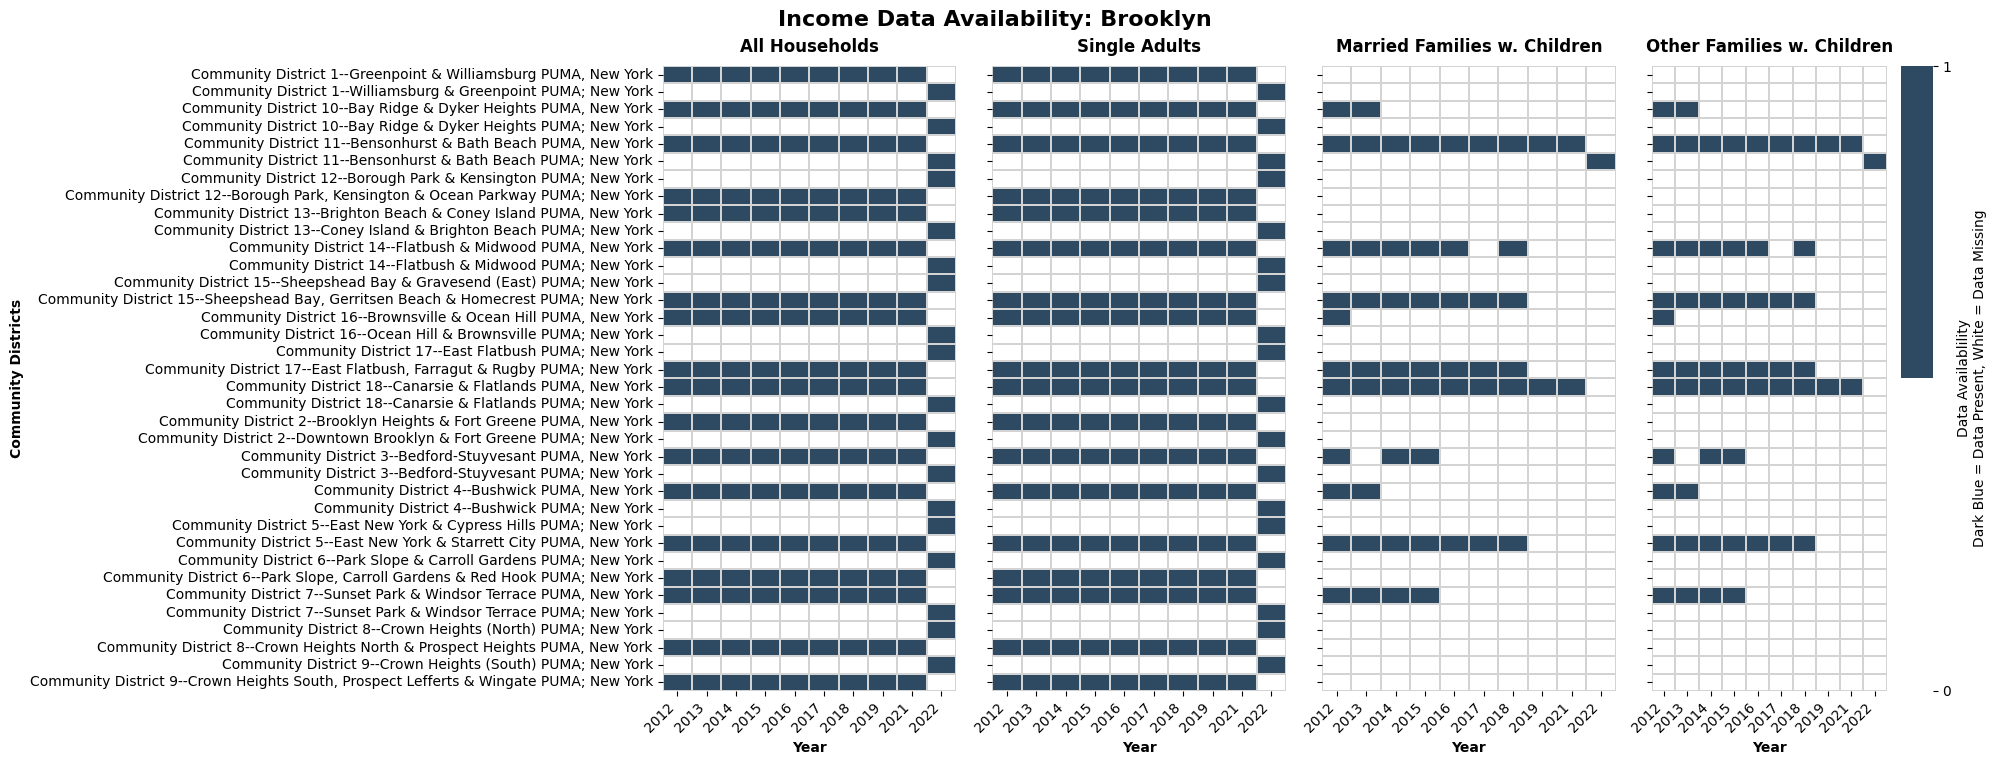


Processing Manhattan...
  All Households: 100.0/200 data points (50.0% coverage)
  Single Adults: 100.0/200 data points (50.0% coverage)
  Married Families w. Children: 4.0/200 data points (2.0% coverage)
  Other Families w. Children: 4.0/200 data points (2.0% coverage)


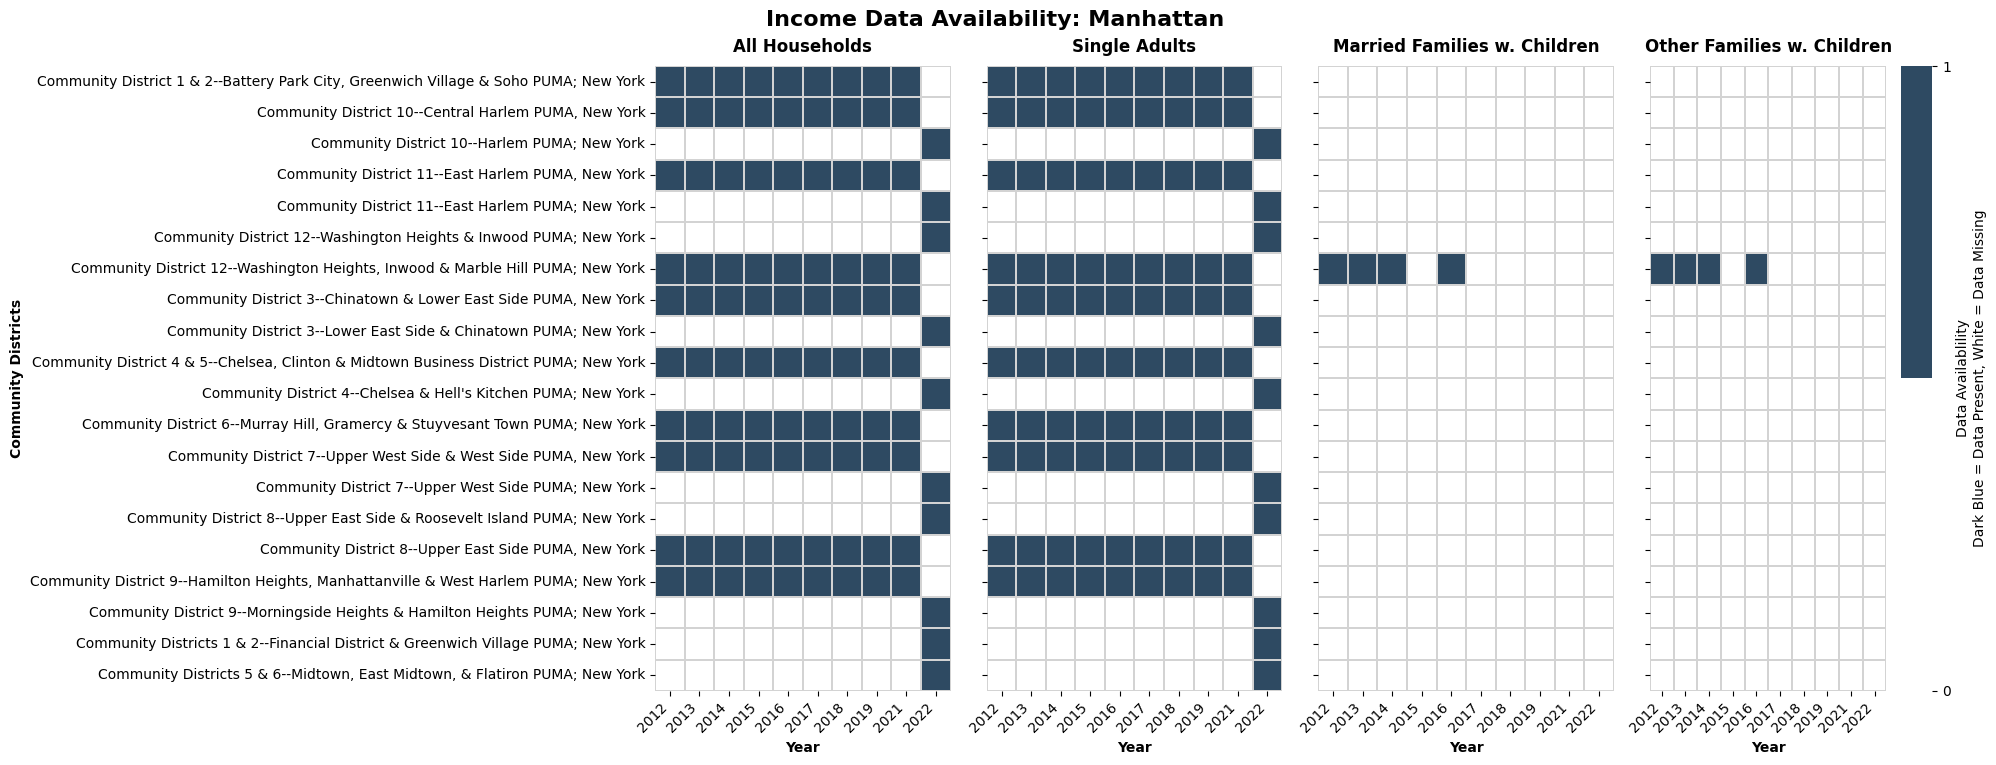


Processing Queens...
  All Households: 140.0/280 data points (50.0% coverage)
  Single Adults: 140.0/280 data points (50.0% coverage)
  Married Families w. Children: 56.0/280 data points (20.0% coverage)
  Other Families w. Children: 56.0/280 data points (20.0% coverage)


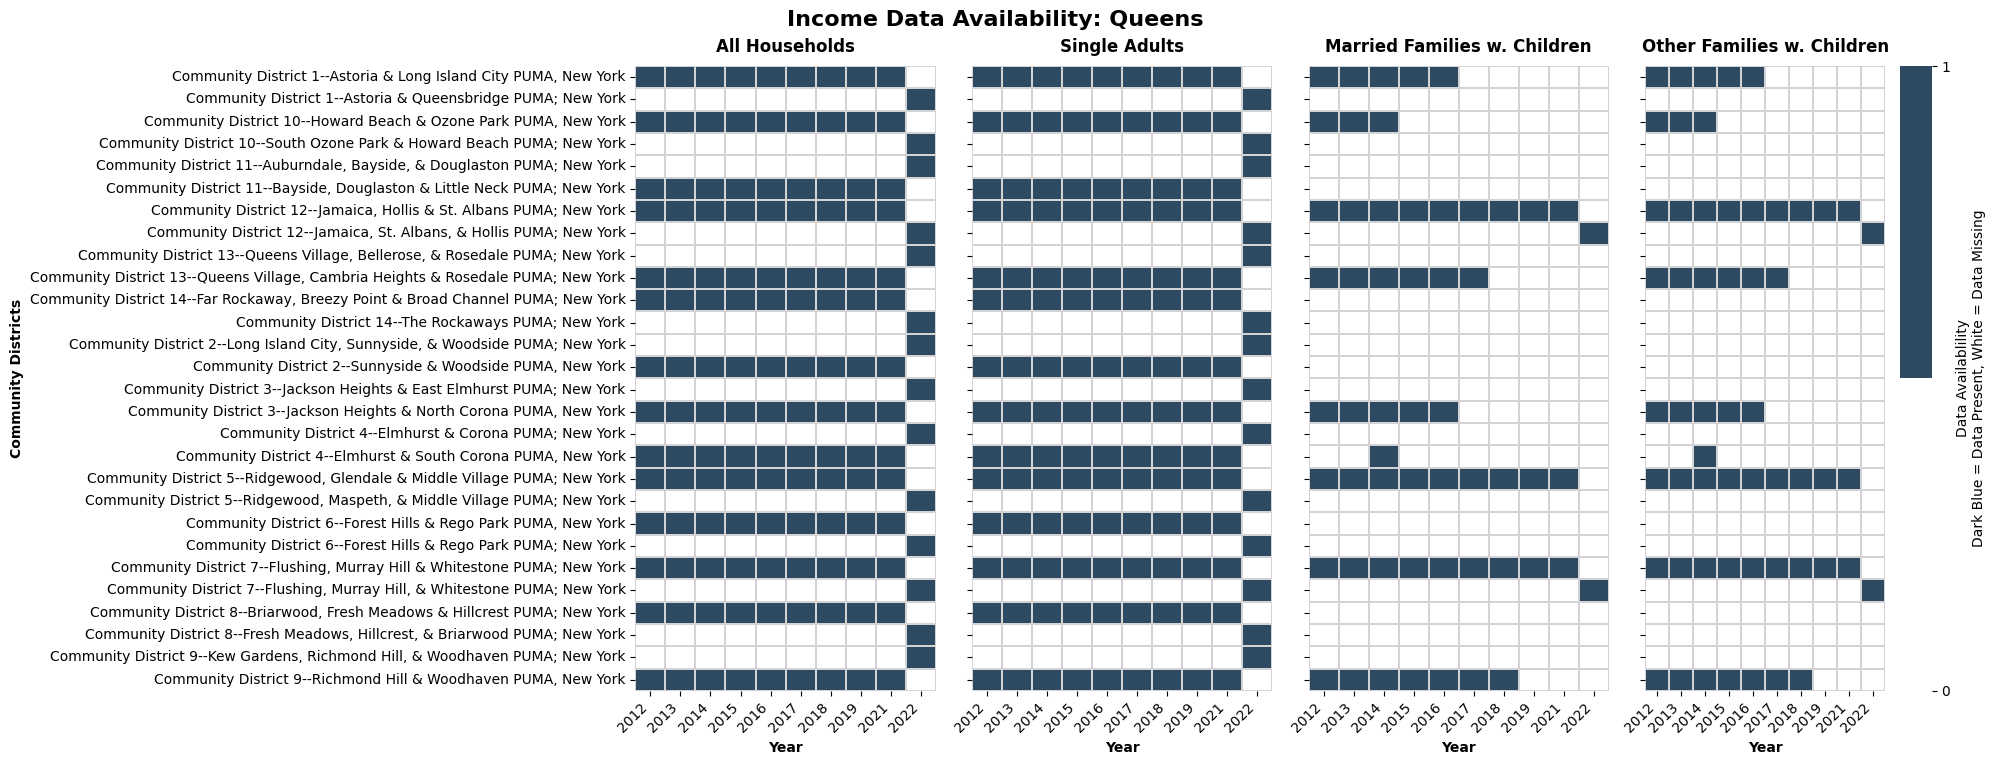

In [ ]:
def create_income_data_availability_heatmaps(income_df, figsize_per_borough=(20, 8)):
    """
    Creates data availability heatmaps for income data across all boroughs and household types.
    
    Parameters:
    ------
    median_income_df : pandas.DataFrame
        The income dataframe with columns: district, PUMA, year, 
         all_HHs, singles, married_kids, other_kids
    figsize_per_borough : tuple
        Figure size for each borough's plot
    """
    
    # Define the household type columns
    household_types = ['all_HHs', 'singles', 'married_kids', 'other_kids']
    household_labels = ['All Households', 'Single Adults', 'Married Families w. Children', 'Other Families w. Children']

    # Extract borough from distruct column 
    income_df['borough'] = income_df['district'].str.extract(r'NYC-([^-]+)')[0].str.split(' Community ', expand=True)[0]
    
    # Get unique boroughs and years
    boroughs = income_df['borough'].unique()
    years = sorted(income_df['year'].unique())
    
    # Custom colormap: white for missing, dark blue for present
    colors = ['white', '#2E4A62']
    custom_cmap = mpl.colors.ListedColormap(colors)
    
    # Create a figure for each borough
    for borough in boroughs:
        if pd.isna(borough):
            continue
            
        print(f"\nProcessing {borough}...")
        
        # Filter data for current borough
        borough_data = income_df[income_df['borough'] == borough].copy()
        
        # Get unique districts for this borough
        districts = sorted(borough_data['district'].unique())
        
        # Create figure with 4 subplots (one for each household type)
        fig, axes = plt.subplots(1, 4, figsize=figsize_per_borough, sharey=True)
        fig.suptitle(f'Income Data Availability: {borough}', 
                    fontsize=16, fontweight='bold', y=0.95)
        
        # Create availability matrix for each household type
        for idx, (hh_type, hh_label) in enumerate(zip(household_types, household_labels)):
            # Initialize availability matrix (districts x years)
            availability_matrix = np.zeros((len(districts), len(years)))
            
            # Fill the matrix
            for district_idx, district in enumerate(districts):
                for year_idx, year in enumerate(years):
                    # Find the row for this district and year
                    mask = (borough_data['district'] == district) & (borough_data['year'] == year)
                    matching_rows = borough_data[mask]
                    
                    if len(matching_rows) > 0:
                        value = matching_rows[hh_type].iloc[0]
                        if pd.notna(value) and str(value).lower() != 'none':
                            availability_matrix[district_idx, year_idx] = 1
                    # If no matching row or value is NaN/None, it remains 0
            
            # Create heatmap for this household type
            ax = axes[idx]
            
            # Create the heatmap
            sns.heatmap(availability_matrix,
                       cmap=custom_cmap,
                       ax=ax,
                       cbar_kws={'label': 'Data Availablility\nDark Blue = Data Present, White = Data Missing',
                                  'ticks': [0, 1]} if idx == 3 else {'ticks': [0, 1]},
                       xticklabels=years,
                       yticklabels=['Community'+district.split(' Community')[1] for district in districts],
                       linewidths=0.1,
                       linecolor='lightgray',
                       cbar=idx == 3, # Only show colorbar on the last subplot
                       vmin=0,  # Explicitly set color range
                       vmax=1)  
            
            # Customize subplot
            ax.set_title(hh_label, fontsize=12, fontweight='bold', pad=10)
            ax.set_xlabel('Year', fontsize=10, fontweight='bold')
            if idx == 0:
                ax.set_ylabel('Community Districts', fontsize=10, fontweight='bold')
            
            # Rotate x-axis labels
            ax.set_xticklabels(years, rotation=45, ha='right')
            
            # Calculate and print summary for this subplot
            total_cells = availability_matrix.size
            present_data = np.sum(availability_matrix)
            coverage_pct = (present_data / total_cells * 100) if total_cells > 0 else 0
            
            print(f"  {hh_label}: {present_data}/{total_cells} data points ({coverage_pct:.1f}% coverage)")
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)  # Make room for suptitle
        
        # Show the plot
        plt.show()
    
    return

create_income_data_availability_heatmaps(income_df)


We can see that it's going to be easy to calculate affordability metrics for 'All Households' and 'Single Adult' populations, however, there is limited coverage of median income for both groups of family populations. Brooklyn and Queens are boroughs with the best data for those family populations, so we will assess affordability for families based on the income and rent data for those 2 boroughs and their respective neighborhoods solely.

## Preliminary Income Data Analysis

### Time series of Median Household Income

#### All Households

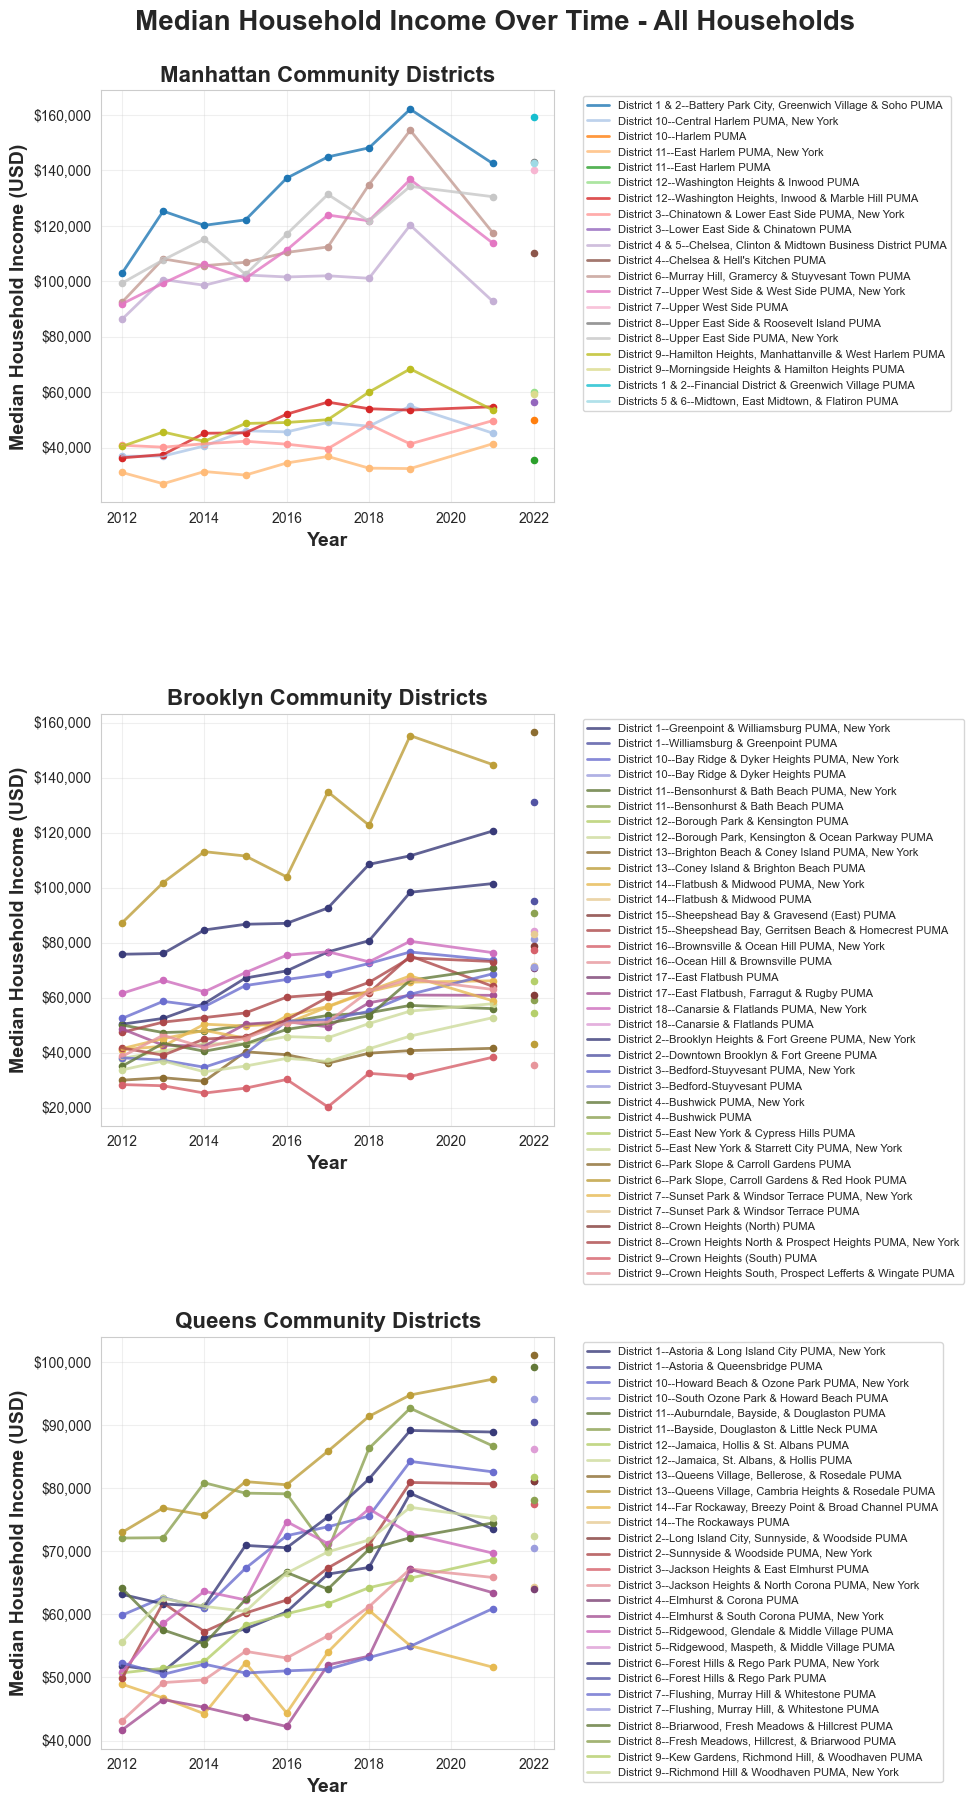

Data Summary by Borough:
--------------------------------------------------
Manhattan: 20 districts w. $81,532 avg income (2012-2022)
Brooklyn: 36 districts w. $60,276 avg income (2012-2022)
Queens: 28 districts w. $66,335 avg income (2012-2022)


In [46]:
# Set up the plot style
sns.set_style("whitegrid")

# Get all NYC boroughs
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create separate plot for each borough
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
axes = axes.flatten()  # Flatten for easier indexing

for i, borough in enumerate(boroughs):
    ax = axes[i]
    
    # Filter data for the current borough
    borough_data = income_df[income_df['district'].str.contains(borough, case=False)][['year','district','all_HHs']]

    if not borough_data.empty:
        # Get unique districts for this borough
        districts = borough_data['district'].unique()
        
        # Create color palette for districts in this borough
        if (borough == 'Brooklyn')|(borough == 'Queens'):
            district_colors = sns.color_palette("tab20b", len(districts))
        else:
            district_colors = sns.color_palette("tab20", len(districts))
        
        # Plot each district as a separate line with unique color
        for j, district_name in enumerate(districts):
            district_data = borough_data[borough_data['district'] == district_name]
            # Sort by year to ensure proper line connections
            district_sorted = district_data.sort_values('year')
            
            ax.plot(district_sorted['year'], district_sorted['all_HHs'], 
                   color=district_colors[j], linewidth=2, alpha=0.8,
                   label=district_name[district_name.find('District'):].split(';')[0] if '--' in district_name else district_name)
            ax.scatter(district_sorted['year'], district_sorted['all_HHs'], 
                   color=district_colors[j], s=20)
        
        # Customize each subplot
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylabel('Median Household Income (USD)', fontsize=14, fontweight='bold')
        ax.set_title(f'{borough} Community Districts', fontsize=16, fontweight='bold')
        
        # Format y-axis to show dollar signs
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend (truncated district names for readability)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    else:
        # Hide empty subplot
        ax.set_visible(False)

# Hide the extra subplot (since we have 5 boroughs but 6 subplot spaces)
#axes[5].set_visible(False)

# Improve overall layout
plt.suptitle('Median Household Income Over Time - All Households', 
             fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# summary statistics
print("Data Summary by Borough:")
print("-" * 50)
for borough in boroughs:
    borough_data = income_df[income_df['district'].str.contains(borough, case=False)]
    if not borough_data.empty:
        avg_income = borough_data['all_HHs'].mean()
        num_districts = borough_data['district'].nunique()
        year_range = f"{borough_data['year'].min()}-{borough_data['year'].max()}"
        print(f"{borough}: {num_districts} districts w. ${avg_income:,.0f} avg income ({year_range})")

#### Single Adults

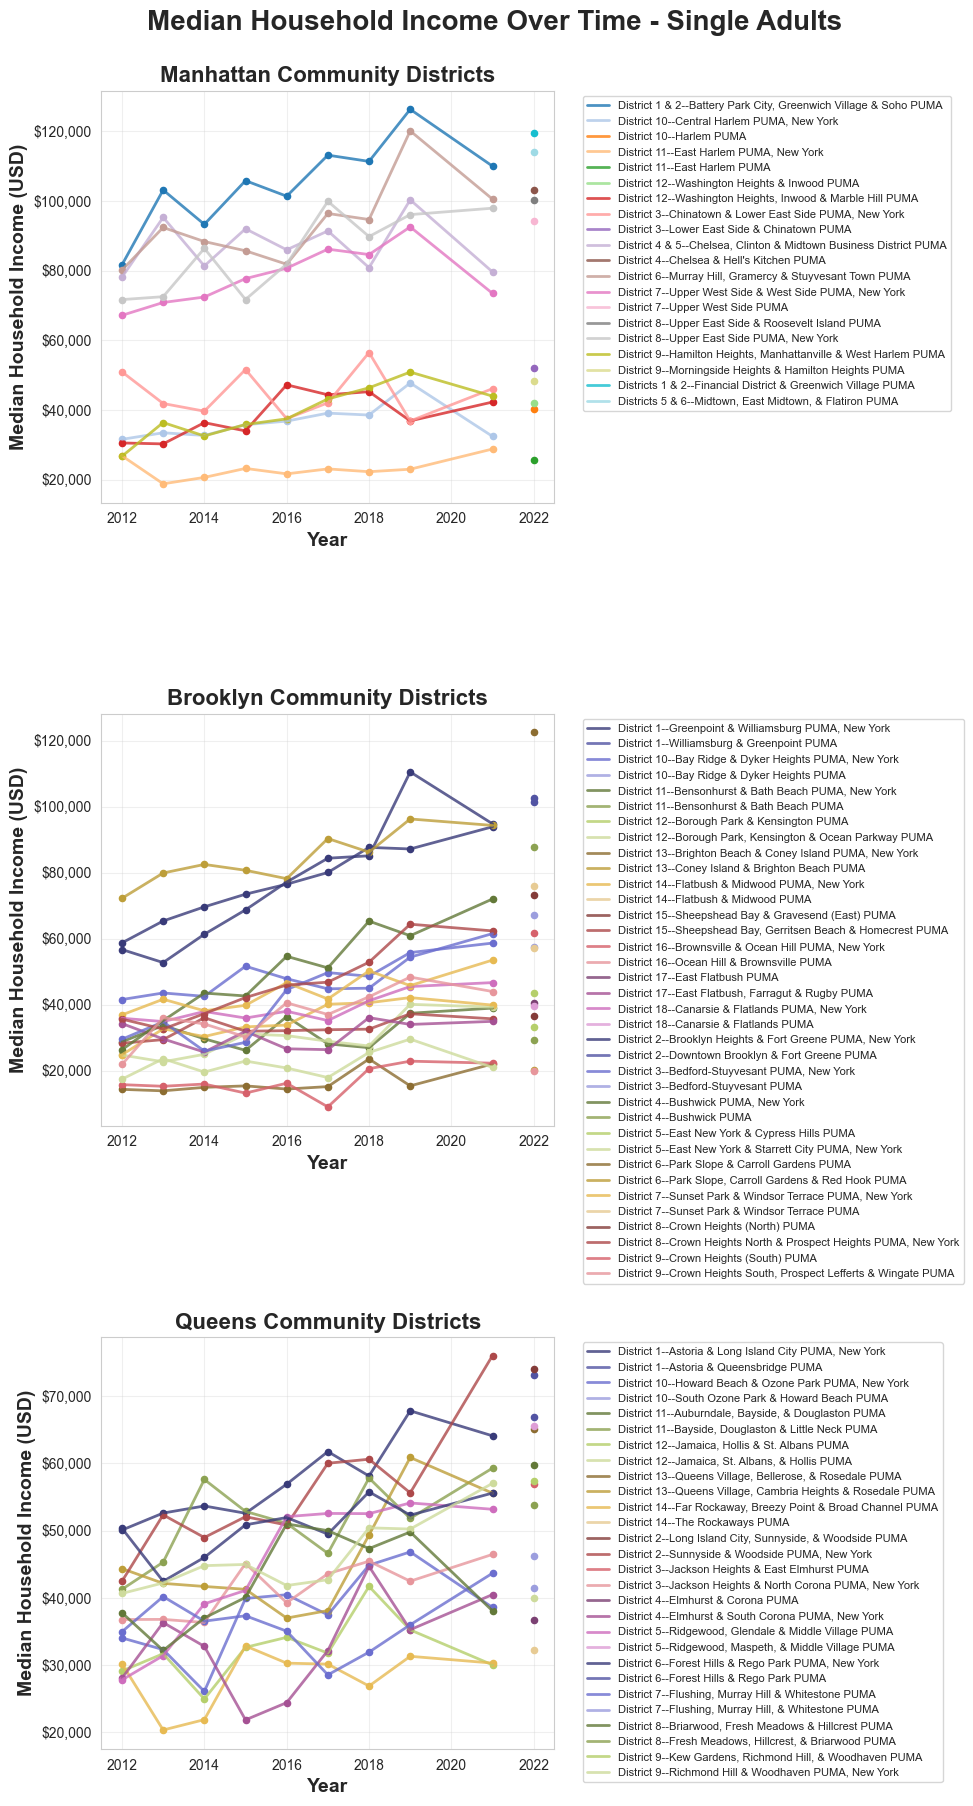

Data Summary by Borough:
--------------------------------------------------
Manhattan: 20 districts w. $64,238 avg income (2012-2022)
Brooklyn: 36 districts w. $44,013 avg income (2012-2022)
Queens: 28 districts w. $44,241 avg income (2012-2022)


In [47]:
# Set up the plot style
sns.set_style("whitegrid")

# Get all NYC boroughs
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create separate plot for each borough
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
axes = axes.flatten()  # Flatten for easier indexing

for i, borough in enumerate(boroughs):
    ax = axes[i]
    
    # Filter data for the current borough
    borough_data = income_df[income_df['district'].str.contains(borough, case=False)][['year','district','singles']]
    
    if not borough_data.empty:
        # Get unique districts for this borough
        districts = borough_data['district'].unique()
        
        # Create color palette for districts in this borough
        if (borough == 'Brooklyn')|(borough == 'Queens'):
            district_colors = sns.color_palette("tab20b", len(districts))
        else:
            district_colors = sns.color_palette("tab20", len(districts))
        
        # Plot each district as a separate line with unique color
        for j, district_name in enumerate(districts):
            district_data = borough_data[borough_data['district'] == district_name]
            # Sort by year to ensure proper line connections
            district_sorted = district_data.sort_values('year')
            
            ax.plot(district_sorted['year'], district_sorted['singles'], 
                   color=district_colors[j], linewidth=2, alpha=0.8,
                   label=district_name[district_name.find('District'):].split(';')[0] if '--' in district_name else district_name)
            ax.scatter(district_sorted['year'], district_sorted['singles'], 
                   color=district_colors[j], s=20)
        
        # Customize each subplot
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylabel('Median Household Income (USD)', fontsize=14, fontweight='bold')
        ax.set_title(f'{borough} Community Districts', fontsize=16, fontweight='bold')
        
        # Format y-axis to show dollar signs
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend (truncated district names for readability)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    else:
        # Hide empty subplot
        ax.set_visible(False)

# Hide the extra subplot (since we have 5 boroughs but 6 subplot spaces)
#axes[5].set_visible(False)

# Improve overall layout
plt.suptitle('Median Household Income Over Time - Single Adults', 
             fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# summary statistics
print("Data Summary by Borough:")
print("-" * 50)
for borough in boroughs:
    borough_data = income_df[income_df['district'].str.contains(borough, case=False)]
    if not borough_data.empty:
        avg_income = borough_data['singles'].mean()
        num_districts = borough_data['district'].nunique()
        year_range = f"{borough_data['year'].min()}-{borough_data['year'].max()}"
        print(f"{borough}: {num_districts} districts w. ${avg_income:,.0f} avg income ({year_range})")

#### Married Families with Children

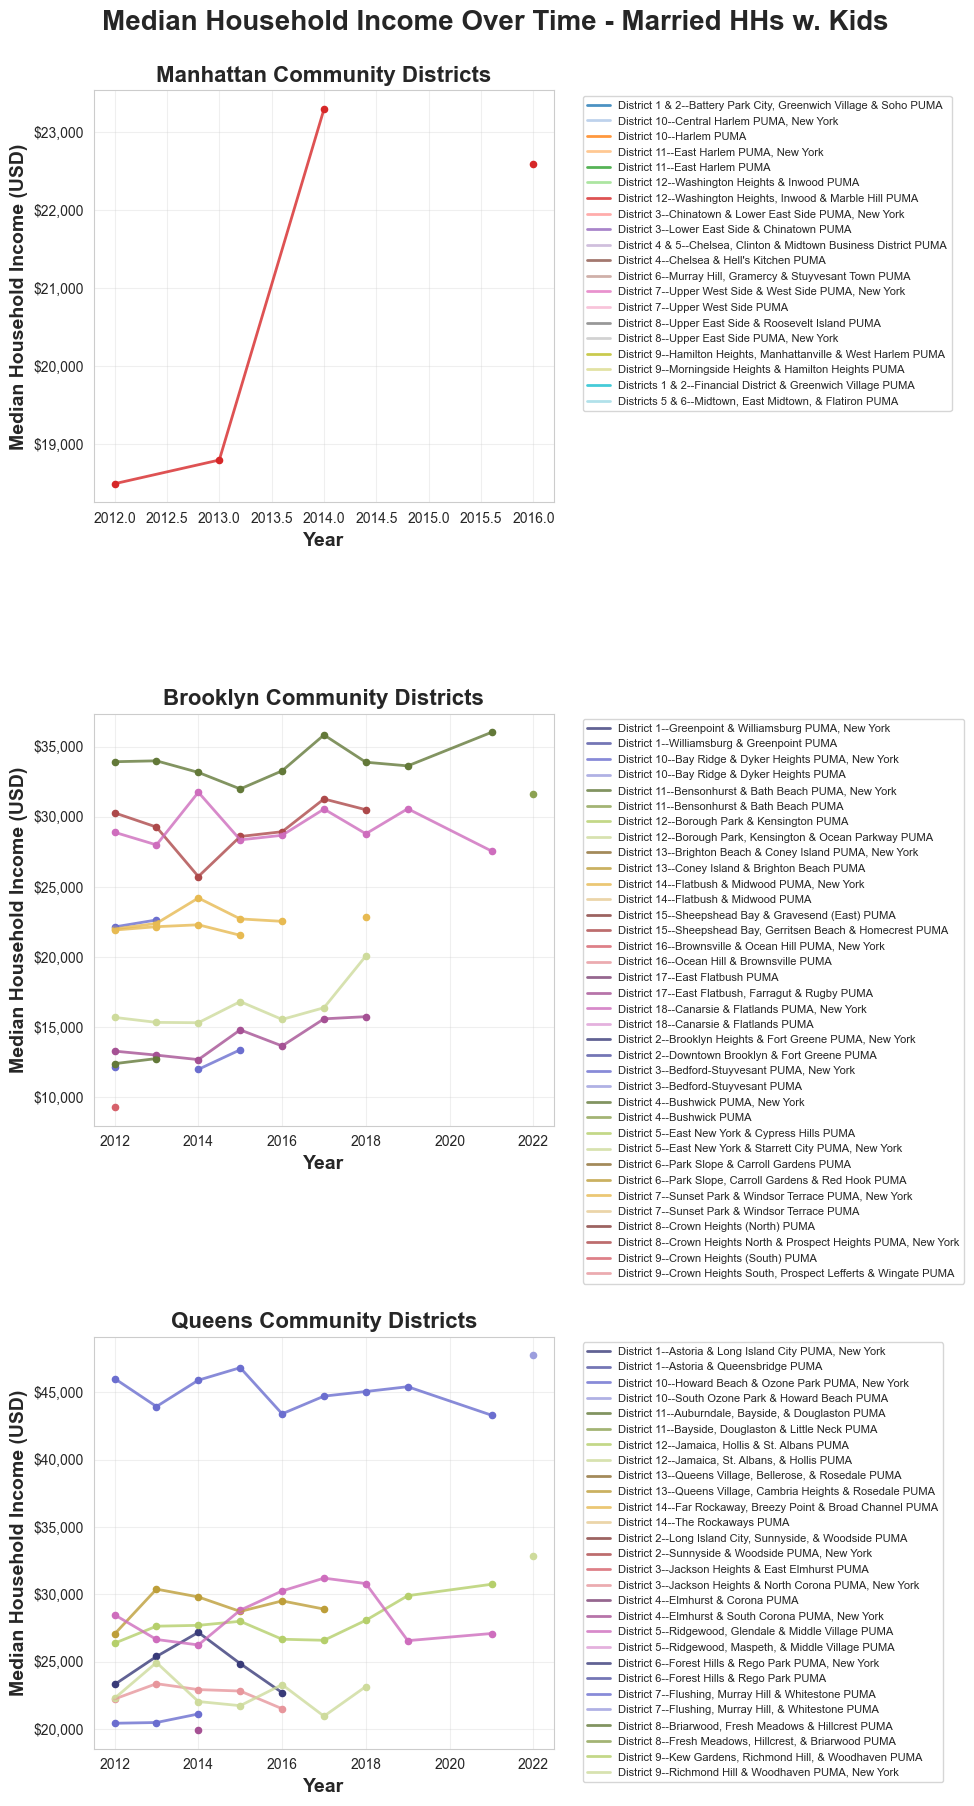

Data Summary by Borough:
--------------------------------------------------
Manhattan: 20 districts w. $20,793 avg income (2012-2022)
Brooklyn: 36 districts w. $23,449 avg income (2012-2022)
Queens: 28 districts w. $29,355 avg income (2012-2022)


In [48]:
# Set up the plot style
sns.set_style("whitegrid")

# Get all NYC boroughs
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create separate plot for each borough
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
axes = axes.flatten()  # Flatten for easier indexing

for i, borough in enumerate(boroughs):
    ax = axes[i]
    
    # Filter data for the current borough
    borough_data = income_df[income_df['district'].str.contains(borough, case=False)][['year','district','married_kids']]
    
    if not borough_data.empty:
        # Get unique districts for this borough
        districts = borough_data['district'].unique()
        
        # Create color palette for districts in this borough
        if (borough == 'Brooklyn')|(borough == 'Queens'):
            district_colors = sns.color_palette("tab20b", len(districts))
        else:
            district_colors = sns.color_palette("tab20", len(districts))
        
        # Plot each district as a separate line with unique color
        for j, district_name in enumerate(districts):
            district_data = borough_data[borough_data['district'] == district_name]
            # Sort by year to ensure proper line connections
            district_sorted = district_data.sort_values('year')
            
            ax.plot(district_sorted['year'], district_sorted['married_kids'], 
                   color=district_colors[j], linewidth=2, alpha=0.8,
                   label=district_name[district_name.find('District'):].split(';')[0] if '--' in district_name else district_name)
            ax.scatter(district_sorted['year'], district_sorted['married_kids'], 
                   color=district_colors[j], s=20)
        
        # Customize each subplot
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylabel('Median Household Income (USD)', fontsize=14, fontweight='bold')
        ax.set_title(f'{borough} Community Districts', fontsize=16, fontweight='bold')
        
        # Format y-axis to show dollar signs
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend (truncated district names for readability)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    else:
        # Hide empty subplot
        ax.set_visible(False)

# Hide the extra subplot (since we have 5 boroughs but 6 subplot spaces)
#axes[5].set_visible(False)

# Improve overall layout
plt.suptitle('Median Household Income Over Time - Married HHs w. Kids', 
             fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# summary statistics
print("Data Summary by Borough:")
print("-" * 50)
for borough in boroughs:
    borough_data = income_df[income_df['district'].str.contains(borough, case=False)]
    if not borough_data.empty:
        avg_income = borough_data['married_kids'].mean()
        num_districts = borough_data['district'].nunique()
        year_range = f"{borough_data['year'].min()}-{borough_data['year'].max()}"
        print(f"{borough}: {num_districts} districts w. ${avg_income:,.0f} avg income ({year_range})")

#### Other Families with Children

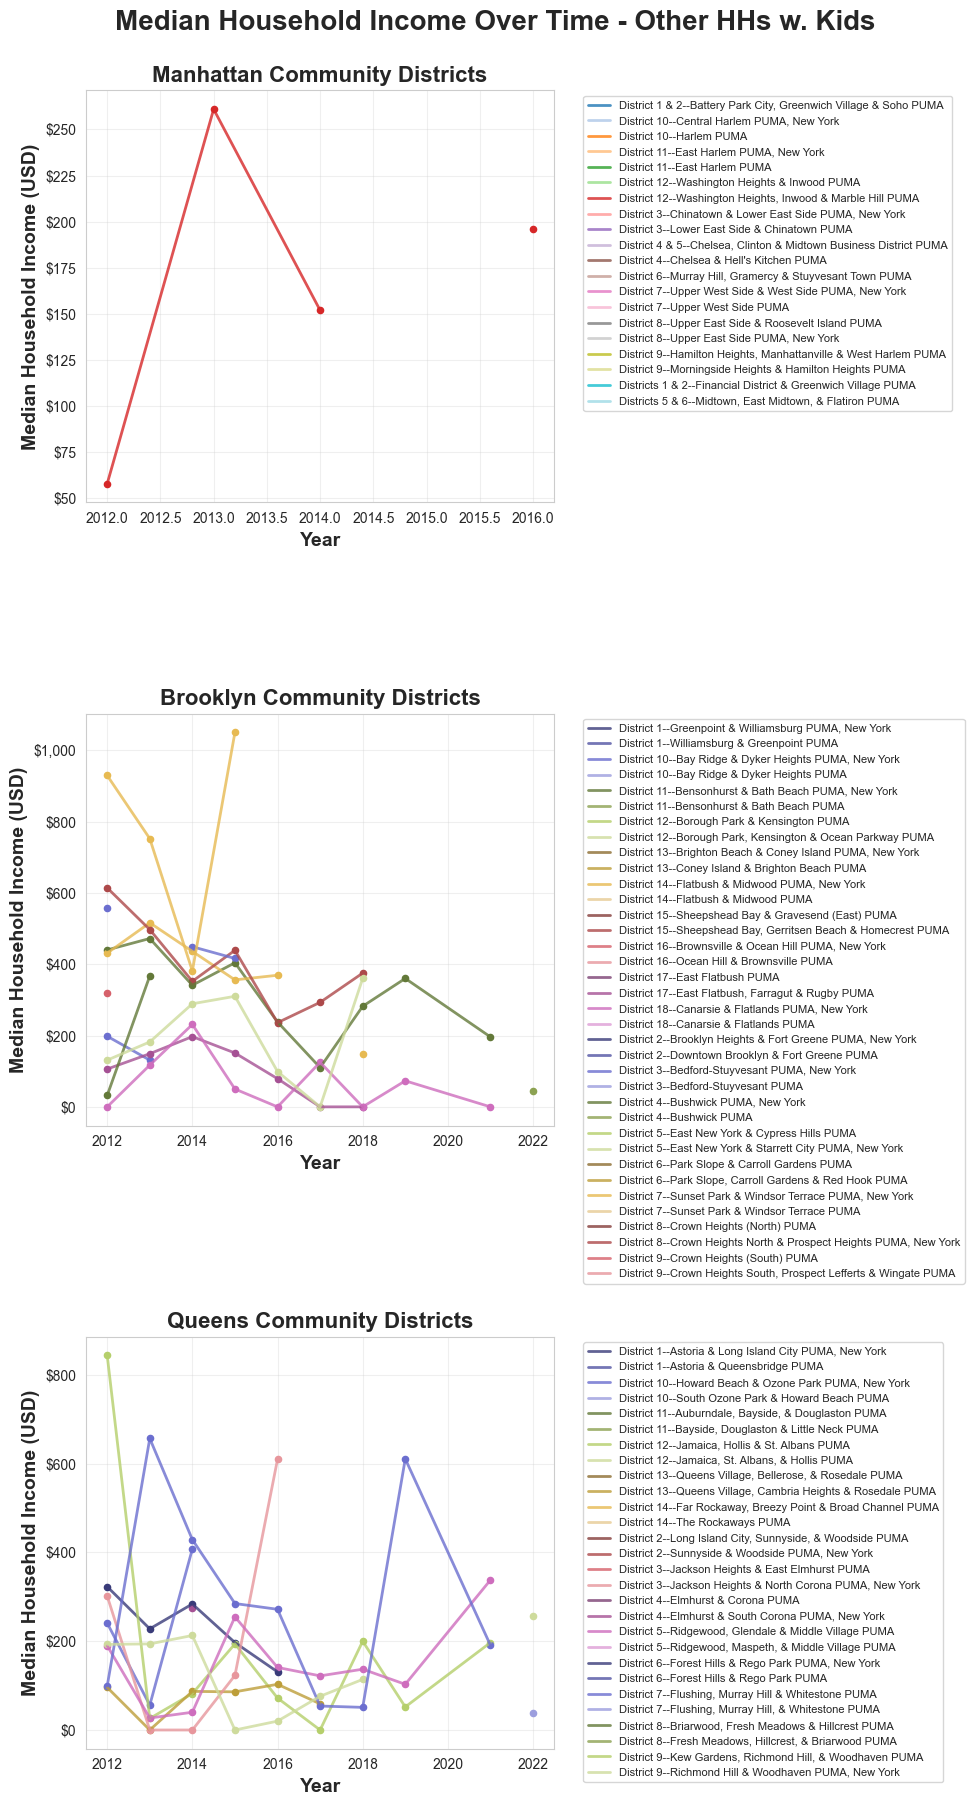

Data Summary by Borough:
--------------------------------------------------
Manhattan: 20 districts w. $167 avg income (2012-2022)
Brooklyn: 36 districts w. $279 avg income (2012-2022)
Queens: 28 districts w. $185 avg income (2012-2022)


In [49]:
# Set up the plot style
sns.set_style("whitegrid")

# Get all NYC boroughs
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create separate plot for each borough
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
axes = axes.flatten()  # Flatten for easier indexing

for i, borough in enumerate(boroughs):
    ax = axes[i]
    
    # Filter data for the current borough
    borough_data = income_df[income_df['district'].str.contains(borough, case=False)][['year','district','other_kids']]
    
    if not borough_data.empty:
        # Get unique districts for this borough
        districts = borough_data['district'].unique()
        
        # Create color palette for districts in this borough
        if (borough == 'Brooklyn')|(borough == 'Queens'):
            district_colors = sns.color_palette("tab20b", len(districts))
        else:
            district_colors = sns.color_palette("tab20", len(districts))
        
        # Plot each district as a separate line with unique color
        for j, district_name in enumerate(districts):
            district_data = borough_data[borough_data['district'] == district_name]
            # Sort by year to ensure proper line connections
            district_sorted = district_data.sort_values('year')
            
            ax.plot(district_sorted['year'], district_sorted['other_kids'], 
                   color=district_colors[j], linewidth=2, alpha=0.8,
                   label=district_name[district_name.find('District'):].split(';')[0] if '--' in district_name else district_name)
            ax.scatter(district_sorted['year'], district_sorted['other_kids'], 
                   color=district_colors[j], s=20)
        
        # Customize each subplot
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylabel('Median Household Income (USD)', fontsize=14, fontweight='bold')
        ax.set_title(f'{borough} Community Districts', fontsize=16, fontweight='bold')
        
        # Format y-axis to show dollar signs
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend (truncated district names for readability)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    else:
        # Hide empty subplot
        ax.set_visible(False)

# Hide the extra subplot (since we have 5 boroughs but 6 subplot spaces)
#axes[5].set_visible(False)

# Improve overall layout
plt.suptitle('Median Household Income Over Time - Other HHs w. Kids', 
             fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# summary statistics
print("Data Summary by Borough:")
print("-" * 50)
for borough in boroughs:
    borough_data = income_df[income_df['district'].str.contains(borough, case=False)]
    if not borough_data.empty:
        avg_income = borough_data['other_kids'].mean()
        num_districts = borough_data['district'].nunique()
        year_range = f"{borough_data['year'].min()}-{borough_data['year'].max()}"
        print(f"{borough}: {num_districts} districts w. ${avg_income:,.0f} avg income ({year_range})")

## Load/Uploading Dataset to BigQuery

In [52]:
# configuration
PROJECT_ID = "rent-affordability"
DATASET = "nyc_analysis"
TABLE_ID = f"{PROJECT_ID}.{DATASET}.staging_median_income"

# load credentials
service_account_info = json.loads(os.environ["GOOGLE_CREDENTIALS_JSON"])
credentials = service_account.Credentials.from_service_account_info(service_account_info)
# initialize client
client = bigquery.Client(project=PROJECT_ID, credentials=credentials)
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

job = client.load_table_from_dataframe(income_df, TABLE_ID, job_config=job_config)
job.result() # ensures the script waits for the job to complete

# 5a. check if the upload was successful
if job.state == 'DONE':
    if job.error_result:
        print(f"Job completed with errors: {job.error_result}")
    else:
        print(f"Job completed successfully. Loaded {job.output_rows} rows to {TABLE_ID}")
else:
    print(f"Job state: {job.state}")

Job completed successfully. Loaded 420 rows to rent-affordability.nyc_analysis.staging_median_income
